<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Web Scraping and Salary Prediction

## 01. Data Collection, Cleaning and EDA

<br/><br/>

This project was completed during my Data Science Immersive bootcamp at General Assembly in London.

The project aims to determine the industry factors that are most important in predicting the salary amounts in various data related fields.  
To achieve this, I decided to collect and analyse data from a job aggregator website, Indeed.com.  
To limit the scope, it was suggested to *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others relevant terms. In addition, I could decrease the scope by *limiting the search to a single region.*  



**Goals:**
- Scrape data from a job aggregation tool in order to collect the data to best answer the initial question.
- Discover which job features impact salary the most.
- Create a classification model to predict whether a job will pay more or less than the median salary, based on the features of the job.  

<br/><br/>

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead I just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, I'll split the salary into two groups of high and low salary, by choosing the median salary as a threshold (in principle I could choose any single or multiple splitting points).  

<br/><br/>

## Libraries Import  

<br/><br/>

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import re

In [2]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from time import time, sleep

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Data Extraction  

<br/><br/>

### Functions to extract job details: title, company, location, salary....

In [5]:
# Job Title
def get_job_title(cards):
    job_title = []
    try:
        jt = card.find('h2', class_='jobTitle').text.strip('\\\n ')
    except:
        jt = 'Not Available'
    job_title.append(jt)
    return job_title

# Company Name
def get_company_name(cards):
    company_name = []
    try:
        cn = card.find('span', class_='companyName').text.strip('\\\n ')
    except:
        cn = 'Not Available'
    company_name.append(cn)
    return company_name

# Company Rating
def get_company_rating(cards):
    company_rating = []
    try:
        cr = card.find('span', class_='ratingNumber').text.strip('\\\n ')
    except Exception as e:
        cr = 'Not Available'
    company_rating.append(cr)
    return company_rating

# Company Location
def get_company_location(cards):
    company_location = []
    cl = card.find('div', class_='companyLocation').text.strip('\\\n ')
    cl = re.sub('\\\\\\n\s*', ' ', cl)
    cl = re.sub('\xa0', ' ', cl)
    company_location.append(cl)
    return company_location

# Salary Amount
def get_salary_amount(cards):
    salary_amount = []
    try:
        sa = card.find('div', class_='salary-snippet-container').text.strip('\\\n ')
    except:
        sa = 'Not Available'
    salary_amount.append(sa)
    return salary_amount

# Salary Estimate
def get_salary_estimate(cards):
    salary_estimate = []
    try:
        se = card.find('span', class_='estimated-salary').text.strip('\\\n ')
    except:
        se = 'Not Available'
    salary_estimate.append(se)
    return salary_estimate

# Multi Candidate
def get_multi_candidate(cards):
    multi_candidate = []
    try:
        mc = card.find('div', class_='hiringMultipleCandidatesCaption').text.strip('\\\n ')
    except:
        mc = 'Not Available'
    multi_candidate.append(mc)
    return multi_candidate

# Job Snippet
def get_job_snippet(cards):
    job_snippet = []
    try:
        js = card.find('div', class_='job-snippet').text.strip('\\\n ')
        js = re.sub('\\\\\\n\s*', ' ', js)
        js = re.sub('\\n', ' ', js)
    except:
        js = 'Not Available'
    job_snippet.append(js)
    return job_snippet

### Code to scrape Indeed.com website 

#### FIRST SCRAPE: looking at major US cities retrieving a small number of results

In [5]:
# Defining the extent of scrape
max_results_per_city = 30

# Creating an empty dataframe
results = pd.DataFrame(columns = ['job_title',
                                  'company_name',
                                  'company_rating',
                                  'company_location',
                                  'salary_amount',
                                  'salary_estimate',
                                  'multi_candidate',
                                  'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each city, scraping the first 3 pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Albuquerque', 'Atlanta', 'Austin', 'Baltimore', 'Boston', 'Charlotte',
                     'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Dallas',
                     'Denver', 'Detroit', 'Houston', 'Kansas+City', 'Los+Angeles',
                     'Menlo+Park', 'Miami', 'Minneapolis', 'Nashville', 'New+Orleans',
                     'New+York', 'Orlando', 'Palo+Alto', 'Philadelphia', 'Phoenix',
                     'Pittsburgh', 'Portland', 'Raleigh+Durham', 'Salt+Lake+City', 'San+Antonio',
                     'San+Diego', 'San+Francisco', 'San+Jose', 'Seattle', 'St+Louis',
                     'Tampa', 'Washington']):
        
        for start in range(0, max_results_per_city, 10):
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe        
            results = pd.concat([results, page_df])
            
            sleep(3)

results.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [132]:
# Saving the scraping results as CSV
results.to_csv('datasets/scrape/results_scrape.csv', encoding='utf-8', index=False)

In [4]:
# Loading the data from CSV for consistency reasons
results_m = pd.read_csv('datasets/scrape/results_scrape.csv')

In [5]:
results_m.head(17)

,index,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet
0,0,Student Research Assistant,University of New Mexico,4.0,"Albuquerque, NM 87106 (University Hts area)",$16 an hour,Not Available,Not Available,Informatics. Approaches include machine learni...
1,1,Data Scientist Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $178K - $225K a year,Not Available,Expert understanding of Python and other commo...
2,2,"Data Scientist, Senior",Booz Allen Hamilton,3.9,"Remote in Kirtland AFB, NM",Not Available,Estimated $95.2K - $121K a year,Not Available,"Experience with natural language processing, s..."
3,3,Solution Architecture Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $179K - $227K a year,Not Available,"One or more programming languages (i.e. C#, Ja..."
4,4,"Manager, Cognitive and AI - Remote",KPMG,3.9,"Remote in Albuquerque, NM 87110",Not Available,Estimated $122K - $154K a year,Not Available,Manage all Cognitive projects and Cognitive an...
5,5,Software Engineer (JR),Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $102K - $129K a year,Not Available,The successful candidate will have experience ...
6,6,Data Science Manager,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $120K - $152K a year,Not Available,The successful candidate will be experienced w...
7,7,"Software Engineer, Manager - Tax Analysis & De...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $150K - $190K a year,Not Available,Experience working with one or more from the f...
8,8,"Lead Software Engineer, Tax Analysis & Debt In...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $129K - $163K a year,Not Available,Experience working with one or more from the f...
9,9,Sr. Software Engineer,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $106K - $135K a year,Not Available,The successful candidate will have experience ...


In [6]:
results_m.shape

(15755, 9)

In [7]:
results_m.drop(columns='index', inplace=True)

In [8]:
results_m.shape

(15755, 8)

In [9]:
# Removing duplicate entries
results_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [10]:
results_m.shape

(13599, 8)

In [11]:
results_m.salary_amount.value_counts()

Not Available                 10420
$150,000 - $200,000 a year       60
$82,100 - $146,900 a year        45
$90,000 - $110,000 a year        43
$66,100 - $118,300 a year        29
                              ...  
$52,650 - $90,000 a year          1
$110,000 - $120,000 a year        1
$160,130 - $268,093 a year        1
$100,000 - $350,000 a year        1
$42,596 - $49,310 a year          1
Name: salary_amount, Length: 1810, dtype: int64

In [12]:
list(results_m.salary_amount.unique())

['$16 an hour',
 'Not Available',
 '$150,000 - $230,000 a year',
 '$190,000 - $230,000 a year',
 '$150,000 - $200,000 a year',
 '$275,000 - $400,000 a year',
 '$135,000 - $200,000 a year',
 '$90,000 a year',
 '$80,000 - $200,000 a year',
 '$135,000 - $155,000 a year',
 '$110,000 - $400,000 a year',
 '$183,000 - $208,000 a year',
 '$135,000 - $185,000 a year',
 '$100,000 - $140,000 a year',
 '$90,000 - $110,000 a year',
 '$70,000 - $130,000 a year',
 '$95,000 - $209,000 a year',
 '$58,955 - $74,991 a year',
 '$53,760 a year',
 '$85,000 - $170,400 a year',
 '$60,000 - $100,000 a year',
 '$18.00 - $20.55 an hour',
 '$60 - $70 an hour',
 '$100,000 - $160,000 a year',
 '$65 - $90 an hour',
 '$15 - $20 an hour',
 '$150,000 - $180,000 a year',
 '$110,000 - $140,000 a year',
 '$80,000 - $110,000 a year',
 '$65 a day',
 '$147,250 - $235,000 a year',
 '$126,700 - $145,000 a year',
 '$22.88 - $38.31 an hour',
 '$52.52 - $82.69 an hour',
 '$47,600 - $79,699 a year',
 '$36.49 - $62.52 an hour',
 '$

In [13]:
# Removing entries without salary amount information
results_m = results_m[results_m.salary_amount != 'Not Available']

In [14]:
results_m.shape

(3179, 8)

In [15]:
# Removing entries with salary amount refering to hour, day
results_m = results_m[~results_m.salary_amount.str.contains('hour')]
results_m = results_m[~results_m.salary_amount.str.contains('day')]
results_m.shape

(2765, 8)

In [193]:
# Saving the modified dataframe as CSV
results_m.to_csv('datasets/mod/results_m.csv', encoding='utf-8', index=False)

This initial dataset is slightly small for this exercise, I will increase the number of results trying a different approach.  
  
  
I am going to define 3 tiers for the US cities, based on the number of job postings.  
Tier 1 contains cities with more than 480 jobs for data scientist on Indeed.  
Tier 2 contains cities with a number of jobs between 120 and 480.  
Tier 3 contains cities with less than 120 jobs.  

<br/><br/>

#### SECOND SCRAPE: looking at major US cities with a tiered approach for retrieving results

##### Tier 1 cities

In [6]:
# Defining the extent of scrape
us01_max_results_per_city = 320   # Multiple of 10. 10 = 1 step, 15 results for each step.
us02_max_results_per_city = 160 
us03_max_results_per_city = 40 

# Creating an empty dataframe
us01_res = pd.DataFrame(columns = ['job_title',
                                   'company_name',
                                   'company_rating',
                                   'company_location',
                                   'salary_amount',
                                   'salary_estimate',
                                   'multi_candidate',
                                   'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each tier 1 city, scraping the relative pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Boston', 'Chicago', 'Menlo+Park', 'New+York', 'Palo+Alto',
                     'San+Francisco', 'San+Jose', 'Seattle', 'Washington']):
        
        for start in range(0, us01_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
            
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe        
            us01_res = pd.concat([us01_res, page_df])

            sleep(3)
            
us01_res.reset_index(inplace=True)  

# Closing Chrome
dr.quit()

In [173]:
# Saving the scraping results as CSV
us01_res.to_csv('datasets/scrape/us01_res.csv', encoding='utf-8', index=False)

In [16]:
# Loading the data from CSV for consistency reasons
us01_m = pd.read_csv('datasets/scrape/us01_res.csv')

In [17]:
us01_m.head(17)

,index,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet
0,0,Machine Learning/Natural Language Processing R...,"Hitachi America, Ltd.",3.8,"Santa Clara, CA 95054",Not Available,Not Available,Not Available,Strong research experience in natural language...
1,1,"Research Scientist, Natural Language Processin...",ByteDance,4.1,"Mountain View, CA+6 locations",Not Available,Not Available,Not Available,Conduct cutting-edge research in machine learn...
2,2,Vision-and-Language Understanding,Honda Research Institute USA,Not Available,"San Jose, CA",Not Available,Estimated $60.8K - $76.9K a year,Not Available,Strong familiarity with computer vision and na...
3,3,Member of Research Staff - Fujitsu Research,Fujitsu,3.6,"Sunnyvale, CA 94085 (East Murphy area)",Not Available,Not Available,Not Available,"Strong background and knowledge in AutoML, mac..."
4,4,Machine Learning Scientist (L5) - Programming ...,Netflix,3.9,"Los Gatos, CA+1 location",Not Available,Not Available,Not Available,3+ years of experience as a hands-on expert-le...
5,5,AI/ML - Machine Learning Engineer and Scientis...,Apple,4.1,"Cupertino, CA+9 locations",Not Available,Not Available,Not Available,We are looking for ML engineers and researcher...
6,6,Data Scientist I,The Trade Desk,4.0,"San Jose, CA 95113 (Downtown area)",Not Available,Estimated $111K - $140K a year,Not Available,You have some experience with big data technol...
7,7,Linguistics Analyst- Text to Speech (TTS) Italian,Accenture,4.0,"San Jose, CA 95113 (Downtown area)+1 location",Not Available,Not Available,Not Available,The Linguistics Analyst Text to Speech TTS Ita...
8,8,Data Scientist,Uber,3.6,"Sunnyvale, CA 94086",Not Available,Not Available,Hiring multiple candidates,The product development roadmap includes sever...
9,9,Research Scientist (L5) - Product Machine Lear...,Netflix,3.9,"Los Gatos, CA",Not Available,Not Available,Not Available,You will develop expertise in the frontiers of...


In [18]:
us01_m.shape

(28628, 9)

In [19]:
us01_m.drop(columns='index', inplace=True)

In [20]:
# Removing duplicate entries
us01_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [21]:
us01_m.shape

(12520, 8)

In [22]:
# Removing entries without salary amount information
us01_m = us01_m[us01_m.salary_amount != 'Not Available']

In [23]:
us01_m.shape

(2639, 8)

In [24]:
# Removing entries with salary amount refering to hour, day
us01_m = us01_m[~us01_m.salary_amount.str.contains('hour')]
us01_m = us01_m[~us01_m.salary_amount.str.contains('day')]
us01_m.shape

(2380, 8)

In [203]:
# Saving the modified dataframe as CSV
us01_m.to_csv('datasets/mod/us01_m.csv', encoding='utf-8', index=False)

##### Tier 2 cities

In [7]:
# Defining the extent of scrape
us01_max_results_per_city = 320   # Multiple of 10. 10 = 1 step, 15 results for each step.
us02_max_results_per_city = 160 
us03_max_results_per_city = 40 

# Creating an empty dataframe
us02_res = pd.DataFrame(columns = ['job_title',
                                   'company_name',
                                   'company_rating',
                                   'company_location',
                                   'salary_amount',
                                   'salary_estimate',
                                   'multi_candidate',
                                   'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each tier 2 city, scraping the relative pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Atlanta', 'Austin', 'Baltimore', 'Dallas', 'Denver',
                     'Detroit', 'Houston' , 'Los+Angeles', 'Minneapolis', 'Philadelphia',
                     'Pittsburgh', 'Raleigh+Durham', 'San+Diego']):
        
        for start in range(0, us02_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe
            us02_res = pd.concat([us02_res, page_df])

            sleep(3)

us02_res.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [204]:
# Saving the scraping results as CSV
us02_res.to_csv('datasets/scrape/us02_res.csv', encoding='utf-8', index=False)

In [25]:
# Loading the data from CSV for consistency reasons
us02_m = pd.read_csv('datasets/scrape/us02_res.csv')

In [26]:
us02_m.head(17)

,index,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet
0,0,Security Research Engineer (Full Time) United ...,Cisco Systems,4.1,"Remote in Research Triangle Park, NC",Not Available,Not Available,Not Available,US Citizenship is required due to the nature o...
1,1,Research Agreements Manager,Duke University,4.0,"Durham, NC 27710 (Duke West Campus area)",Not Available,Not Available,Not Available,"Experience in a legal, human research protecti..."
2,2,Clinical Research Associate II,Veristat,4.2,"Remote in Morrisville, NC 27560",Not Available,Not Available,Not Available,May provide input into the development of clin...
3,3,BTC - RESEARCH ASSOCIATE,Duke University,4.0,"Durham, NC 27710 (Duke West Campus area)",Not Available,Not Available,Not Available,Contribute to supporting the clinical and tran...
4,4,Clinical Data Manager,MM Infotech,Not Available,"Durham, NC",Not Available,Not Available,Not Available,Coordinates activities including: medical codi...
5,5,"Staff Scientist I, Pre-Clinical Toxicology",BD,3.8,"Research Triangle Park, NC",Not Available,Not Available,Not Available,"This position addresses the toxicology, biocom..."
6,6,"Regulatory Affairs Scientist - (Raleigh, NC or...",UCB S.A.,3.8,"Raleigh, NC 27617 (Northwest Raleigh area)",Not Available,Not Available,Not Available,This person will be responsible for preparing ...
7,7,"DIRECTOR, DIVERSITY EQUITY AND INCLUSION - SAN...",Duke University,4.0,"Durham, NC 27710 (Duke West Campus area)",Not Available,Not Available,Not Available,"The Director of Diversity, Equity, and Inclusi..."
8,8,Senior Clinical Research Associate (CRA),Ergomed,Not Available,"Raleigh, NC",Not Available,Not Available,Not Available,Carry out site selection and feasibility. To a...
9,9,"Lead Scientist, Team Leader",Catalent,3.1,"Morrisville, NC 27560",Not Available,Not Available,Not Available,Understands the elements of a regulatory CMC f...


In [27]:
us02_m.shape

(18579, 9)

In [28]:
us02_m.drop(columns='index', inplace=True)

In [29]:
# Removing duplicate entries
us02_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [30]:
us02_m.shape

(12041, 8)

In [31]:
# Removing entries without salary amount information
us02_m = us02_m[us02_m.salary_amount != 'Not Available']

In [32]:
us02_m.shape

(2485, 8)

In [33]:
# Removing entries with salary amount refering to hour, day
us02_m = us02_m[~us02_m.salary_amount.str.contains('hour')]
us02_m = us02_m[~us02_m.salary_amount.str.contains('day')]
us02_m.shape

(2220, 8)

In [214]:
# Saving the modified dataframe as CSV
us02_m.to_csv('datasets/mod/us02_m.csv', encoding='utf-8', index=False)

##### Tier 3 cities

In [8]:
# Defining the extent of scrape
us01_max_results_per_city = 320   # Multiple of 10. 10 = 1 step, 15 results for each step.
us02_max_results_per_city = 160 
us03_max_results_per_city = 40 

# Creating an empty dataframe
us03_res = pd.DataFrame(columns = ['job_title',
                                   'company_name',
                                   'company_rating',
                                   'company_location',
                                   'salary_amount',
                                   'salary_estimate',
                                   'multi_candidate',
                                   'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each tier 3 city, scraping the relative pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Albuquerque', 'Charlotte', 'Cincinnati', 'Cleveland', 'Columbus', 'Kansas+City',
                     'Miami', 'Nashville', 'New+Orleans', 'Orlando', 'Phoenix',
                     'Portland', 'Salt+Lake+City', 'San+Antonio', 'St+Louis', 'Tampa']):
        
        for start in range(0, us03_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe
            us03_res = pd.concat([us03_res, page_df])

            sleep(3)

us03_res.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [215]:
# Saving the scraping results as CSV
us03_res.to_csv('datasets/scrape/us03_res.csv', encoding='utf-8', index=False)

In [34]:
# Loading the data from CSV for consistency reasons
us03_m = pd.read_csv('datasets/scrape/us03_res.csv')

In [35]:
us03_m.head(17)

,index,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet
0,0,Student Research Assistant,University of New Mexico,4.0,"Albuquerque, NM 87106 (University Hts area)",$16 an hour,Not Available,Not Available,Informatics. Approaches include machine learni...
1,1,Data Scientist Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $178K - $225K a year,Not Available,Expert understanding of Python and other commo...
2,2,"Data Scientist, Senior",Booz Allen Hamilton,3.9,"Remote in Kirtland AFB, NM",Not Available,Estimated $95.2K - $121K a year,Not Available,"Experience with natural language processing, s..."
3,3,Solution Architecture Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $179K - $227K a year,Not Available,"One or more programming languages (i.e. C#, Ja..."
4,4,Software Engineer (JR),Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $102K - $129K a year,Not Available,The successful candidate will have experience ...
5,5,"Manager, Cognitive and AI - Remote",KPMG,3.9,"Remote in Albuquerque, NM 87110",Not Available,Estimated $122K - $154K a year,Not Available,Manage all Cognitive projects and Cognitive an...
6,6,"Software Engineer, Manager - Tax Analysis & De...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $150K - $190K a year,Not Available,Experience working with one or more from the f...
7,7,Data Science Manager,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $120K - $152K a year,Not Available,The successful candidate will be experienced w...
8,8,"Lead Software Engineer, Tax Analysis & Debt In...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $129K - $163K a year,Not Available,Experience working with one or more from the f...
9,9,Sr. Software Engineer,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $106K - $135K a year,Not Available,The successful candidate will have experience ...


In [36]:
us03_m.shape

(8162, 9)

In [37]:
us03_m.drop(columns='index', inplace=True)

In [38]:
# Removing duplicate entries
us03_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [39]:
us03_m.shape

(6857, 8)

In [40]:
# Removing entries without salary amount information
us03_m = us03_m[us03_m.salary_amount != 'Not Available']

In [41]:
us03_m.shape

(1419, 8)

In [42]:
# Removing entries with salary amount refering to hour, day
us03_m = us03_m[~us03_m.salary_amount.str.contains('hour')]
us03_m = us03_m[~us03_m.salary_amount.str.contains('day')]
us03_m.shape

(1137, 8)

In [225]:
# Saving the modified dataframe as CSV
us03_m.to_csv('datasets/mod/us03_m.csv', encoding='utf-8', index=False)

The datasets for the 3 tiers have a combined total of 5,737 entries after removing duplicates and unusable salary information.  
  
I am going to perform a final scraping, without using tiers but aiming at a larger number of results.  

<br/><br/>

#### FINAL SCRAPE: looking at major US cities retrieving a large number of results

In [9]:
# Defining the extent of scrape
us_max_results_per_city = 600   # Set this to a high-value (5000) to generate more results.

# Creating an empty dataframe
us_res = pd.DataFrame(columns = ['job_title',
                                  'company_name',
                                  'company_rating',
                                  'company_location',
                                  'salary_amount',
                                  'salary_estimate',
                                  'multi_candidate',
                                  'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each city, scraping the first 60 pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Atlanta', 'Austin', 'Baltimore', 'Boston', 'Charlotte',
                     'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Dallas',
                     'Denver', 'Detroit', 'Houston', 'Kansas+City', 'Los+Angeles',
                     'Menlo+Park', 'Miami', 'Minneapolis', 'Nashville', 'New+Orleans',
                     'New+York', 'Orlando', 'Palo+Alto', 'Philadelphia', 'Phoenix',
                     'Pittsburgh', 'Portland', 'Raleigh+Durham', 'Salt+Lake+City', 'San+Antonio',
                     'San+Diego', 'San+Francisco', 'San+Jose', 'Seattle', 'St+Louis',
                     'Tampa', 'Washington', YOUR_CITY]):
        
        for start in range(0, us_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe
            us_res = pd.concat([us_res, page_df])
            
            sleep(3)

us_res.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [226]:
# Saving the scraping results as CSV
us_res.to_csv('datasets/scrape/us_res_scrape.csv', encoding='utf-8', index=False)

In [6]:
# Loading the data from CSV for consistency reasons
us_res_m = pd.read_csv('datasets/scrape/us_res_scrape.csv')

In [7]:
us_res_m.head(17)

,index,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet
0,0,Student Research Assistant,University of New Mexico,4.0,"Albuquerque, NM 87106 (University Hts area)",$16 an hour,Not Available,Not Available,Informatics. Approaches include machine learni...
1,1,Data Scientist Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $178K - $225K a year,Not Available,Expert understanding of Python and other commo...
2,2,"Data Scientist, Senior",Booz Allen Hamilton,3.9,"Remote in Kirtland AFB, NM",Not Available,Estimated $95.2K - $121K a year,Not Available,"Experience with natural language processing, s..."
3,3,Solution Architecture Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $179K - $227K a year,Not Available,"One or more programming languages (i.e. C#, Ja..."
4,4,Software Engineer (JR),Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $102K - $129K a year,Not Available,The successful candidate will have experience ...
5,5,"Manager, Cognitive and AI - Remote",KPMG,3.9,"Remote in Albuquerque, NM 87110",Not Available,Estimated $122K - $154K a year,Not Available,Manage all Cognitive projects and Cognitive an...
6,6,"Software Engineer, Manager - Tax Analysis & De...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $150K - $190K a year,Not Available,Experience working with one or more from the f...
7,7,Data Science Manager,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $120K - $152K a year,Not Available,The successful candidate will be experienced w...
8,8,"Lead Software Engineer, Tax Analysis & Debt In...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $129K - $163K a year,Not Available,Experience working with one or more from the f...
9,9,Sr. Software Engineer,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $106K - $135K a year,Not Available,The successful candidate will have experience ...


In [8]:
us_res_m.shape

(239439, 9)

In [9]:
# Dropping the index column
us_res_m.drop(columns='index', inplace=True)

In [10]:
us_res_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239439 entries, 0 to 239438
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   job_title         239439 non-null  object
 1   company_name      239439 non-null  object
 2   company_rating    239439 non-null  object
 3   company_location  239439 non-null  object
 4   salary_amount     239439 non-null  object
 5   salary_estimate   239439 non-null  object
 6   multi_candidate   239439 non-null  object
 7   job_snippet       239439 non-null  object
dtypes: object(8)
memory usage: 14.6+ MB


In [11]:
us_res_m.shape

(239439, 8)

## Data Cleaning and Processing  

<br/><br/>

In [12]:
# Removing duplicate entries
us_res_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [13]:
us_res_m.shape

(79545, 8)

In [14]:
# Checking the salary amount column
us_res_m.salary_amount.value_counts()

Not Available                               63713
$150,000 - $200,000 a year Employer est.      246
$150,000 - $200,000 a year                    142
$150,000 - $220,000 a year Employer est.       90
$82,100 - $146,900 a year Employer est.        81
                                            ...  
$38 - $42 an hour Employer est.                 1
$51 - $54 an hour Employer est.                 1
$57,288 - $103,044 a year Employer est.         1
$87,570 - $162,540 a year Employer est.         1
$59,000 - $84,000 a year Employer est.          1
Name: salary_amount, Length: 6336, dtype: int64

In [15]:
# Removing entries without salary amount information
us_res_m = us_res_m[us_res_m.salary_amount != 'Not Available']

In [16]:
us_res_m.shape

(15832, 8)

In [17]:
list(us_res_m.salary_amount.unique())

['$16 an hour',
 '$150,000 - $230,000 a year',
 '$190,000 - $230,000 a year',
 '$150,000 - $200,000 a year',
 '$275,000 - $400,000 a year',
 '$135,000 - $200,000 a year',
 '$80,000 - $200,000 a year',
 '$90,000 a year',
 '$135,000 - $155,000 a year',
 '$183,000 - $208,000 a year',
 '$135,000 - $185,000 a year',
 '$110,000 - $400,000 a year',
 '$100,000 - $140,000 a year',
 '$95,000 - $209,000 a year',
 '$90,000 - $110,000 a year',
 '$70,000 - $130,000 a year',
 '$115,800 - $231,600 a year',
 '$58,955 - $74,991 a year',
 '$53,760 a year',
 '$85,000 - $170,400 a year',
 '$60,000 - $100,000 a year',
 '$18.00 - $20.55 an hour',
 '$60 - $70 an hour',
 '$100,000 - $160,000 a year',
 '$65 - $90 an hour',
 '$15 - $20 an hour',
 '$150,000 - $180,000 a year',
 '$110,000 - $140,000 a year',
 '$80,000 - $110,000 a year',
 '$65 a day',
 '$147,250 - $235,000 a year',
 '$126,700 - $145,000 a year',
 '$187,800 - $293,400 a year',
 '$142,500 - $200,000 a year',
 '$100,000 - $130,000 a year',
 '$69,471 

Salary information related to hour or day are usually for contractor jobs and not reliable.  
I am going to drop the entries containing those, keeping only yearly and monthly values.  

<br/><br/>

In [18]:
# Removing entries with salary amount refering to hour, day
us_res_m = us_res_m[~us_res_m.salary_amount.str.contains('hour')]
us_res_m = us_res_m[~us_res_m.salary_amount.str.contains('day')]
us_res_m.reset_index(drop=True, inplace=True)
us_res_m.shape

(13405, 8)

In [19]:
# Saving the modified dataframe as CSV
us_res_m.to_csv('datasets/mod/us_res_m.csv', encoding='utf-8', index=False)

In [20]:
# Loading the data from CSV for consistency reasons
us_fin = pd.read_csv('datasets/mod/us_res_m.csv')

In [21]:
list(us_fin.company_name.unique())

['Recruiting From Scratch',
 'University of Colorado',
 'The Stratagem Group, Inc',
 'Grey Matters Defense Solutions',
 'Pearson',
 'University of Colorado Boulder',
 'S&P Global',
 'CVS Health',
 'The Trade Desk',
 'Josh.ai',
 'Kore.ai, Inc',
 'TalentTECH',
 'JPMorgan Chase Bank, N.A.',
 'AT&T',
 'Vizient, Inc.',
 'DiamondPick',
 'okaya inc',
 'Okaya infocom',
 'Larsen and Toubro (L&T)',
 'Stanley David and Associates',
 'Emonics',
 'bhanu.c@sdnaglobal.com',
 'proit-inc',
 'ProIT Inc.',
 'University of Utah',
 'The JAAW Group',
 'Stefanini, Inc',
 'Sun Life',
 'American Century Investments',
 'sourcemantra',
 'Dentsu Media',
 'UnitedHealth Group',
 'Remesh',
 'Discord',
 'Gainwell Technologies LLC',
 'Brave',
 'Harvey',
 'Tubi',
 'Airbnb',
 'Sia Partners',
 'Adept AI',
 'Ask Media Group',
 'Suki.ai',
 'Baptist Health South Florida',
 'Key Lime Interactive LLC',
 'Loon',
 'Oski Technology',
 'NVIDIA',
 'IBM',
 'Microsoft',
 'Just Appraised',
 'swiftlysiri',
 'Logic20/20 Inc.',
 'Pfizer

In [22]:
len(list(us_fin.company_name.unique()))

4105

There are more than 4,000 different companies in the dataset.  
It seems very unlikely that the company name could be a reliable predictor for the salary, but I will keep the column.  

<br/><br/>

In [23]:
list(us_fin.company_location.unique())

['Remote in Albuquerque, NM 87105',
 'Remote in Albuquerque, NM 87105+2 locations',
 'Aurora, CO',
 'Aurora, CO 80011 (Norfolk Glen area)',
 'Boulder, CO 80305 (Central Boulder area)',
 'Remote in Boulder, CO 80305',
 'Boulder, CO 80309 (Colorado University area)',
 'Remote in Denver, CO 80201',
 'Denver, CO',
 'Denver, CO 80201',
 'Remote in Littleton, CO 80123+2 locations',
 'Remote in Denver, CO 80123+2 locations',
 'Remote in Littleton, CO 80123+8 locations',
 'Remote in Boulder, CO 80305+2 locations',
 'Orlando, FL 32819 (Florida Center area)',
 'Remote in Orlando, FL',
 'Plano, TX',
 'Irving, TX 75062 (Las Colinas Urban Center area)',
 'Dallas, TX',
 'Plano, TX+2 locations',
 'Irving, TX 75038 (Cottonwood area)',
 'Irving, TX 75062 (McArthur area)',
 'Irving, TX',
 'Remote in Dallas, TX 75205+2 locations',
 'Remote in Dallas, TX 75205+1 location',
 'Irving, TX 75039 (Las Colinas Urban Center area)',
 'Irving, TX 75060',
 'Dallas, TX 75204 (Deep Ellum area)',
 'Remote in Dallas, T

In [24]:
len(list(us_fin.company_location.unique()))

4321

There are more than 4,000 different locations in the dataset.  
It is very unlikely that the company location in its current format could represent a reliable predictor for the salary, but I can use the column data to create four new columns while removing local information.  
I am going to create one column containing the company state and another one containing the city.  
In addition, I am going to use location information to create one column which indicates if the job has multiple locations, and another one about work arrangement (Hybryd, Remote, On-site) with the assumption that the job will be on-site if nothing is specified in the description.

<br/><br/>

In [25]:
us_fin['company_state'] = us_fin['company_location']

In [26]:
us_fin.head()

,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet,company_state
0,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$150,000 - $230,000 a year",Not Available,Not Available,Their AI-powered collaborative note-taking app...,"Remote in Albuquerque, NM 87105"
1,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$190,000 - $230,000 a year",Not Available,Not Available,Members of the technology team work as a group...,"Remote in Albuquerque, NM 87105"
2,Senior Data Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,"Remote in Albuquerque, NM 87105"
3,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,"Remote in Albuquerque, NM 87105"
4,Senior Machine Learning Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105+2 locations","$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,"Remote in Albuquerque, NM 87105+2 locations"


In [27]:
def clean_location(location):
    location = re.findall(r'[A-Z]{2}', location)
    location = str(location)
    location = location[2:4]
    return location

In [28]:
# Testing the function. It works
print(clean_location('Remote in Albuquerque, NM 87105'))
print(clean_location('Remote in Littleton, CO 80123+2 locations'))
print(clean_location('Orlando, FL 32819 (Florida Center area)'))
print(clean_location('Plano, TX'))

NM
CO
FL
TX


In [29]:
# Applying the function to the location column
us_fin['company_state'] = us_fin['company_state'].map(clean_location)

In [30]:
us_fin.head()

,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet,company_state
0,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$150,000 - $230,000 a year",Not Available,Not Available,Their AI-powered collaborative note-taking app...,NM
1,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$190,000 - $230,000 a year",Not Available,Not Available,Members of the technology team work as a group...,NM
2,Senior Data Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,NM
3,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105","$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,NM
4,Senior Machine Learning Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105+2 locations","$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,NM


In [31]:
us_fin.company_state.isnull().sum()

0

In [32]:
us_fin.company_state.unique()

array(['NM', 'CO', 'FL', 'TX', 'UT', 'MI', 'MO', 'KS', 'CA', 'GA', 'MA',
       'MD', 'OH', 'MN', 'AF', 'IL', 'NY', '', 'OR', 'WA', 'TN', 'NC',
       'PA', 'LA', 'AZ', 'NJ', 'DE', 'KY', 'SC', 'CT', 'IN', 'MC'],
      dtype=object)

The list contains **AF** and **MC** that cannot be identified as US states.  
It also contains an empty value.  

<br/><br/>

In [33]:
# Checking the company state entry
us_fin[us_fin['company_state'] == 'AF']

,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet,company_state
330,Mid-level Data Scientist,Peraton,3.2,"Scott AFB, IL 62225","$115,000 a year",Not Available,Not Available,You will work on a broad spectrum of projects ...,AF
791,COMPUTER ENGINEER/ELECTRONIC ENGINEER/OPS REAS...,US Department of the Air Force - Agency Wide,Not Available,"Lackland AFB, TX","$95,339 - $123,939 a year Employer est.",Not Available,Not Available,Successfully completed a professional engineer...,AF
1256,Interdisciplinary Computer Scientist/Engineer,"US Air Force Elements, U.S. Transportation Com...",Not Available,"Temporarily Remote in Scott AFB, IL","$80,832 - $124,953 a year Employer est.",Not Available,Not Available,"To be acceptable, the program must: (1) lead t...",AF
3758,Mid-level Data Scientist,Peraton,3.2,"Scott AFB, IL 62225","$115,000 a year Employer est.",Not Available,Not Available,"Design, build, and evaluate machine learning m...",AF
6230,Senior Software Engineer,"Applied Research Associates, Inc",4.1,"Buckley AFB, CO 80011 (Norfolk Glen area)+1 lo...","$115,500 - $188,000 a year Employer est.",Not Available,Not Available,Confer with system engineers and hardware engi...,AF
7138,Communications Engineer Sr.,Peraton,3.2,"Macdill AFB, FL 33621 (MacDill AFB area)","$115,000 a year Employer est.",Not Available,Not Available,6+ years of experience as a Voice and Video so...,AF
7764,Hyper Converged Infrastructure (HCI) SME Engineer,Peraton,3.2,"Scott AFB, IL 62225","$115,000 a year Employer est.",Not Available,Not Available,Perform daily operations of the Hyperconverged...,AF
9627,SUPERVISORY GENERAL ENGINEER-DIRECT HIRE AUTHO...,US Department of the Air Force - Agency Wide,Not Available,"Kirtland AFB, NM","$112,423 - $171,911 a year Employer est.",Not Available,Not Available,Serves as a consultant and expert in engineeri...,AF
9807,Certified Personal Financial Counselor,"Zeiders Enterprises, Inc.",3.5,"Buckley AFB, CO","$54,000 - $69,300 a year Employer est.",Not Available,Not Available,The successful hire will receive either a one-...,AF
13241,Certified Personal Financial Counselor,"Zeiders Enterprises, Inc.",3.5,"Luke AFB, AZ","$54,000 - $69,300 a year Employer est.",Not Available,Not Available,The successful hire will receive either a one-...,AF


In [34]:
# Checking the company state entry
us_fin[us_fin['company_state'] == 'MC']

,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet,company_state
11934,Certified Personal Financial Counselor,"Zeiders Enterprises, Inc.",3.5,"MCAS Miramar, CA+1 location","$54,000 - $69,300 a year Employer est.",Not Available,Not Available,The successful hire will receive either a one-...,MC


In [35]:
# Checking the company state entry
us_fin[us_fin['company_state'] == '']

,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet,company_state
406,Senior Data Scientist (Remote),New York Life Insurance Co,3.7,Remote in New York State+1 location,"$95,000 - $145,000 a year",Not Available,Not Available,Natural language processing on medical text do...,
427,Corporate Vice President and Lead Data Scienti...,New York Life Insurance Co,3.7,Remote in New York State+1 location,"$132,500 - $197,500 a year",Not Available,Not Available,Utilizes data wrangling/data matching/ETL tech...,
432,"CVP, Director of Data Science, Marketing Sales...",New York Life Insurance Co,3.7,Remote in New York State+1 location,"$117,500 - $177,500 a year",Not Available,Not Available,Experience with NLP and language models. Leads...,
578,Staff Machine Learning Researcher,GitHub,4.1,Remote in Washington State+1 location,"$118,100 a year",Not Available,Not Available,Experience training large language models for ...,
1728,"Lead Data Scientist, Strategic Insurance Busin...",New York Life Insurance Co,3.7,Hybrid remote in New York State,"$132,500 - $197,500 a year Employer est.",Not Available,Not Available,"You will also ingest and wrangle data, propose...",
...,...,...,...,...,...,...,...,...,...
12543,Commerce Specialist 3 - Housing Division/ Mult...,State of Washington Dept. of Commerce,3.4,Hybrid remote in Washington State,"$60,156 - $78,900 a year Employer est.",Not Available,Not Available,Description Apply Early! The first review of a...,
12559,"Senior Manager, Business Consultant (IC)",CVS Health,3.3,Remote in Washington State,"$75,400 - $158,300 a year Employer est.",Not Available,Hiring multiple candidates,Working on the PSI team provides the opportuni...,
12576,Energy Rules and Legislative Coordinator (MA4)...,State of Washington Dept. of Commerce,3.4,Hybrid remote in Washington State,"$63,216 - $82,896 a year Employer est.",Not Available,Not Available,Prepare and present reports and data summaries...,
12638,L&I Safety & Health Specialist 3 - DOSH Electr...,State of Washington Dept. of Labor & Industries,3.4,Washington State+8 locations,"$60,156 - $78,900 a year Employer est.",Not Available,Not Available,Provide training and mentoring to other Safety...,


AFB stands for Air Force Base: it would have been interesting to have more entries with this value, possibly to understand if they have specific patterns.  
Entries with empty values only concern the states of Washington and New York: my hypothesis is that this is due to the ambiguity of the two names, which represent both a city and a state.  

<br/><br/>

In [36]:
# Updating the company state entries
us_fin.at[330, 'company_state'] = 'IL'
us_fin.at[791, 'company_state'] = 'TX'
us_fin.at[1256, 'company_state'] = 'IL'
us_fin.at[3758, 'company_state'] = 'IL'
us_fin.at[6230, 'company_state'] = 'CO'
us_fin.at[7138, 'company_state'] = 'FL'
us_fin.at[7764, 'company_state'] = 'IL'
us_fin.at[9627, 'company_state'] = 'NM'
us_fin.at[9807, 'company_state'] = 'CO'
us_fin.at[13241, 'company_state'] = 'AZ'
us_fin.at[11934, 'company_state'] = 'CA'

In [37]:
# Updating the company state entries
us_fin.at[406, 'company_state'] = 'NY'
us_fin.at[427, 'company_state'] = 'NY'
us_fin.at[432, 'company_state'] = 'NY'
us_fin.at[578, 'company_state'] = 'WA'
us_fin.at[1728, 'company_state'] = 'NY'
us_fin.at[2030, 'company_state'] = 'WA'
us_fin.at[2059, 'company_state'] = 'WA'
us_fin.at[2067, 'company_state'] = 'WA'
us_fin.at[2073, 'company_state'] = 'WA'
us_fin.at[2108, 'company_state'] = 'WA'
us_fin.at[2124, 'company_state'] = 'WA'
us_fin.at[2748, 'company_state'] = 'WA'
us_fin.at[2751, 'company_state'] = 'WA'
us_fin.at[3821, 'company_state'] = 'NY'
us_fin.at[3822, 'company_state'] = 'NY'
us_fin.at[3893, 'company_state'] = 'NY'
us_fin.at[3902, 'company_state'] = 'NY'
us_fin.at[3912, 'company_state'] = 'NY'
us_fin.at[3915, 'company_state'] = 'NY'
us_fin.at[3937, 'company_state'] = 'NY'
us_fin.at[4048, 'company_state'] = 'NY'
us_fin.at[4106, 'company_state'] = 'NY'
us_fin.at[4119, 'company_state'] = 'NY'
us_fin.at[4131, 'company_state'] = 'NY'
us_fin.at[4136, 'company_state'] = 'NY'
us_fin.at[4139, 'company_state'] = 'NY'
us_fin.at[4462, 'company_state'] = 'WA'
us_fin.at[4474, 'company_state'] = 'WA'
us_fin.at[4495, 'company_state'] = 'WA'
us_fin.at[5433, 'company_state'] = 'NY'
us_fin.at[5452, 'company_state'] = 'NY'
us_fin.at[5459, 'company_state'] = 'NY'
us_fin.at[5467, 'company_state'] = 'NY'
us_fin.at[5483, 'company_state'] = 'NY'
us_fin.at[5485, 'company_state'] = 'NY'
us_fin.at[5662, 'company_state'] = 'WA'
us_fin.at[7869, 'company_state'] = 'NY'
us_fin.at[7900, 'company_state'] = 'NY'
us_fin.at[7949, 'company_state'] = 'NY'
us_fin.at[7981, 'company_state'] = 'NY'
us_fin.at[8121, 'company_state'] = 'NY'
us_fin.at[8143, 'company_state'] = 'NY'
us_fin.at[8738, 'company_state'] = 'WA'
us_fin.at[8827, 'company_state'] = 'WA'
us_fin.at[8829, 'company_state'] = 'WA'
us_fin.at[11531, 'company_state'] = 'NY'
us_fin.at[11600, 'company_state'] = 'NY'
us_fin.at[11610, 'company_state'] = 'NY'
us_fin.at[11687, 'company_state'] = 'NY'
us_fin.at[11704, 'company_state'] = 'NY'
us_fin.at[11727, 'company_state'] = 'NY'
us_fin.at[11760, 'company_state'] = 'NY'
us_fin.at[11813, 'company_state'] = 'NY'
us_fin.at[11850, 'company_state'] = 'NY'
us_fin.at[11854, 'company_state'] = 'NY'
us_fin.at[12444, 'company_state'] = 'WA'
us_fin.at[12445, 'company_state'] = 'WA'
us_fin.at[12455, 'company_state'] = 'WA'
us_fin.at[12473, 'company_state'] = 'WA'
us_fin.at[12481, 'company_state'] = 'WA'
us_fin.at[12503, 'company_state'] = 'WA'
us_fin.at[12510, 'company_state'] = 'WA'
us_fin.at[12518, 'company_state'] = 'WA'
us_fin.at[12521, 'company_state'] = 'WA'
us_fin.at[12525, 'company_state'] = 'WA'
us_fin.at[12543, 'company_state'] = 'WA'
us_fin.at[12559, 'company_state'] = 'WA'
us_fin.at[12576, 'company_state'] = 'WA'
us_fin.at[12638, 'company_state'] = 'WA'
us_fin.at[12650, 'company_state'] = 'WA'

In [38]:
us_fin.company_state.unique()

array(['NM', 'CO', 'FL', 'TX', 'UT', 'MI', 'MO', 'KS', 'CA', 'GA', 'MA',
       'MD', 'OH', 'MN', 'IL', 'NY', 'OR', 'WA', 'TN', 'NC', 'PA', 'LA',
       'AZ', 'NJ', 'DE', 'KY', 'SC', 'CT', 'IN'], dtype=object)

The list contains only US states and no empty values.    

<br/><br/>

In [39]:
# Creating a column for the company city/area
company_city = []
for x in us_fin['company_location']:
    try:
        city = re.search(r'(?<= in )(.*)(?=,)|(?<= in )(.*)(?=\+)|(?<= in )(.*)', x)
        company_city.append(city.group())
    except:
        try:
            city = re.search(r'^(.*)(?=,)|^(.*)(?=\+)', x)
            company_city.append(city.group())
        except:
            company_city.append(x)

In [40]:
# Inserting the new city column in the dataframe
us_fin.insert(4, 'company_city', company_city)

In [41]:
us_fin.head()

,job_title,company_name,company_rating,company_location,company_city,salary_amount,salary_estimate,multi_candidate,job_snippet,company_state
0,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,"$150,000 - $230,000 a year",Not Available,Not Available,Their AI-powered collaborative note-taking app...,NM
1,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,"$190,000 - $230,000 a year",Not Available,Not Available,Members of the technology team work as a group...,NM
2,Senior Data Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,"$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,NM
3,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,"$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,NM
4,Senior Machine Learning Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105+2 locations",Albuquerque,"$150,000 - $200,000 a year",Not Available,Not Available,Knowledge in at least one of following areas -...,NM


In [42]:
# Creating a column for the number of additional locations
multi_location = []
for x in us_fin['company_location']:
    if re.search(r'\+\d locations?', x):
        multi_location.append(''.join(re.findall(r'\+(\d) locations?', x)))
    else:
        multi_location.append(0)

In [43]:
# Appending the column to the dataframe
us_fin['multi_location'] = multi_location

In [44]:
# Creating a column about work arrangement
work_arrangement = []
for x in us_fin['company_location']:
    if re.search("[Hh]ybrid [Rr]emote", x):
        work_arrangement.append("Hybrid")
    elif re.search("[Rr]emote", x):
        work_arrangement.append("Remote")
    else:
        work_arrangement.append("On-site")  

In [45]:
# Appending the column to the dataframe
us_fin['work_arrangement'] = work_arrangement

In [46]:
# Rearranging columns in the dataframe
column_to_move = us_fin.pop('company_state')
us_fin.insert(5, 'company_state', column_to_move)

column_to_move = us_fin.pop('job_snippet')
us_fin.insert(11, 'job_snippet', column_to_move)

In [47]:
us_fin.head()

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
0,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,"$150,000 - $230,000 a year",Not Available,Not Available,0,Remote,Their AI-powered collaborative note-taking app...
1,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,"$190,000 - $230,000 a year",Not Available,Not Available,0,Remote,Members of the technology team work as a group...
2,Senior Data Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,"$150,000 - $200,000 a year",Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...
3,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,"$150,000 - $200,000 a year",Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...
4,Senior Machine Learning Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105+2 locations",Albuquerque,NM,"$150,000 - $200,000 a year",Not Available,Not Available,2,Remote,Knowledge in at least one of following areas -...


Salary is currently formatted as a string and is often presented as a range.  
I am going to convert it to a number, averaging the range if necessary.  

<br/><br/>

In [48]:
def clean_salary(salary):
    if 'month' in salary:
        salary = salary.replace(',', '')
        salary = re.findall(r'\d+', salary)
        salary = [int(i) for i in salary]
        salary = sum(salary) / len(salary)
        salary = salary * 12
    else:
        salary = salary.replace(',', '')
        salary = re.findall(r'\d+', salary)
        salary = [int(i) for i in salary]
        salary = sum(salary) / len(salary)
    return salary

In [49]:
# Testing the function. It works
print(clean_salary('$130,000 - $180,000 a year'))
print(clean_salary('$130,000 - $180,000 a month'))
print(clean_salary('$220,000 a year'))
print(clean_salary('$220,000 a month'))

155000.0
1860000.0
220000.0
2640000.0


In [50]:
# Applying the function to the salary column
us_fin['salary_amount'] = us_fin['salary_amount'].map(clean_salary)

In [51]:
us_fin

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
0,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,190000.0,Not Available,Not Available,0,Remote,Their AI-powered collaborative note-taking app...
1,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,210000.0,Not Available,Not Available,0,Remote,Members of the technology team work as a group...
2,Senior Data Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,175000.0,Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...
3,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105",Albuquerque,NM,175000.0,Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...
4,Senior Machine Learning Engineer,Recruiting From Scratch,Not Available,"Remote in Albuquerque, NM 87105+2 locations",Albuquerque,NM,175000.0,Not Available,Not Available,2,Remote,Knowledge in at least one of following areas -...
...,...,...,...,...,...,...,...,...,...,...,...,...
13400,"Sr. Product Manager, Talent & Culture Portfolio",Comcast,3.7,"Philadelphia, PA 19103+1 location",Philadelphia,PA,118680.0,Not Available,Not Available,1,On-site,Continually enhance our product offerings thro...
13401,Distinguished Solution Train Engineer (US),TD Bank,3.8,"Mount Laurel, NJ",Mount Laurel,NJ,172380.0,Not Available,Not Available,0,On-site,"Skill in using analytical software tools, data..."
13402,Construction Projects Manager I,Chester County of Pennsylvania,Not Available,"West Chester, PA",West Chester,PA,55739.0,Not Available,Not Available,0,On-site,Assist consultants and the Project Coordinator...
13403,School Nurse - Camden,KIPP New Jersey,3.5,"Camden, NJ",Camden,NJ,71500.0,Not Available,Not Available,0,On-site,Serve as consultants to other school professio...


In [52]:
us_fin.describe(include='all')

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
count,13405,13405,13405,13405,13405,13405,13405.000000,13405,13405,13405.0,13405,13405
unique,8237,4105,35,4321,777,29,NaN,1,2,10.0,3,10436
top,Senior Data Engineer,Recruiting From Scratch,Not Available,"New York, NY",New York,NY,NaN,Not Available,Not Available,0.0,On-site,About Our Client We are the global leader in e...
freq,164,887,3990,463,1523,1952,NaN,13405,12243,11263.0,9127,105
mean,NaN,NaN,NaN,NaN,NaN,NaN,119681.770086,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,48928.512722,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,84000.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,114500.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN,NaN,NaN


The minimum value for the annual salary is 29, that is too much low: I am going to check this entry.

In [53]:
# Checking the salary entry
us_fin[us_fin['salary_amount'] == 29]

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
11310,CILIA-T Research Assistant (temp/cas position),University of Minnesota,4.1,"Minneapolis, MN",Minneapolis,MN,29.0,Not Available,Not Available,0,On-site,Familiarity with basic technology (recording a...


In [54]:
# Removing the incorrect entry
us_fin = us_fin[us_fin['salary_amount'] != 29]

In [55]:
us_fin.describe(include='all')

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
count,13404,13404,13404,13404,13404,13404,13404.000000,13404,13404,13404.0,13404,13404
unique,8236,4105,35,4321,777,29,NaN,1,2,10.0,3,10435
top,Senior Data Engineer,Recruiting From Scratch,Not Available,"New York, NY",New York,NY,NaN,Not Available,Not Available,0.0,On-site,About Our Client We are the global leader in e...
freq,164,887,3990,463,1523,1952,NaN,13404,12242,11262.0,9126,105
mean,NaN,NaN,NaN,NaN,NaN,NaN,119690.696732,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,48919.420648,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,200.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,84000.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,114500.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN,NaN,NaN


The minimum value for the annual salary is still too much low.  
I am going to use the 2022 US Poverty Threshold ($15,225) as lower bound for the salary amount.


In [56]:
# Checking the entries below the threshold
us_fin[us_fin['salary_amount'] <= 15225]

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
753,Graduate Research Assistant I,Nova Southeastern University,3.8,"Fort Lauderdale, FL 33314+1 location",Fort Lauderdale,FL,10667.0,Not Available,Not Available,1,On-site,Nova Southeastern University offers competitiv...
1405,"Land Stewardship, Outreach, & Research Assistant",Student Conservation Association,4.4,"Poughkeepsie, NY",Poughkeepsie,NY,300.0,Not Available,Not Available,0,On-site,Conditions of Employment Required to demonstra...
1463,Senior Research Worker - CCTI,Columbia University Medical Center,4.1,"New York, NY 10032 (Washington Heights area)+1...",New York,NY,1290.0,Not Available,Not Available,1,On-site,Participation in the medical surveillance prog...
1474,Research Worker - General Medicine,Columbia University Medical Center,4.1,"New York, NY 10032 (Washington Heights area)",New York,NY,1127.0,Not Available,Not Available,0,On-site,Prior clinical research experience and specifi...
1687,Estuary Research Reserve Educator,Student Conservation Association,4.4,"Staatsburg, NY",Staatsburg,NY,300.0,Not Available,Not Available,0,On-site,Familiarity and interest with the Hudson River...
1785,Sr. Battery Research Scientist,Messina Group Consulting,4.3,"Milwaukie, OR",Milwaukie,OR,1200.0,Not Available,Not Available,0,On-site,"They are offering relocation support, sign on ..."
2124,Field Research Camp Manager,"Polar Field Services, Inc.",4.8,Washington State+1 location,Washington State,WA,2267.5,Not Available,Not Available,1,On-site,This remote research management position typic...
2510,"Adjunct Faculty, CPBP – Research and Program E...",Naropa University,2.8,"Remote in Boulder, CO 80302",Boulder,CO,2859.5,Not Available,Not Available,0,Remote,Students become familiar with the concepts of ...
2512,"Clinical Support Professional (CSP), CPBP – Re...",Naropa University,2.8,"Boulder, CO 80302 (Colorado University area)",Boulder,CO,630.0,Not Available,Not Available,0,On-site,Students become familiar with the concepts of ...
2543,Staff User Researcher,Mixpanel,Not Available,"Remote in San Francisco, CA 94105",San Francisco,CA,3000.0,Not Available,Not Available,0,Remote,You've been a user researcher for many years a...


In [57]:
# Counting the entries below the threshold
len(us_fin[us_fin['salary_amount'] <= 15225])

44

In [58]:
# Removing the incorrect entries
us_fin = us_fin[us_fin['salary_amount'] >= 15225]
us_fin.reset_index(inplace=True)
us_fin.drop(columns='index', inplace=True)

In [59]:
# Displaying the statistical summary
us_fin.describe(include='all')

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
count,13360,13360,13360,13360,13360,13360,13360.000000,13360,13360,13360.0,13360,13360
unique,8206,4084,35,4305,774,29,NaN,1,2,10.0,3,10405
top,Senior Data Engineer,Recruiting From Scratch,Not Available,"New York, NY",New York,NY,NaN,Not Available,Not Available,0.0,On-site,About Our Client We are the global leader in e...
freq,164,887,3982,463,1520,1947,NaN,13360,12204,11230.0,9089,105
mean,NaN,NaN,NaN,NaN,NaN,NaN,120064.680389,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,48562.135447,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,17910.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,84500.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,114500.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN,NaN,NaN


In [60]:
us_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13360 entries, 0 to 13359
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         13360 non-null  object 
 1   company_name      13360 non-null  object 
 2   company_rating    13360 non-null  object 
 3   company_location  13360 non-null  object 
 4   company_city      13360 non-null  object 
 5   company_state     13360 non-null  object 
 6   salary_amount     13360 non-null  float64
 7   salary_estimate   13360 non-null  object 
 8   multi_candidate   13360 non-null  object 
 9   multi_location    13360 non-null  object 
 10  work_arrangement  13360 non-null  object 
 11  job_snippet       13360 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.2+ MB


In [61]:
# Displaying the unique values for the company rating
us_fin['company_rating'].unique()

array(['Not Available', '4.0', '3.7', '3.9', '3.3', '3.8', '4.6', '4.2',
       '3.6', '4.3', '2.7', '3.5', '4.1', '5.0', '4.4', '3.0', '3.2',
       '2.9', '1.7', '3.1', '4.7', '4.5', '3.4', '2.8', '2.5', '4.8',
       '2.1', '2.6', '2.3', '2.0', '1.5', '4.9', '1.0', '2.4', '2.2'],
      dtype=object)

In [62]:
# Converting 'Not Available' values into NumPy NaN
us_fin['company_rating'] = us_fin['company_rating'].replace('Not Available', np.nan)

In [63]:
# Converting the company rating values to a float
us_fin.company_rating = pd.to_numeric(us_fin.company_rating)

In [64]:
us_fin['company_rating'].unique()

array([nan, 4. , 3.7, 3.9, 3.3, 3.8, 4.6, 4.2, 3.6, 4.3, 2.7, 3.5, 4.1,
       5. , 4.4, 3. , 3.2, 2.9, 1.7, 3.1, 4.7, 4.5, 3.4, 2.8, 2.5, 4.8,
       2.1, 2.6, 2.3, 2. , 1.5, 4.9, 1. , 2.4, 2.2])

In [65]:
# Replacing NaN values with the column median value
us_fin['company_rating'] = us_fin['company_rating'].fillna(us_fin['company_rating'].median())

In [66]:
us_fin['company_rating'].unique()

array([3.8, 4. , 3.7, 3.9, 3.3, 4.6, 4.2, 3.6, 4.3, 2.7, 3.5, 4.1, 5. ,
       4.4, 3. , 3.2, 2.9, 1.7, 3.1, 4.7, 4.5, 3.4, 2.8, 2.5, 4.8, 2.1,
       2.6, 2.3, 2. , 1.5, 4.9, 1. , 2.4, 2.2])

In [67]:
us_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13360 entries, 0 to 13359
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         13360 non-null  object 
 1   company_name      13360 non-null  object 
 2   company_rating    13360 non-null  float64
 3   company_location  13360 non-null  object 
 4   company_city      13360 non-null  object 
 5   company_state     13360 non-null  object 
 6   salary_amount     13360 non-null  float64
 7   salary_estimate   13360 non-null  object 
 8   multi_candidate   13360 non-null  object 
 9   multi_location    13360 non-null  object 
 10  work_arrangement  13360 non-null  object 
 11  job_snippet       13360 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.2+ MB


In [68]:
# Checking for missing values
us_fin.isnull().sum()

job_title           0
company_name        0
company_rating      0
company_location    0
company_city        0
company_state       0
salary_amount       0
salary_estimate     0
multi_candidate     0
multi_location      0
work_arrangement    0
job_snippet         0
dtype: int64

In [69]:
# Displaying the statistical summary
us_fin.describe(include='all')

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
count,13360,13360,13360.000000,13360,13360,13360,13360.000000,13360,13360,13360.0,13360,13360
unique,8206,4084,NaN,4305,774,29,NaN,1,2,10.0,3,10405
top,Senior Data Engineer,Recruiting From Scratch,NaN,"New York, NY",New York,NY,NaN,Not Available,Not Available,0.0,On-site,About Our Client We are the global leader in e...
freq,164,887,NaN,463,1520,1947,NaN,13360,12204,11230.0,9089,105
mean,NaN,NaN,3.759042,NaN,NaN,NaN,120064.680389,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.361846,NaN,NaN,NaN,48562.135447,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,17910.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.600000,NaN,NaN,NaN,84500.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,3.800000,NaN,NaN,NaN,114500.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,3.900000,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN,NaN,NaN


In [70]:
# Saving the modified dataframe as CSV
us_fin.to_csv('datasets/final/us_fin.csv', encoding='utf-8', index=False)

In [71]:
# Loading the data from CSV for consistency reasons
df = pd.read_csv('datasets/final/us_fin.csv')

## Exploratory Data Analysis  

<br/><br/>

First, I am going to explore several salary distribution, which represent my ultimate target.  
Then, I'll explore the different variables in the dataset.  

<br/><br/>

In [72]:
# Printing some summary statistics
print('Mean Salary:    ', round(df['salary_amount'].mean(), 2))
print('Median Salary:  ', round(df['salary_amount'].median(), 2))
print('Minimum Salary: ', round(df['salary_amount'].min(), 2))
print('Maximum Salary: ', round(df['salary_amount'].max(), 2))

Mean Salary:     120064.68
Median Salary:   114500.0
Minimum Salary:  17910.0
Maximum Salary:  500000.0


In [73]:
# Saving mean, median, Q1 and Q3 as variables
mean_salary = df['salary_amount'].describe().loc['mean']
median_salary = df['salary_amount'].describe().loc['50%']
lower_quartile = df['salary_amount'].describe().loc['25%']
upper_quartile = df['salary_amount'].describe().loc['75%']

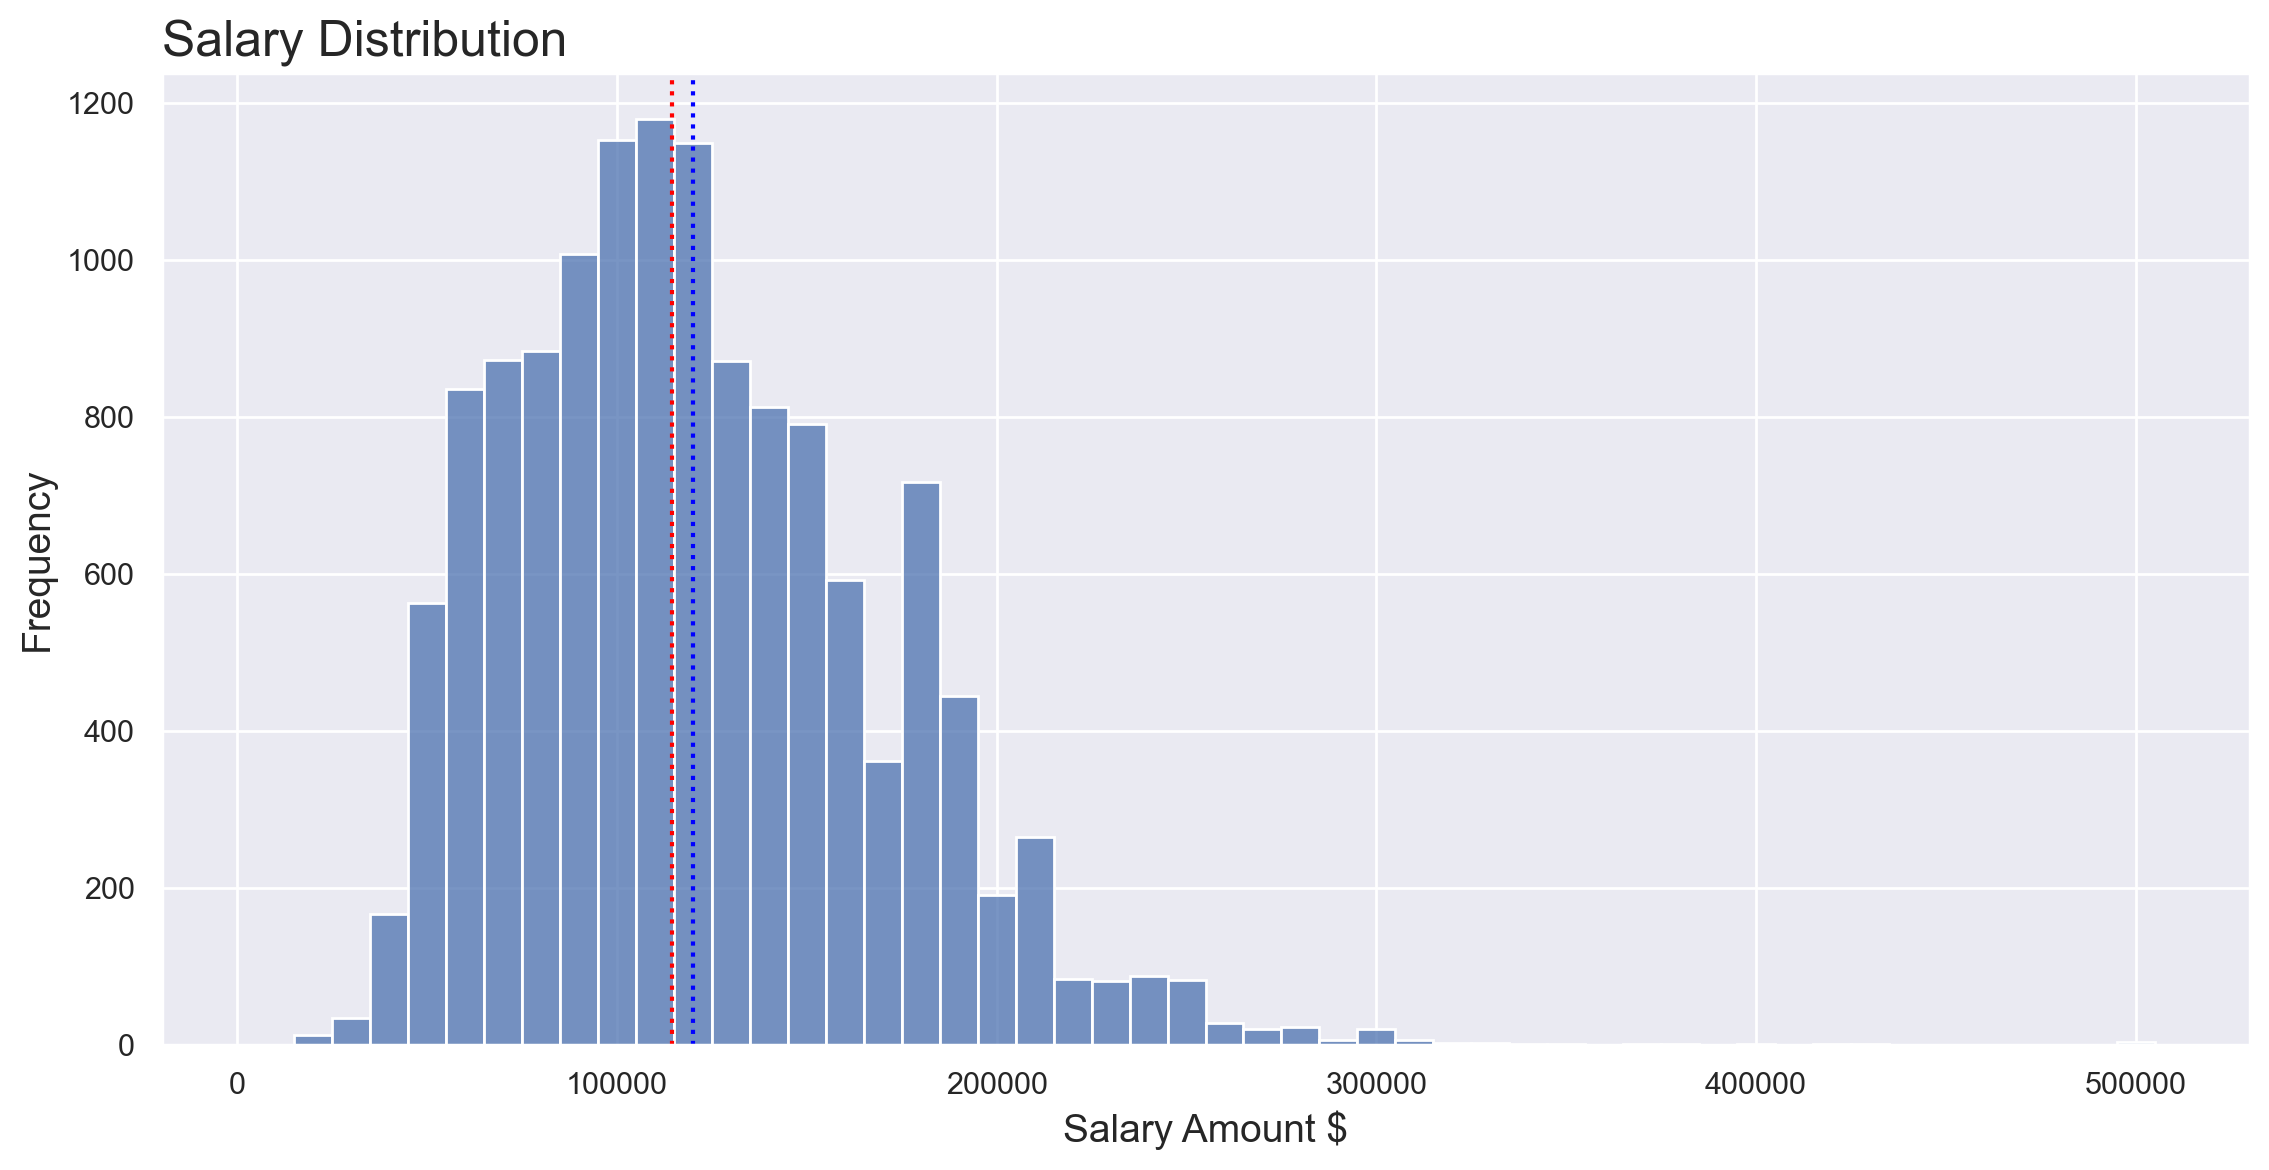

In [74]:
# Plotting the salary distribution
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(df['salary_amount'], bins=50, binrange=(5000, 505000), ax=ax)
ax.set_title('Salary Distribution', loc='left', fontsize=18)
ax.set_xlabel('Salary Amount $', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.axvline(x= df['salary_amount'].mean(), color='blue', linestyle='dotted')
ax.axvline(x= df['salary_amount'].median(), color='red', linestyle='dotted')

plt.show()

The histogram above is about salaries and shows a typical right skewed (or positive) distribution, with a rather short tail towards the largest salary amounts.  
The red line describes the median salary which is equal to \\$114,500, while the blue line is the mean salary which is equal to \\$120,064.  


<br/><br/>

In [75]:
# Calculating the ratio of unique job titles
len(df['job_title'].unique())/len(df)

0.6142215568862276

In [76]:
# Calculating the 50 most common job titles
most_common_jt = df['job_title'].value_counts().sort_values(ascending = False).head(50)

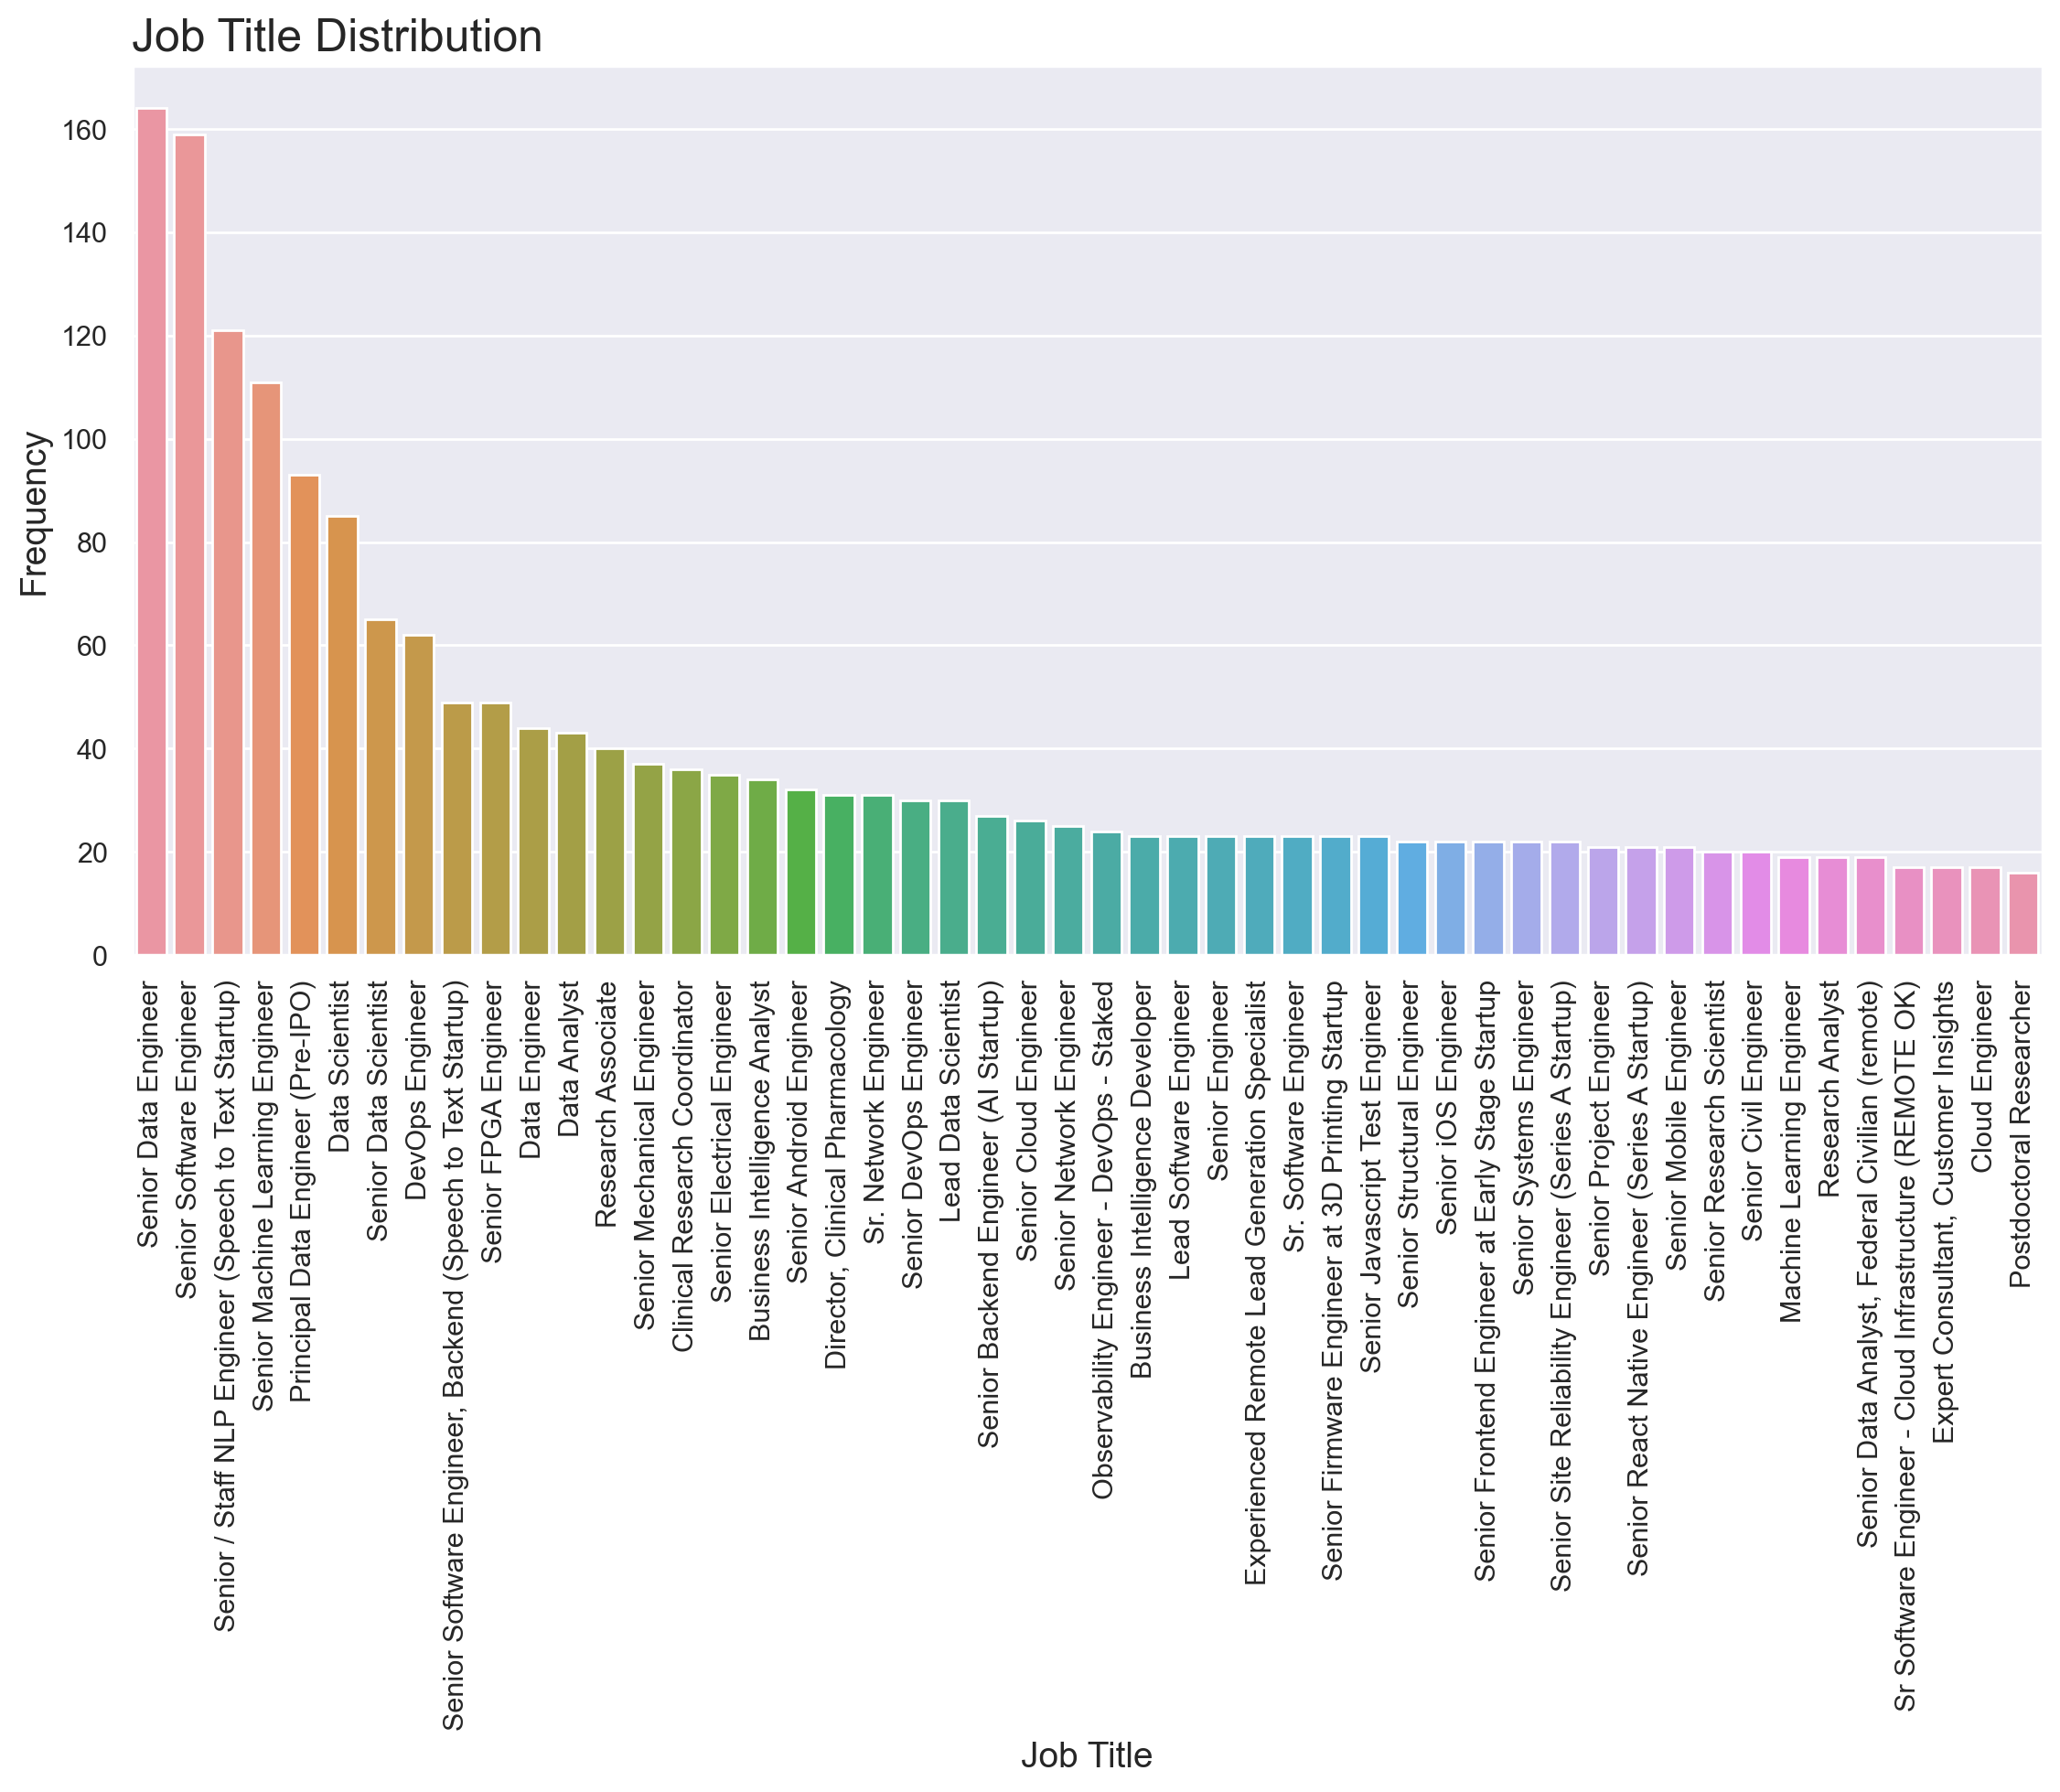

In [77]:
# Plotting the job titles distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = most_common_jt.index, y = most_common_jt.values, ax=ax)
ax.set_title('Job Title Distribution', loc='left', fontsize=18)
ax.set_xlabel('Job Title', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

The most common job titles are **Senior Data Engineer**, **Senior Software Engineer** and **Senior / Staff NLP Engineer (Speech to Text Startup)**, which seems to be a very specific position.  
However, the majority (~61%) of the job titles in the dataset are unique.  

<br/><br/>

In [78]:
# Creating two conditions depending on the job title containing the word 'Senior' or 'Junior'
Senior = [i for i in range(len(df['job_title'])) if 'Senior' in df['job_title'].iloc[i]]
Junior = [i for i in range(len(df['job_title'])) if 'Junior' in df['job_title'].iloc[i]]

print('Number of records')
print('Senior: ', len(Senior))
print('Junior: ', len(Junior))

Number of records
Senior:  4123
Junior:  29


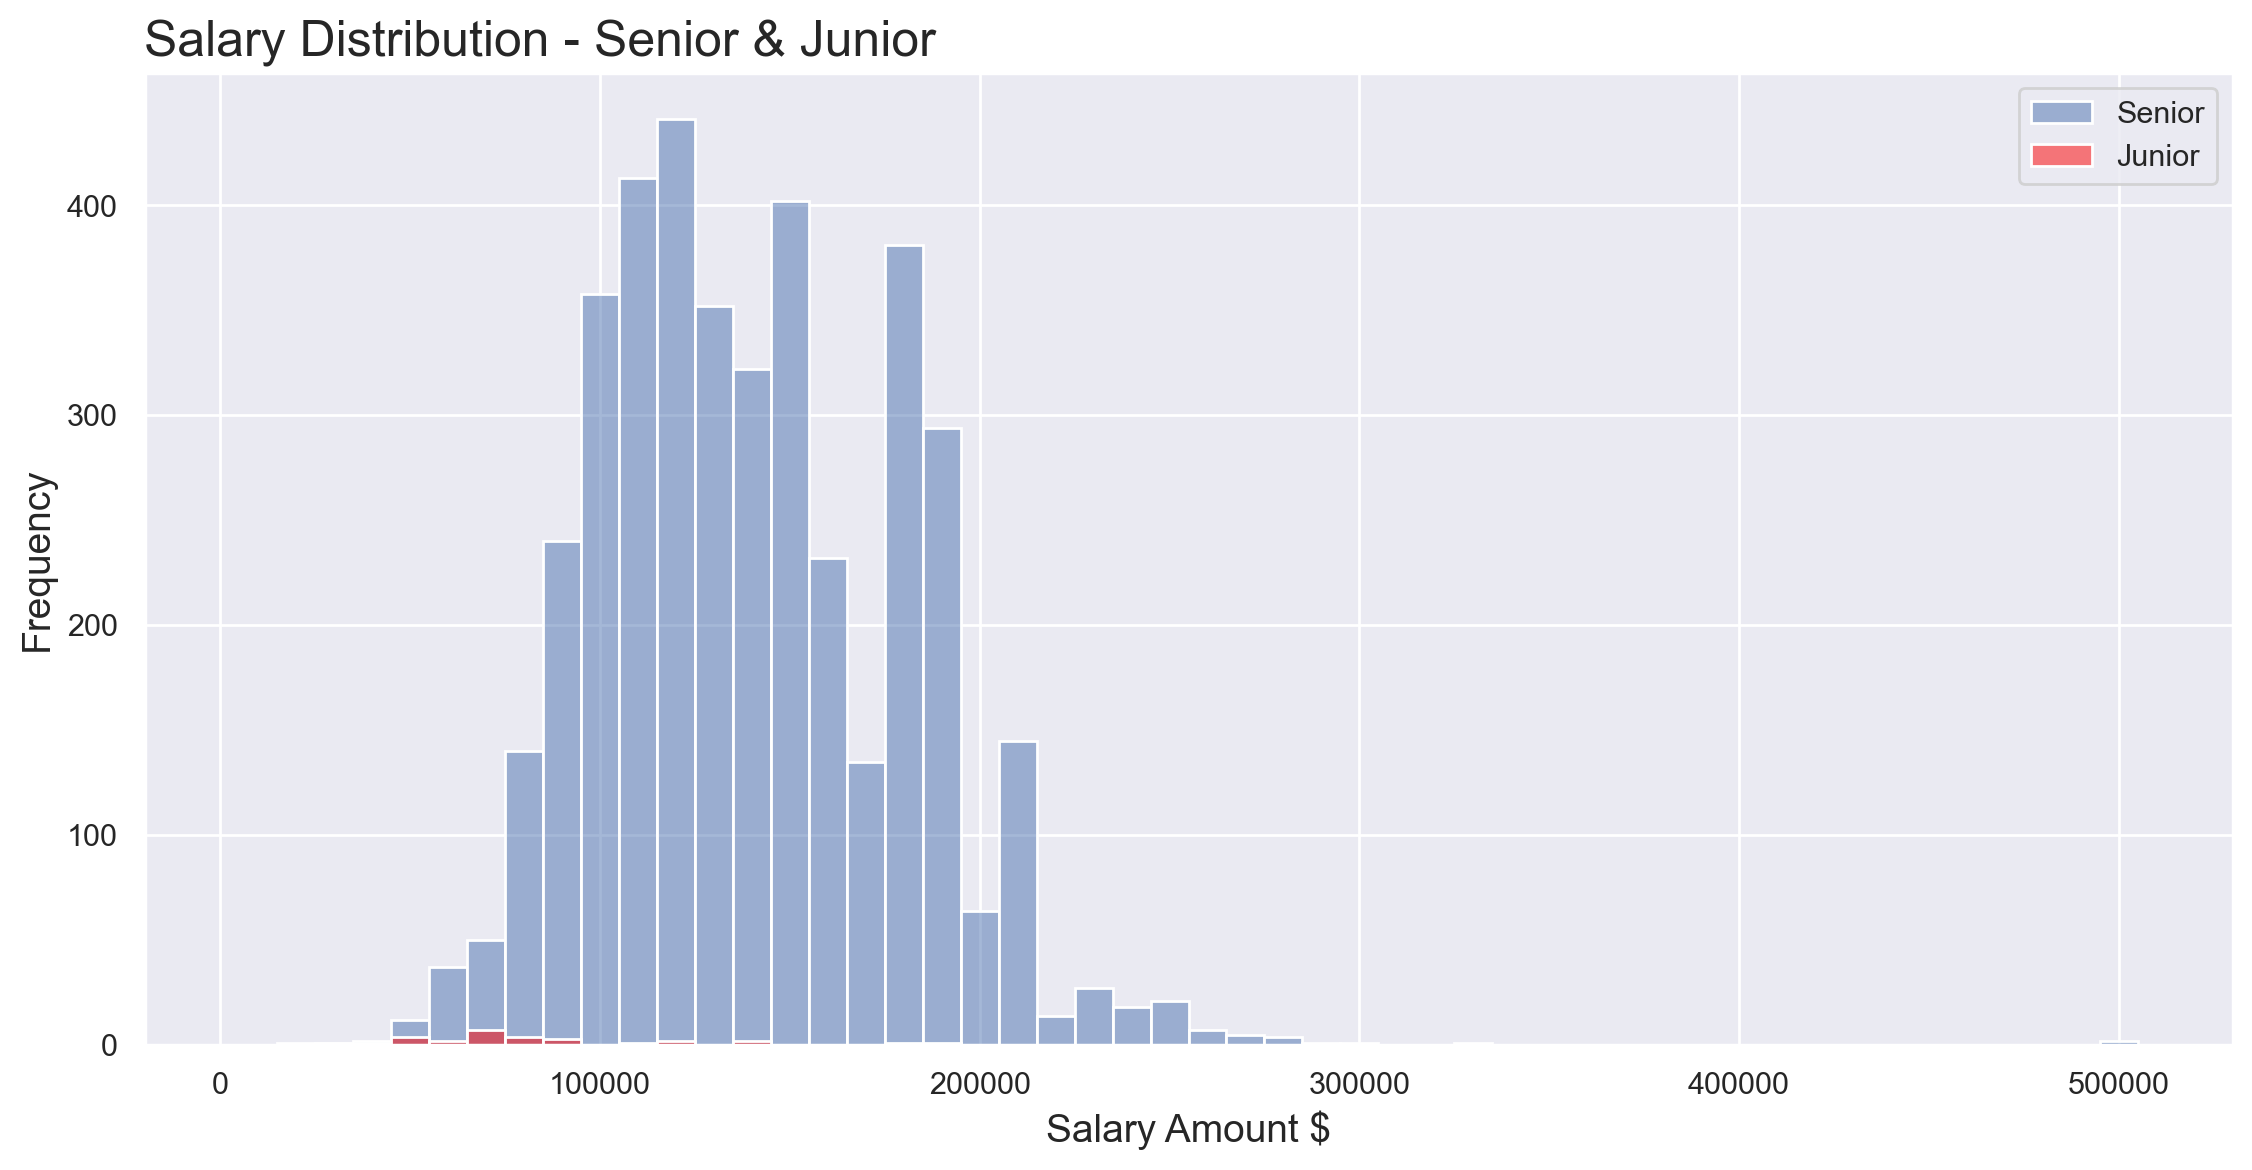

In [79]:
# Plotting the distribution
fig, ax = plt.subplots(figsize = (12,6))

sns.histplot(df['salary_amount'].iloc[Senior], bins=50, binrange=(5000, 505000), alpha=0.5, ax = ax)
sns.histplot(df['salary_amount'].iloc[Junior], bins=50, binrange=(5000, 505000), color='red', alpha=0.5, ax = ax)
ax.set_title('Salary Distribution - Senior & Junior', loc='left', fontsize=18)
ax.set_xlabel('Salary Amount $', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14) 

plt.legend(['Senior','Junior'])
plt.show()

Job postings containing the word **Junior** seems too few.  
To collect more results I am going to use a method that allows abbreviations and is not case sensitive.  

<br/><br/>

In [80]:
# Filtering the dataframe by 'senior' and 'junior' words contained in the job title
senior = df[df['job_title'].astype(str).str.contains('senior|sr|sr.', case=False)]
junior = df[df['job_title'].astype(str).str.contains('junior|jr', case=False)]

print('Number of records')
print('senior:', len(senior))
print('junior:', len(junior))

Number of records
senior: 5244
junior: 57


In [81]:
junior['salary_amount'].median()

60000.0

In [82]:
senior['salary_amount'].median()

130000.0

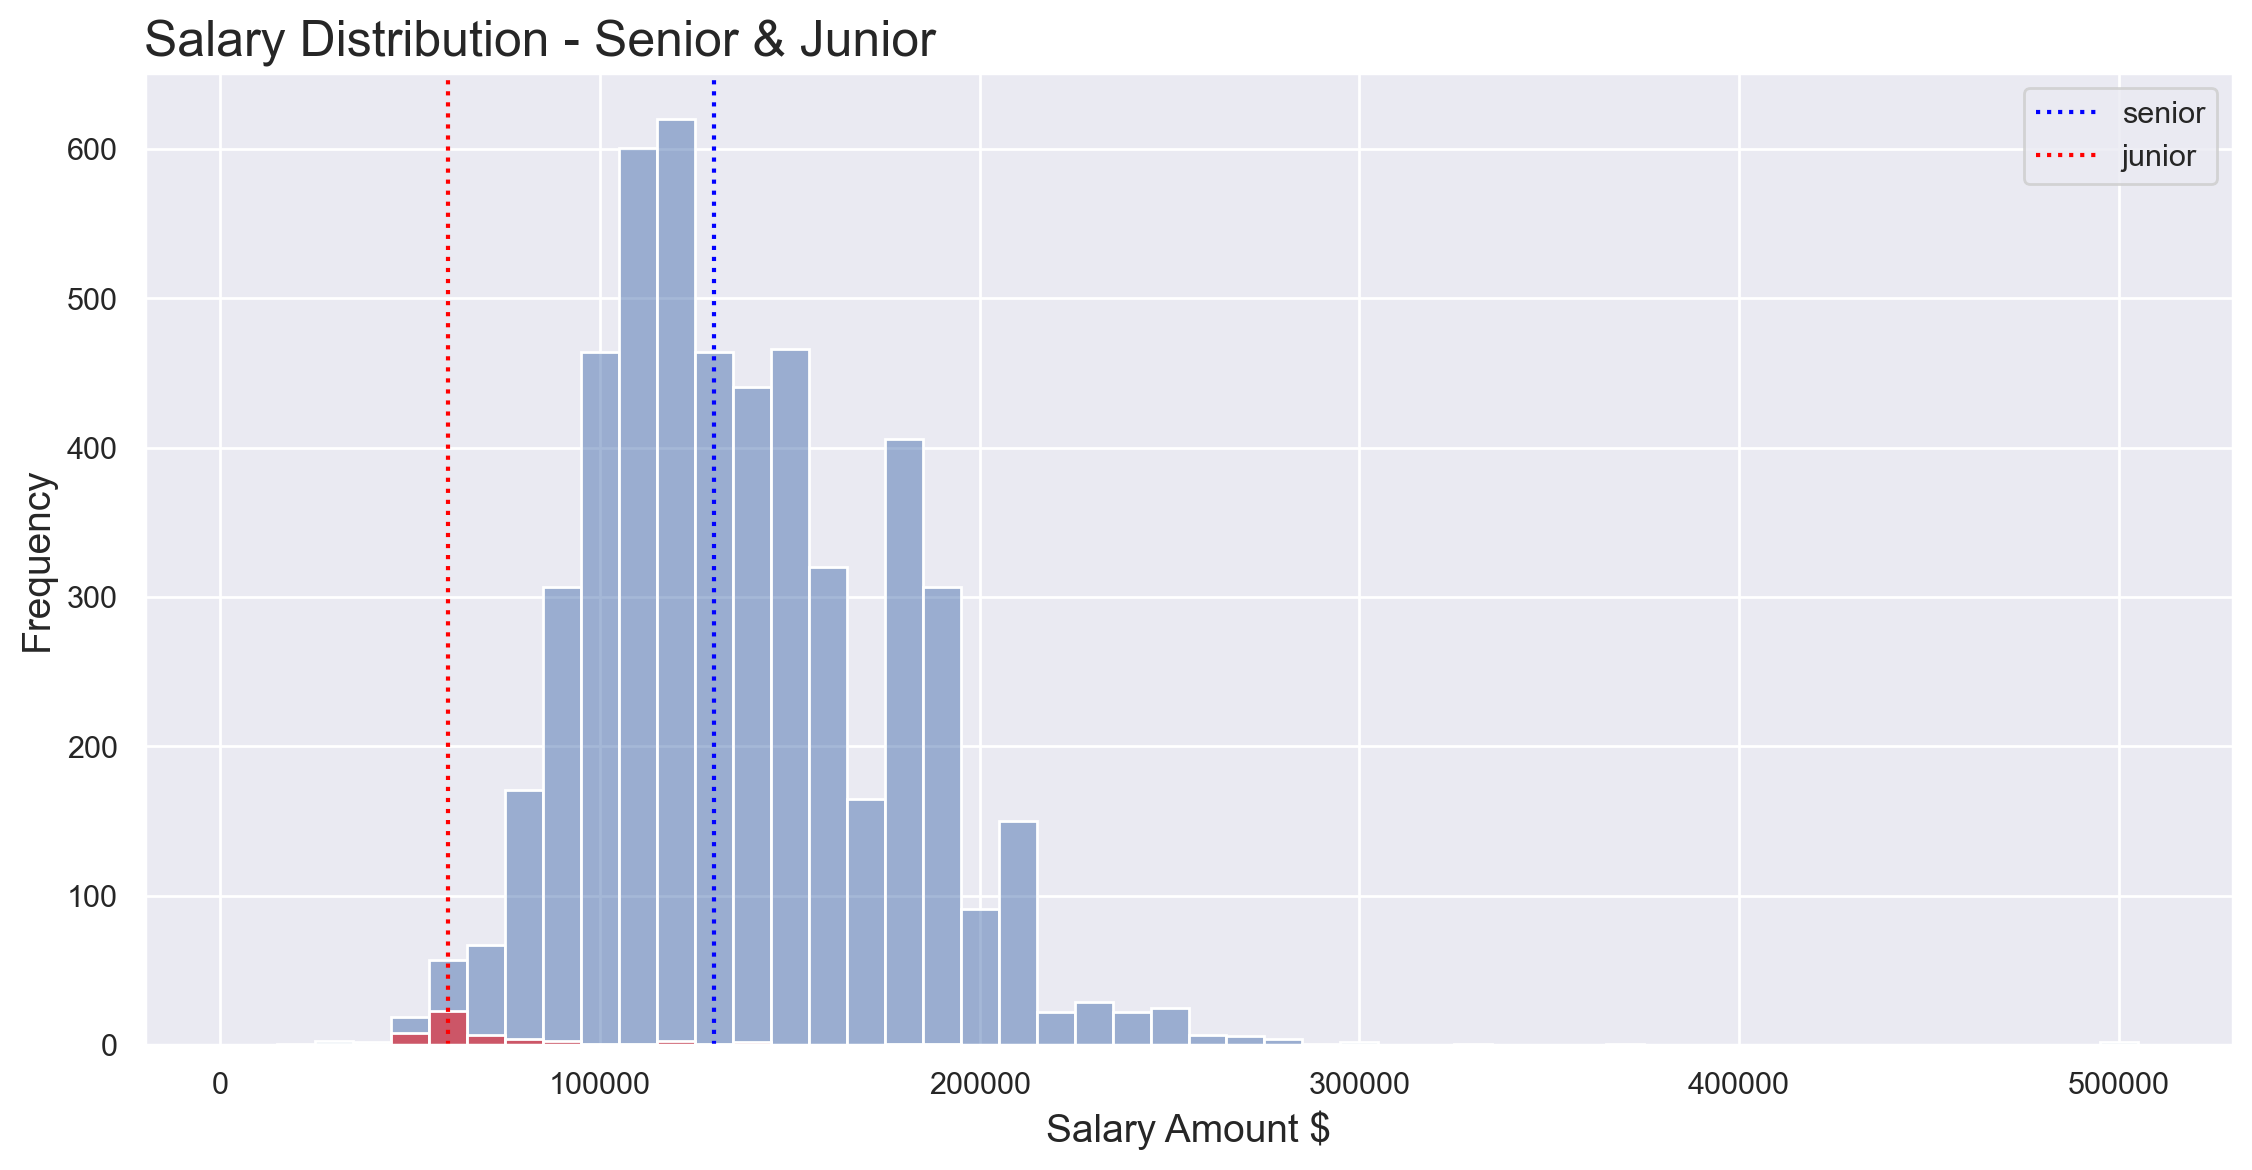

In [83]:
# Plotting the distribution
fig, ax = plt.subplots(figsize = (12,6))

sns.histplot(senior['salary_amount'], bins=50, binrange=(5000, 505000), alpha=0.5, ax = ax)
sns.histplot(junior['salary_amount'], bins=50, binrange=(5000, 505000), color='red', alpha=0.5, ax = ax)
ax.set_title('Salary Distribution - Senior & Junior', loc='left', fontsize=18)
ax.set_xlabel('Salary Amount $', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.axvline(x= senior['salary_amount'].median(), color='blue', linestyle='dotted')
ax.axvline(x= junior['salary_amount'].median(), color='red', linestyle='dotted')

plt.legend(['senior','junior'])
plt.show()

There are many more job postings containing the word **Senior** than those containing the word **Junior** (about 90 times as many).  
As expected, the median salary for senior positions - which is equal to \\$130,000 - is much higher than that for junior positions (equal to \\$60,000).  


<br/><br/>

In [84]:
# Filtering the dataframe by several leadership words contained in the job title
senior = df[df['job_title'].astype(str).str.contains('senior|sr|sr.', case=False)]
principal = df[df['job_title'].astype(str).str.contains('principal', case=False)]
president = df[df['job_title'].astype(str).str.contains('president', case=False)]
director = df[df['job_title'].astype(str).str.contains('director', case=False)]
manager = df[df['job_title'].astype(str).str.contains('manager', case=False)]
leader = df[df['job_title'].astype(str).str.contains('leader|lead', case=False)]
head = df[df['job_title'].astype(str).str.contains('head', case=False)]
chief = df[df['job_title'].astype(str).str.contains('chief', case=False)]

print('Number of records')
print('senior:   ', len(senior))
print('principal:', len(principal))
print('president:', len(president))
print('director: ', len(director))
print('manager:  ', len(manager))
print('leader:   ', len(leader))
print('head:     ', len(head))
print('chief:    ', len(chief))

Number of records
senior:    5244
principal: 435
president: 79
director:  678
manager:   1225
leader:    507
head:      37
chief:     58


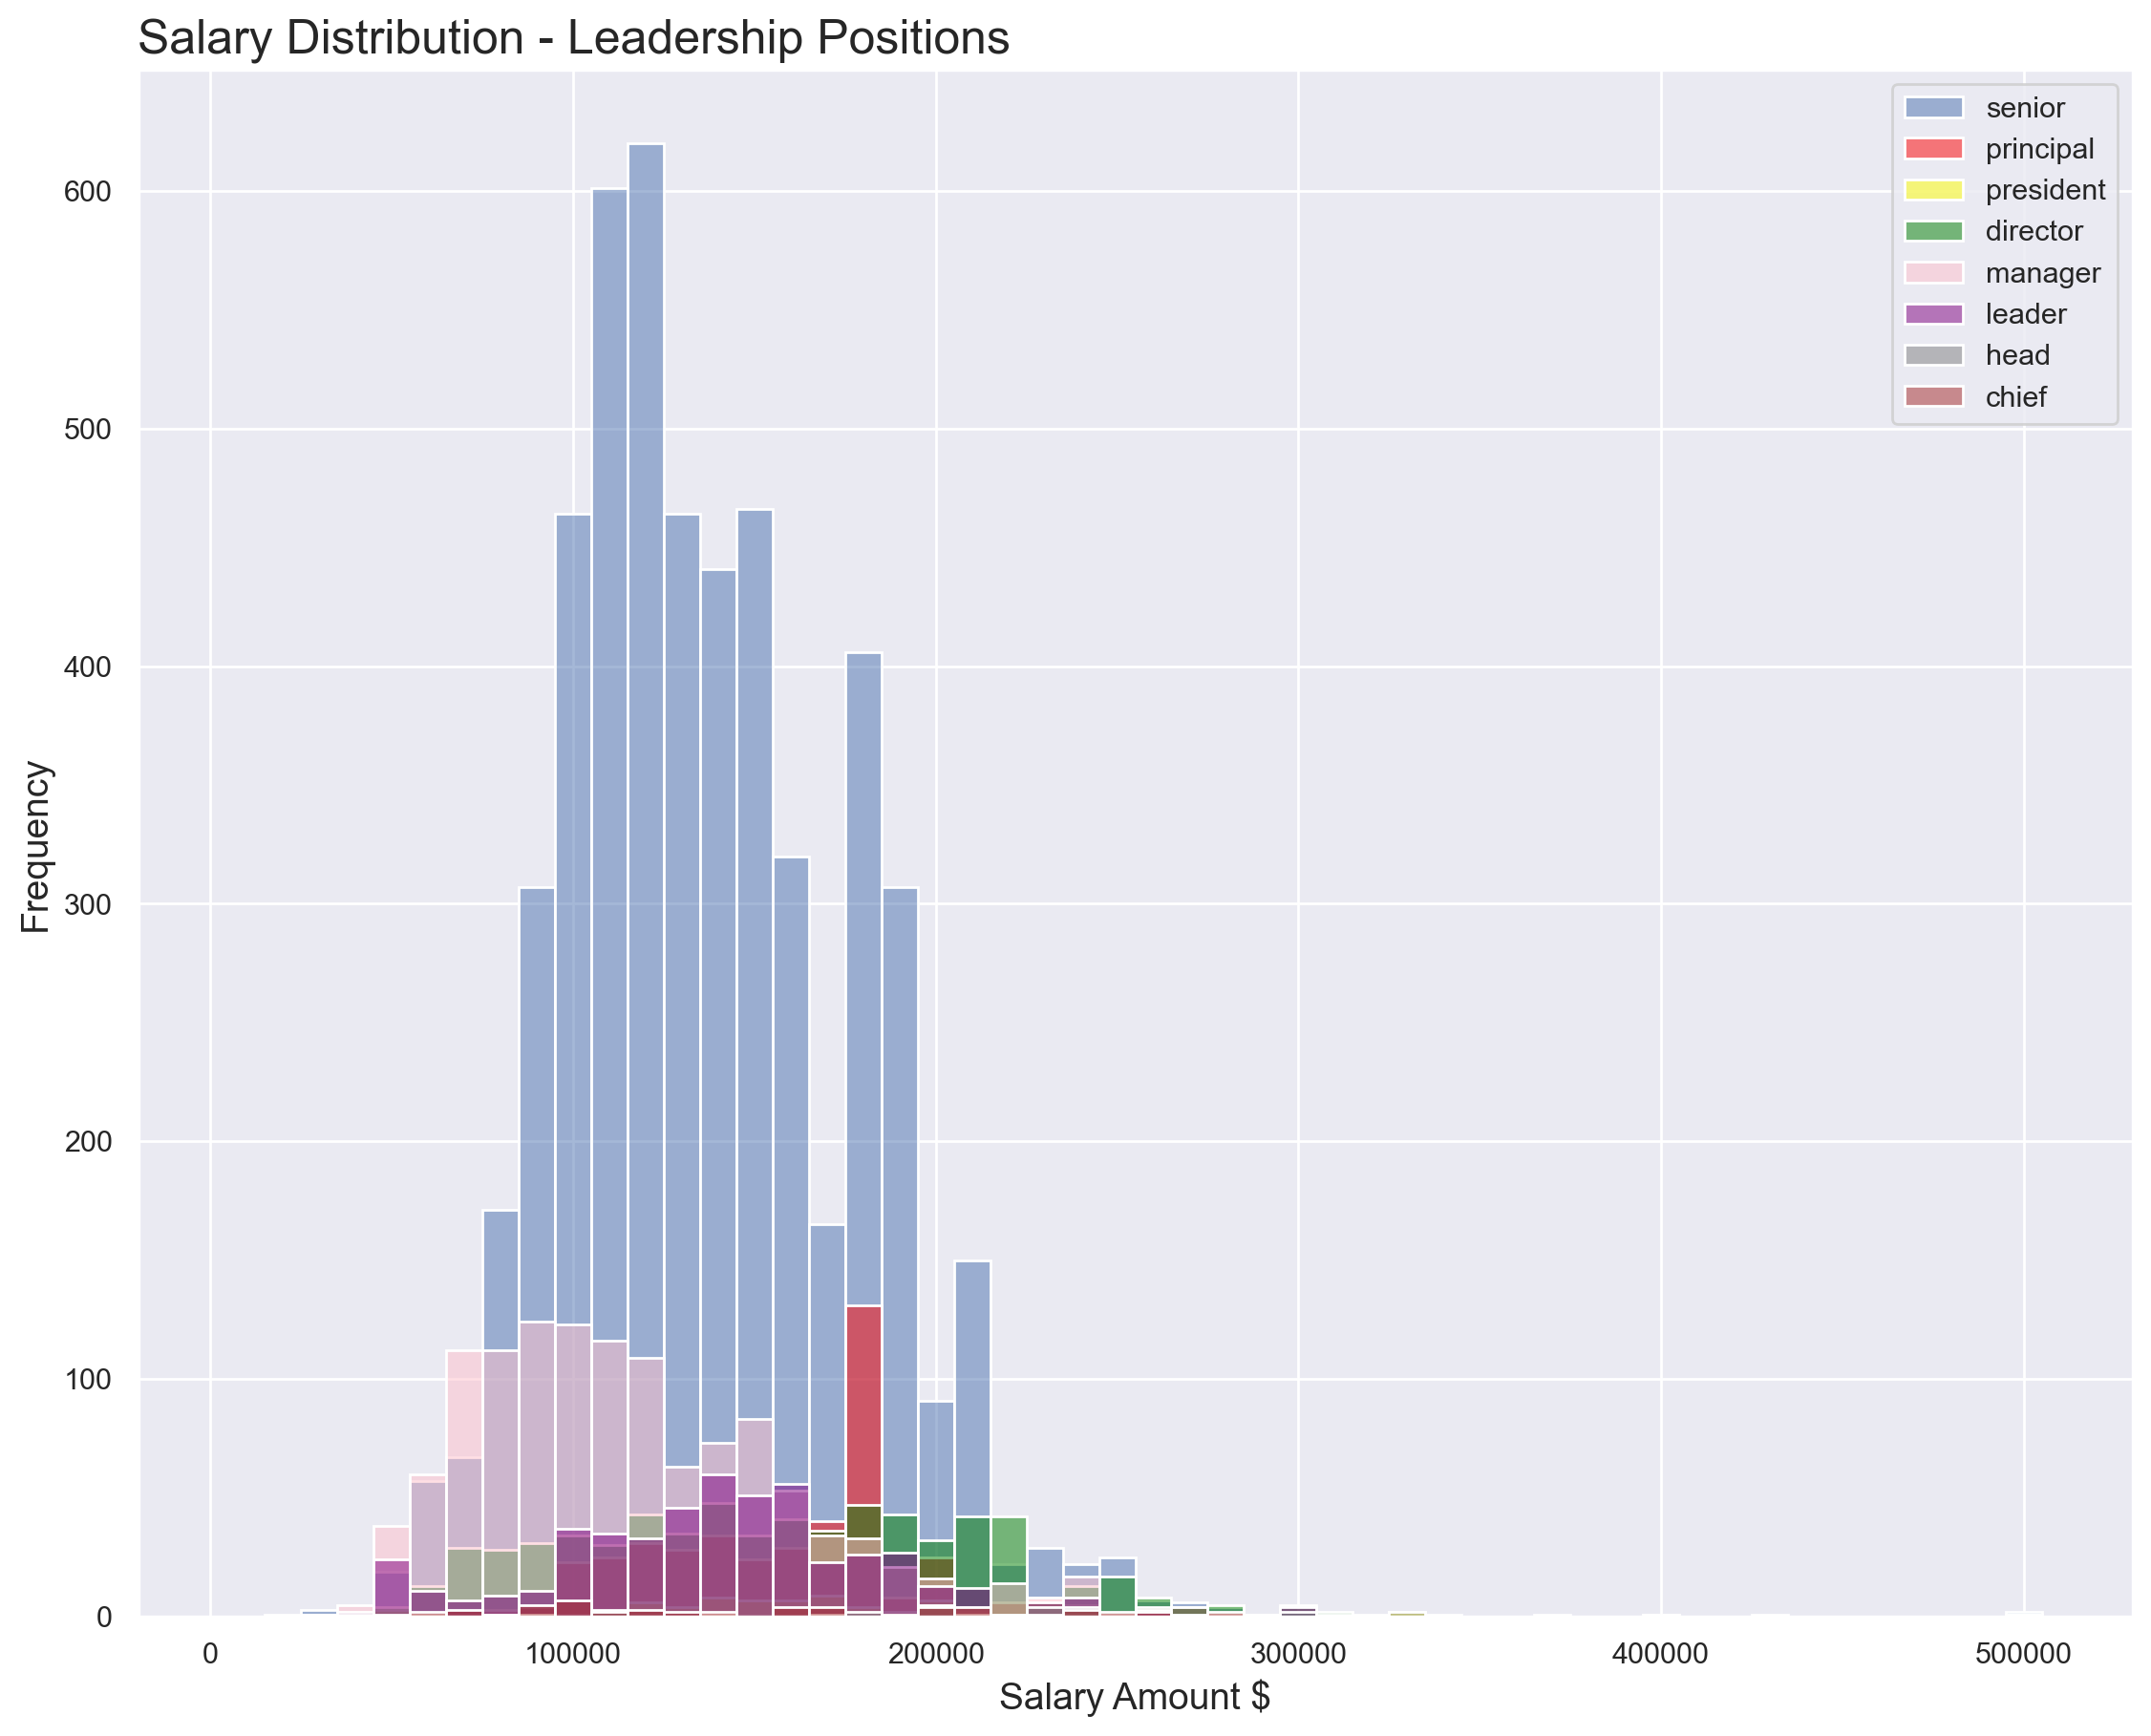

In [85]:
# Plotting the distribution
fig, ax = plt.subplots(figsize = (12,10))

sns.histplot(senior['salary_amount'], bins=50, binrange=(5000, 505000), alpha=0.5, ax = ax)
sns.histplot(principal['salary_amount'], bins=50, binrange=(5000, 505000), color='red', alpha=0.5, ax = ax)
sns.histplot(president['salary_amount'], bins=50, binrange=(5000, 505000), color='yellow', alpha=0.5, ax = ax)
sns.histplot(director['salary_amount'], bins=50, binrange=(5000, 505000), color='green', alpha=0.5, ax = ax)
sns.histplot(manager['salary_amount'], bins=50, binrange=(5000, 505000), color='pink', alpha=0.5, ax = ax)
sns.histplot(leader['salary_amount'], bins=50, binrange=(5000, 505000), color='purple', alpha=0.5, ax = ax)
sns.histplot(head['salary_amount'], bins=50, binrange=(5000, 505000), color='grey', alpha=0.5, ax = ax)
sns.histplot(chief['salary_amount'], bins=50, binrange=(5000, 505000), color='brown', alpha=0.5, ax = ax)

ax.set_title('Salary Distribution - Leadership Positions', loc='left', fontsize=18)
ax.set_xlabel('Salary Amount $', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.legend(['senior','principal','president','director','manager','leader','head','chief'])
plt.show()

The histogram above shows all the distributions at the same scale and is useful for comparing areas, but is difficult to read due to the amount of information.  
However, job titles containing the words **senior** or **manager** are the vast majority, while those containing **head** and **chief** are quite rare.    

<br/><br/>

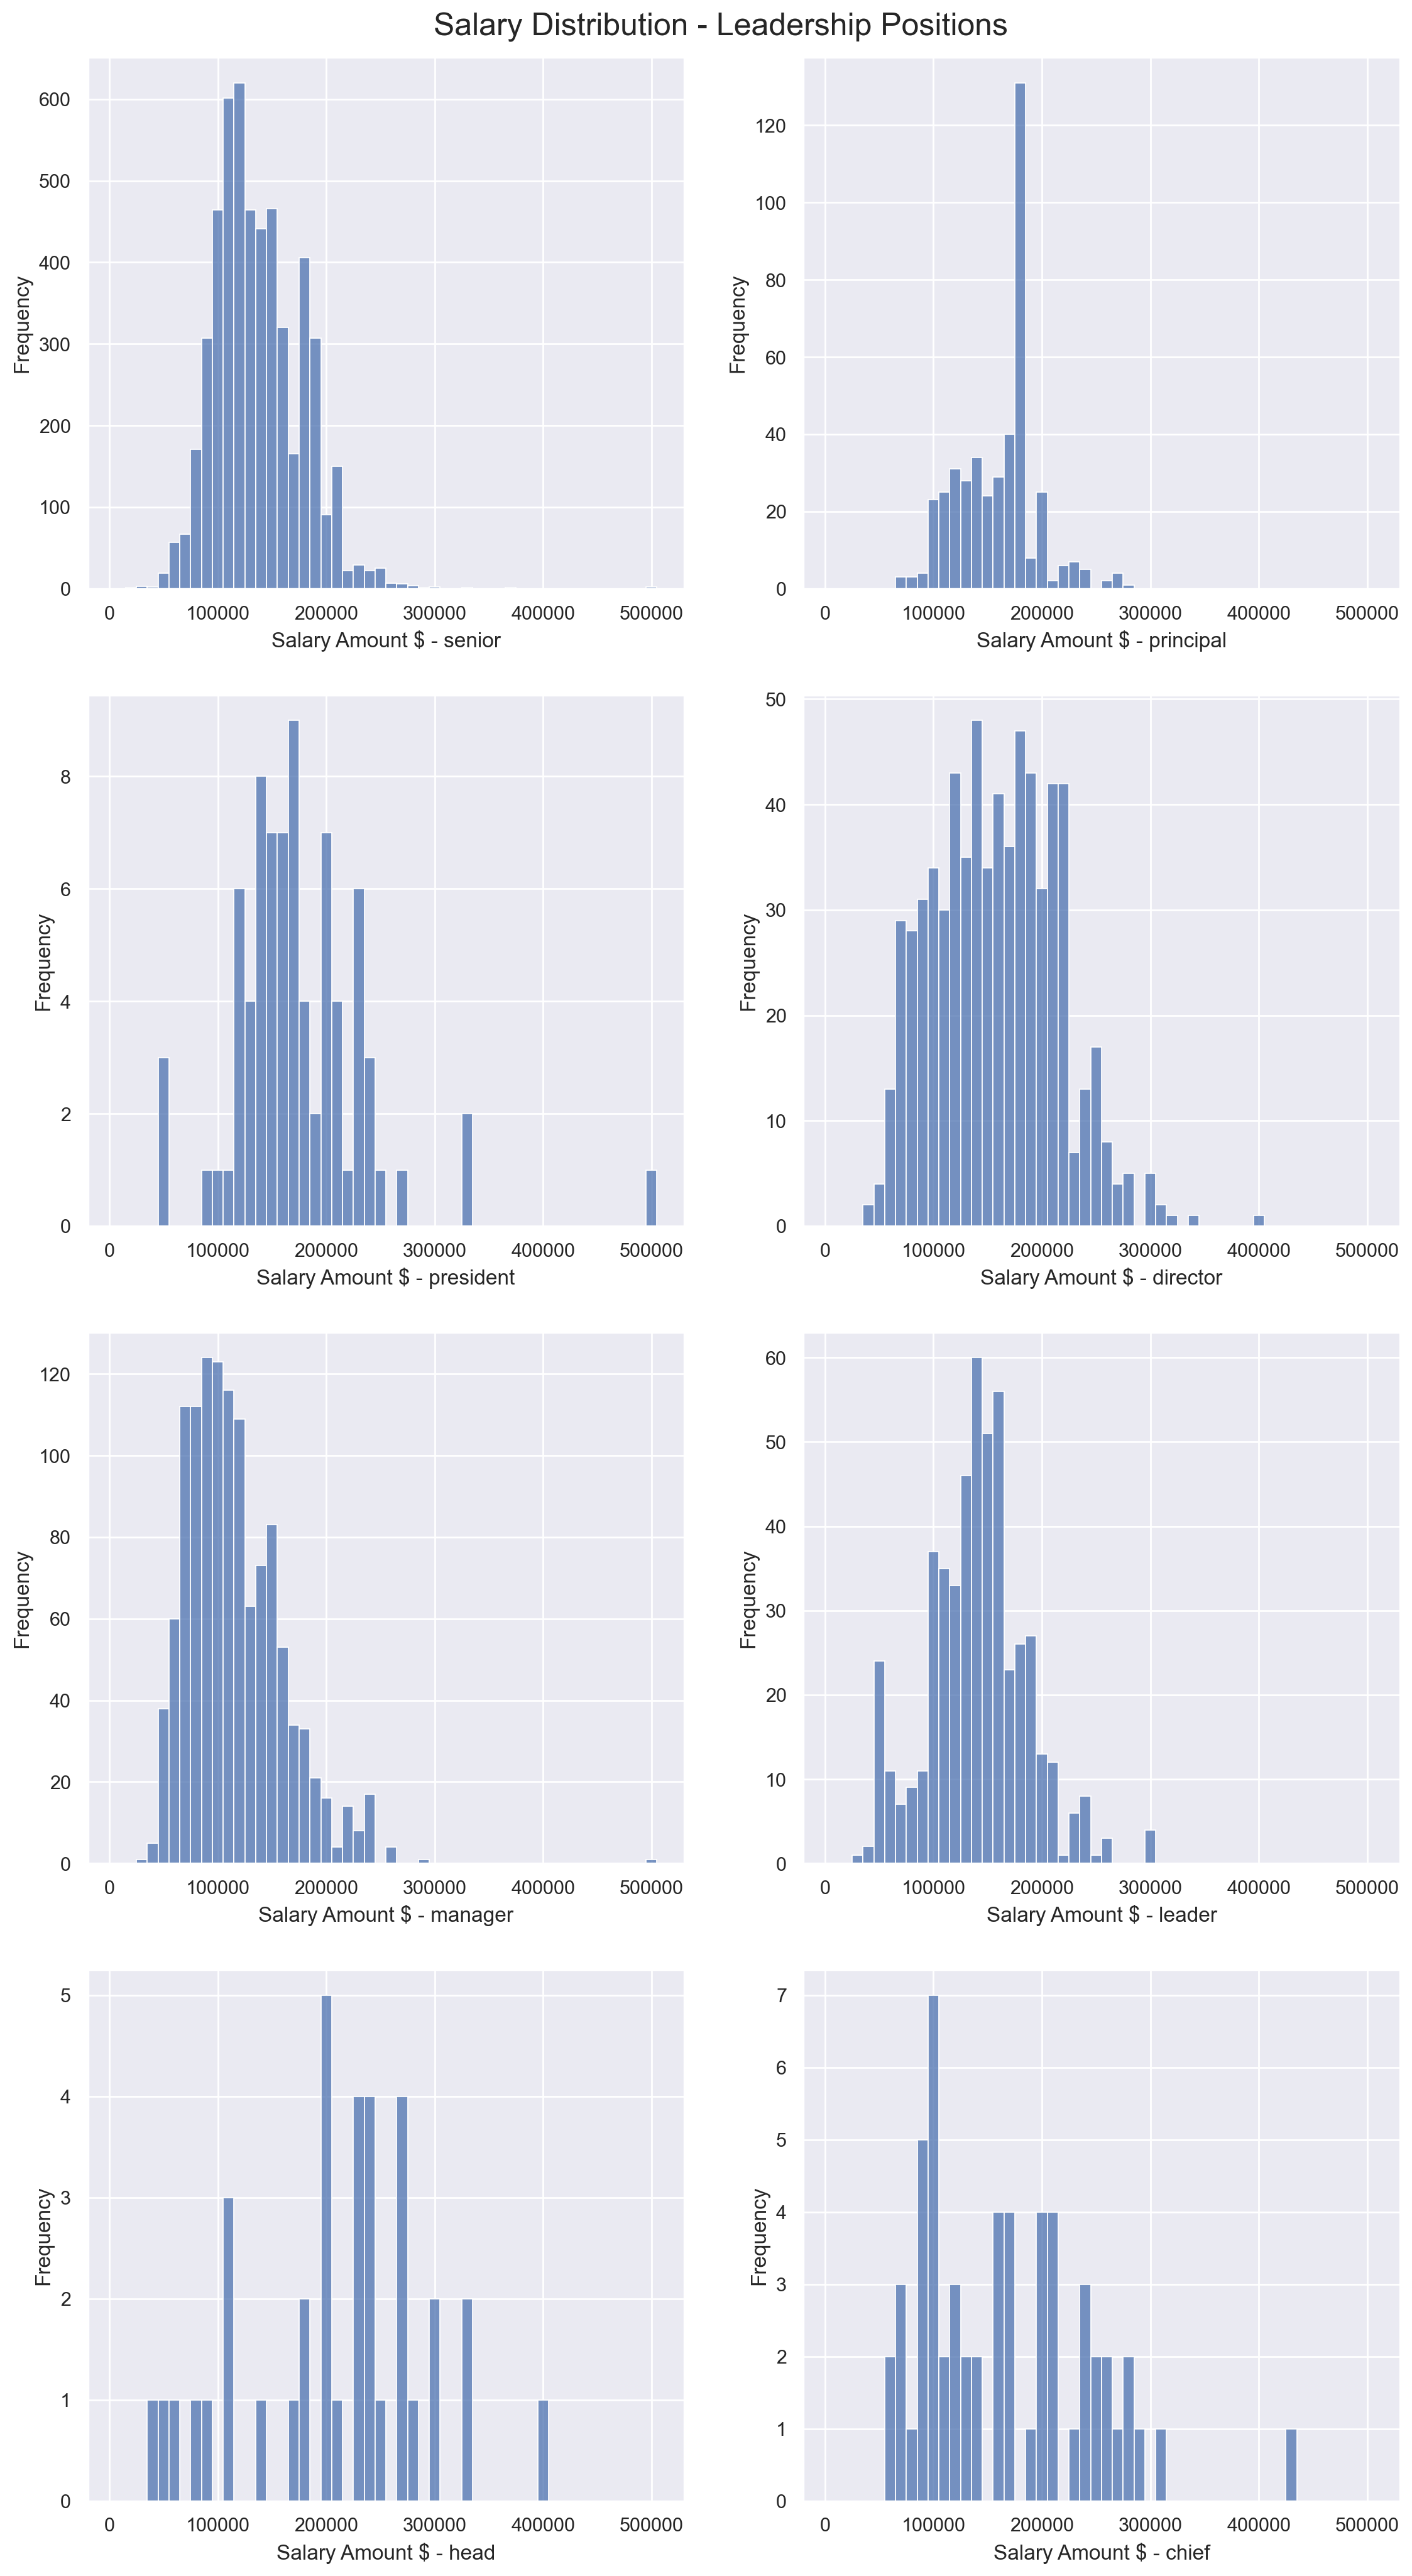

In [86]:
# Plotting the distributions separately
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize = (12,24))

senior_roles = [senior, principal, president, director, manager, leader, head, chief]
senior_names = ['senior', 'principal', 'president', 'director', 'manager', 'leader', 'head', 'chief']
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

plt.suptitle('Salary Distribution - Leadership Positions', y=0.895, fontsize=18)

for x in range(len(senior_roles)):
    sns.histplot(senior_roles[x]['salary_amount'], bins=50, binrange=(5000, 505000), ax = axes[x])
    axes[x].set_xlabel(f'Salary Amount $ - {senior_names[x]}', fontsize = 12)
    axes[x].set_ylabel('Frequency', fontsize = 12)
    # axes[x].set_yticks(np.arange(0, 750, step=100)) 

These histograms can be misleading due to the difference in scale along the vertical dimension, so their areas are not comparable.  
Job titles containing the words **senior** or **manager** show similar patterns, those containing **director** seem the most evenly distributed, and those containing **head** and **chief** are quite discontinuous (because of their low records).  

<br/><br/>

In [87]:
# Creating a dataframe containing some summary statistics about leadership positions
senior_df = pd.DataFrame({'count' : [senior.shape[0],
                                     principal.shape[0],
                                     president.shape[0],
                                     director.shape[0],
                                     manager.shape[0],
                                     leader.shape[0],
                                     head.shape[0],
                                     chief.shape[0]],
                          'mean_salary' : [round(senior['salary_amount'].mean(), 1), 
                                           round(principal['salary_amount'].mean(), 1), 
                                           round(president['salary_amount'].mean(), 1), 
                                           round(director['salary_amount'].mean(), 1), 
                                           round(manager['salary_amount'].mean(), 1), 
                                           round(leader['salary_amount'].mean(), 1),
                                           round(head['salary_amount'].mean(), 1),
                                           round(chief['salary_amount'].mean(), 1)],
                          'median_salary' : [senior['salary_amount'].median(), 
                                             principal['salary_amount'].median(), 
                                             president['salary_amount'].median(), 
                                             director['salary_amount'].median(), 
                                             manager['salary_amount'].median(), 
                                             leader['salary_amount'].median(),
                                             head['salary_amount'].median(),
                                             chief['salary_amount'].median()],
                          'minimum_salary' : [senior['salary_amount'].min(), 
                                              principal['salary_amount'].min(), 
                                              president['salary_amount'].min(), 
                                              director['salary_amount'].min(), 
                                              manager['salary_amount'].min(), 
                                              leader['salary_amount'].min(),
                                              head['salary_amount'].min(),
                                              chief['salary_amount'].min()],
                          'maximum_salary' : [senior['salary_amount'].max(), 
                                              principal['salary_amount'].max(), 
                                              president['salary_amount'].max(), 
                                              director['salary_amount'].max(), 
                                              manager['salary_amount'].max(), 
                                              leader['salary_amount'].max(),
                                              head['salary_amount'].max(),
                                              chief['salary_amount'].max()]}, 
                          index = senior_names)

senior_df.sort_values(by = 'mean_salary', ascending = False)

,count,mean_salary,median_salary,minimum_salary,maximum_salary
head,37,206518.6,225000.0,42696.0,400000.0
president,79,174988.9,165000.0,54300.0,500000.0
chief,58,166612.9,162500.0,63435.0,425000.0
principal,435,158429.1,168500.0,67777.0,280000.0
director,678,156567.8,156625.0,37500.0,400000.0
leader,507,139606.7,137100.0,30712.5,297850.0
senior,5244,136308.2,130000.0,20000.0,500000.0
manager,1225,115078.8,107500.0,30810.0,500000.0


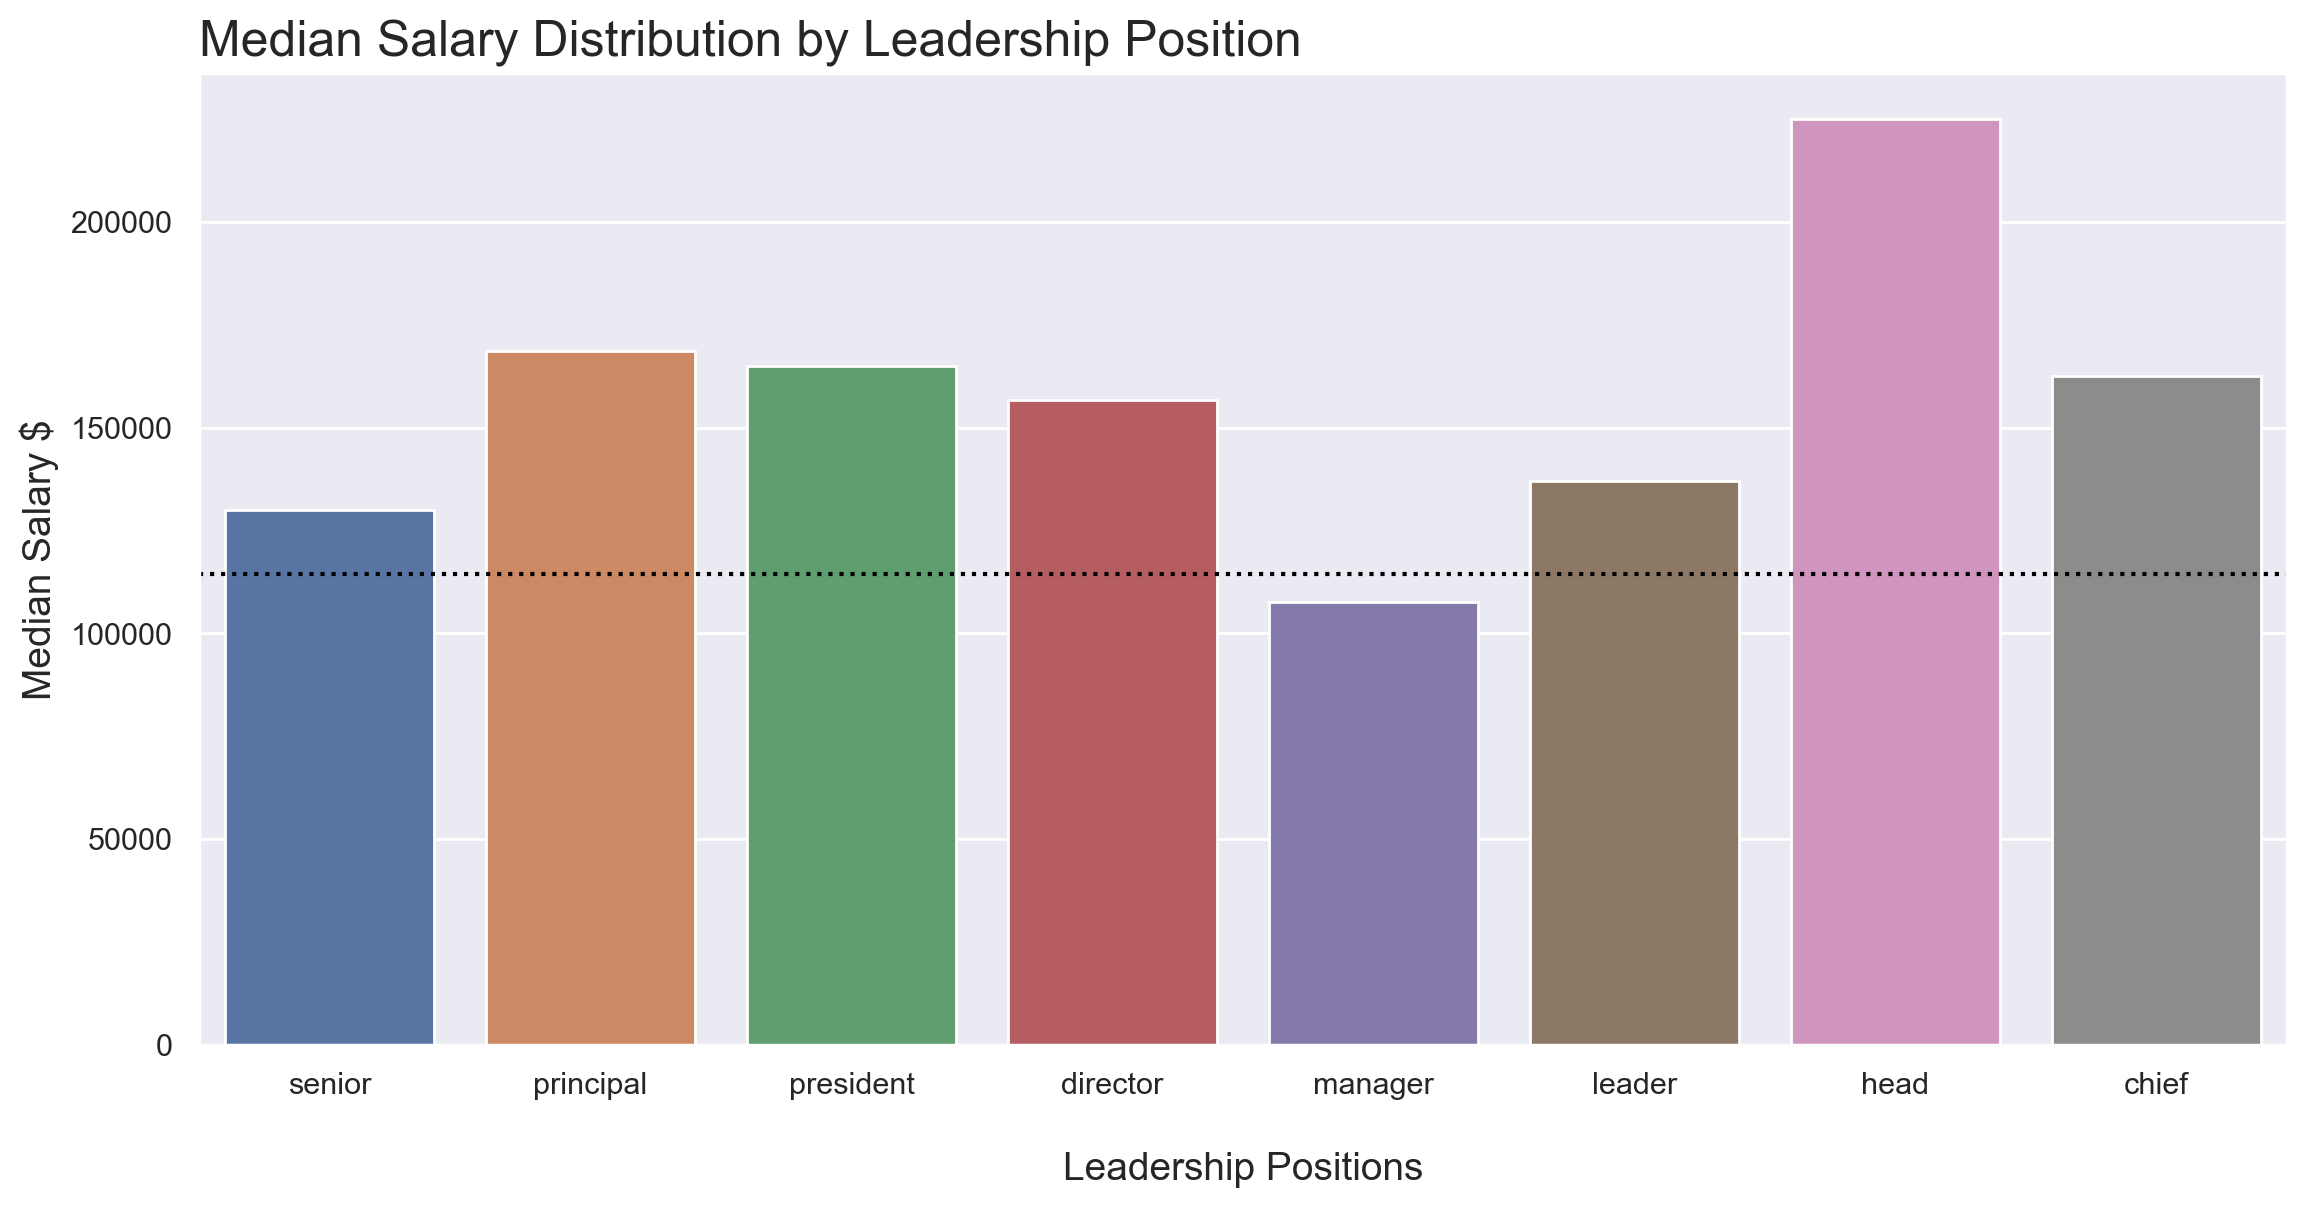

In [88]:
# Plotting the median salary distribution by leadership position
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 0)
sns.barplot(x = senior_df.index, y = senior_df.median_salary.values, ax = ax)
ax.set_title('Median Salary Distribution by Leadership Position', loc='left', fontsize=18)
ax.set_xlabel('\nLeadership Positions', fontsize = 14)
ax.set_ylabel('Median Salary $', fontsize = 14)
ax.axhline(y= df['salary_amount'].median(), color='black', linestyle='dotted')

plt.show()

Leadership positions with the highest median salary (equal to \\$225,000) are those containing the word **head**, which are also the rarest.  
Those containing the words **principal**, **president** and **chief** rank below with similar values, while those related to **manager** show the lowest median salary (equal to \\$107,500) which is less than the median salary for all roles.  
The black dotted line represents the median salary for all roles in the main dataset, which is equal to \\$114,500.  


<br/><br/>

In [89]:
# Calculating the ratio of unique company names
len(df['company_name'].value_counts())/len(df)

0.305688622754491

In [90]:
# Calculating the number of companies with 10 or more listings
np.sum(df['company_name'].value_counts()>=10)

200

In [91]:
# Calculating the number of companies with 25 or more listings
np.sum(df['company_name'].value_counts()>=25)

61

In [92]:
# Calculating the number of companies with 50 or more listings
np.sum(df['company_name'].value_counts()>=50)

22

In [93]:
# Calculating the 50 companies with the most job listings
most_common_cn = df['company_name'].value_counts().sort_values(ascending = False).head(50)

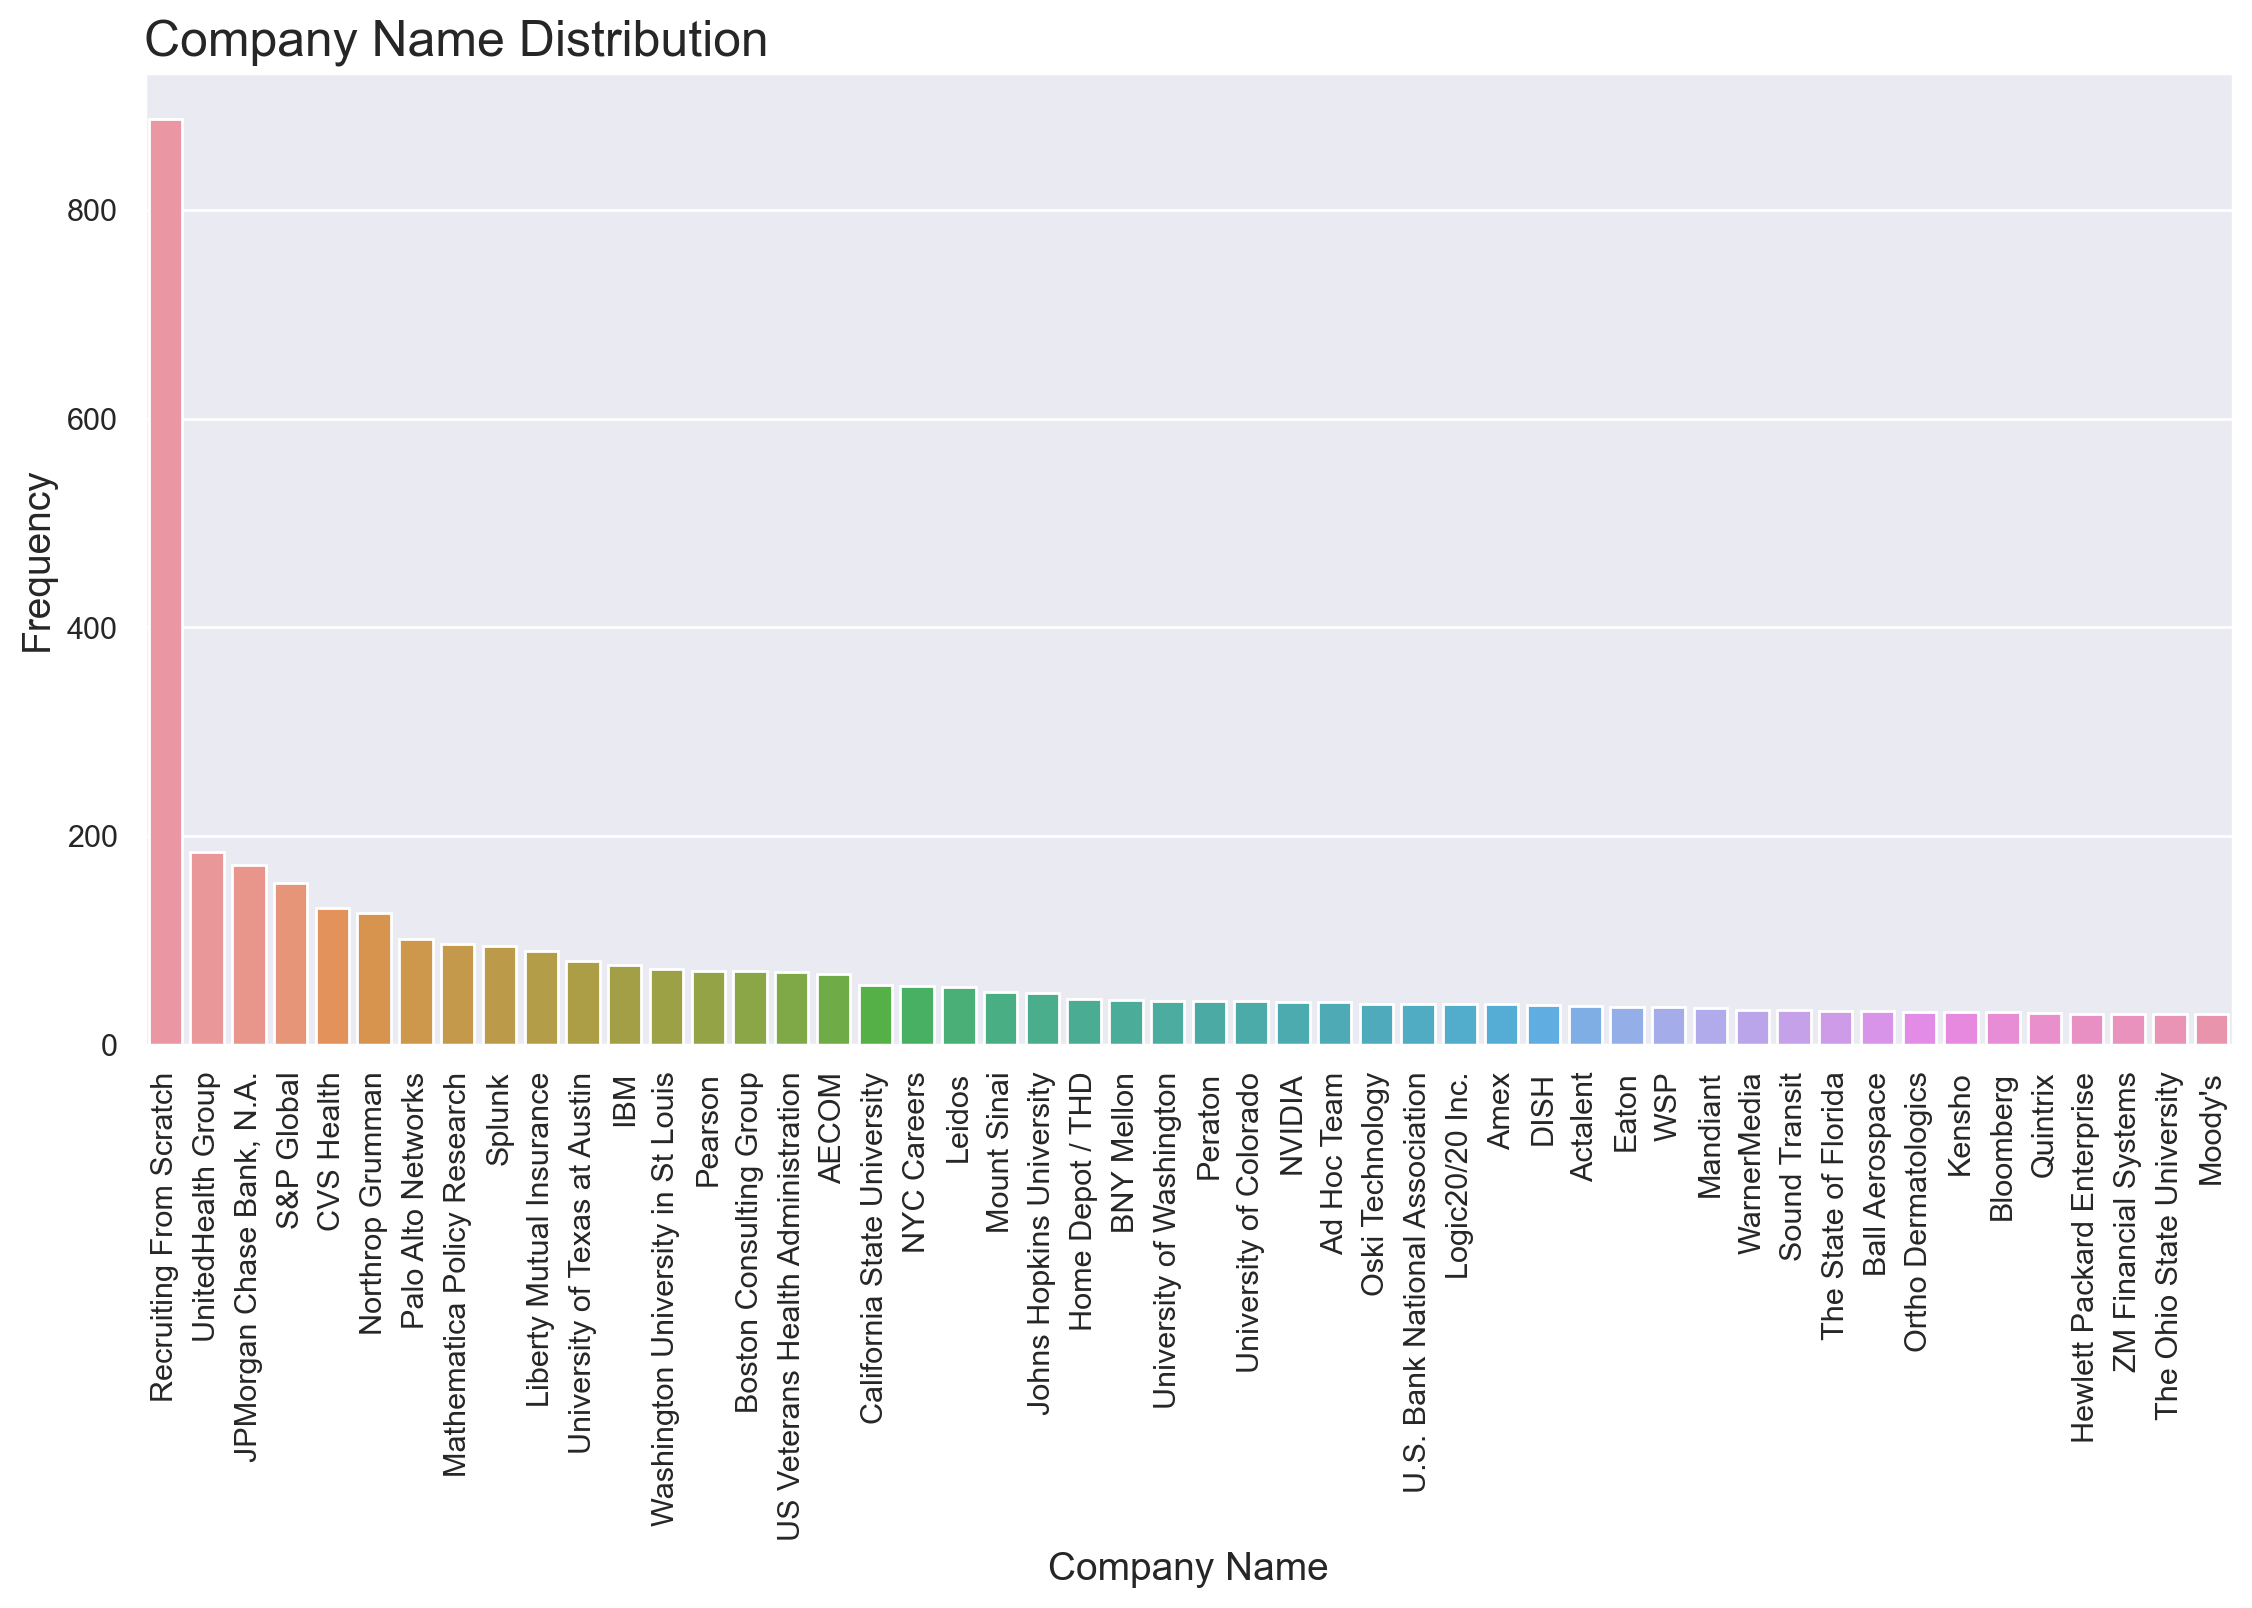

In [94]:
# Plotting the companies distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = most_common_cn.index, y = most_common_cn.values, ax=ax)
ax.set_title('Company Name Distribution', loc='left', fontsize=18)
ax.set_xlabel('Company Name', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

The companies with the most job listings are **Recruiting From Scratch** (a recruitment agency), **UnitedHealth Group** (a healthcare and insurance company) and **JPMorgan Chase Bank** (a major financial services firm): Recruiting From Scratch is clearly an outlier.  
Approximately one third (~31%) of the company names in the dataset are unique, and only 61 companies have 25 or more job listings.  

<br/><br/>

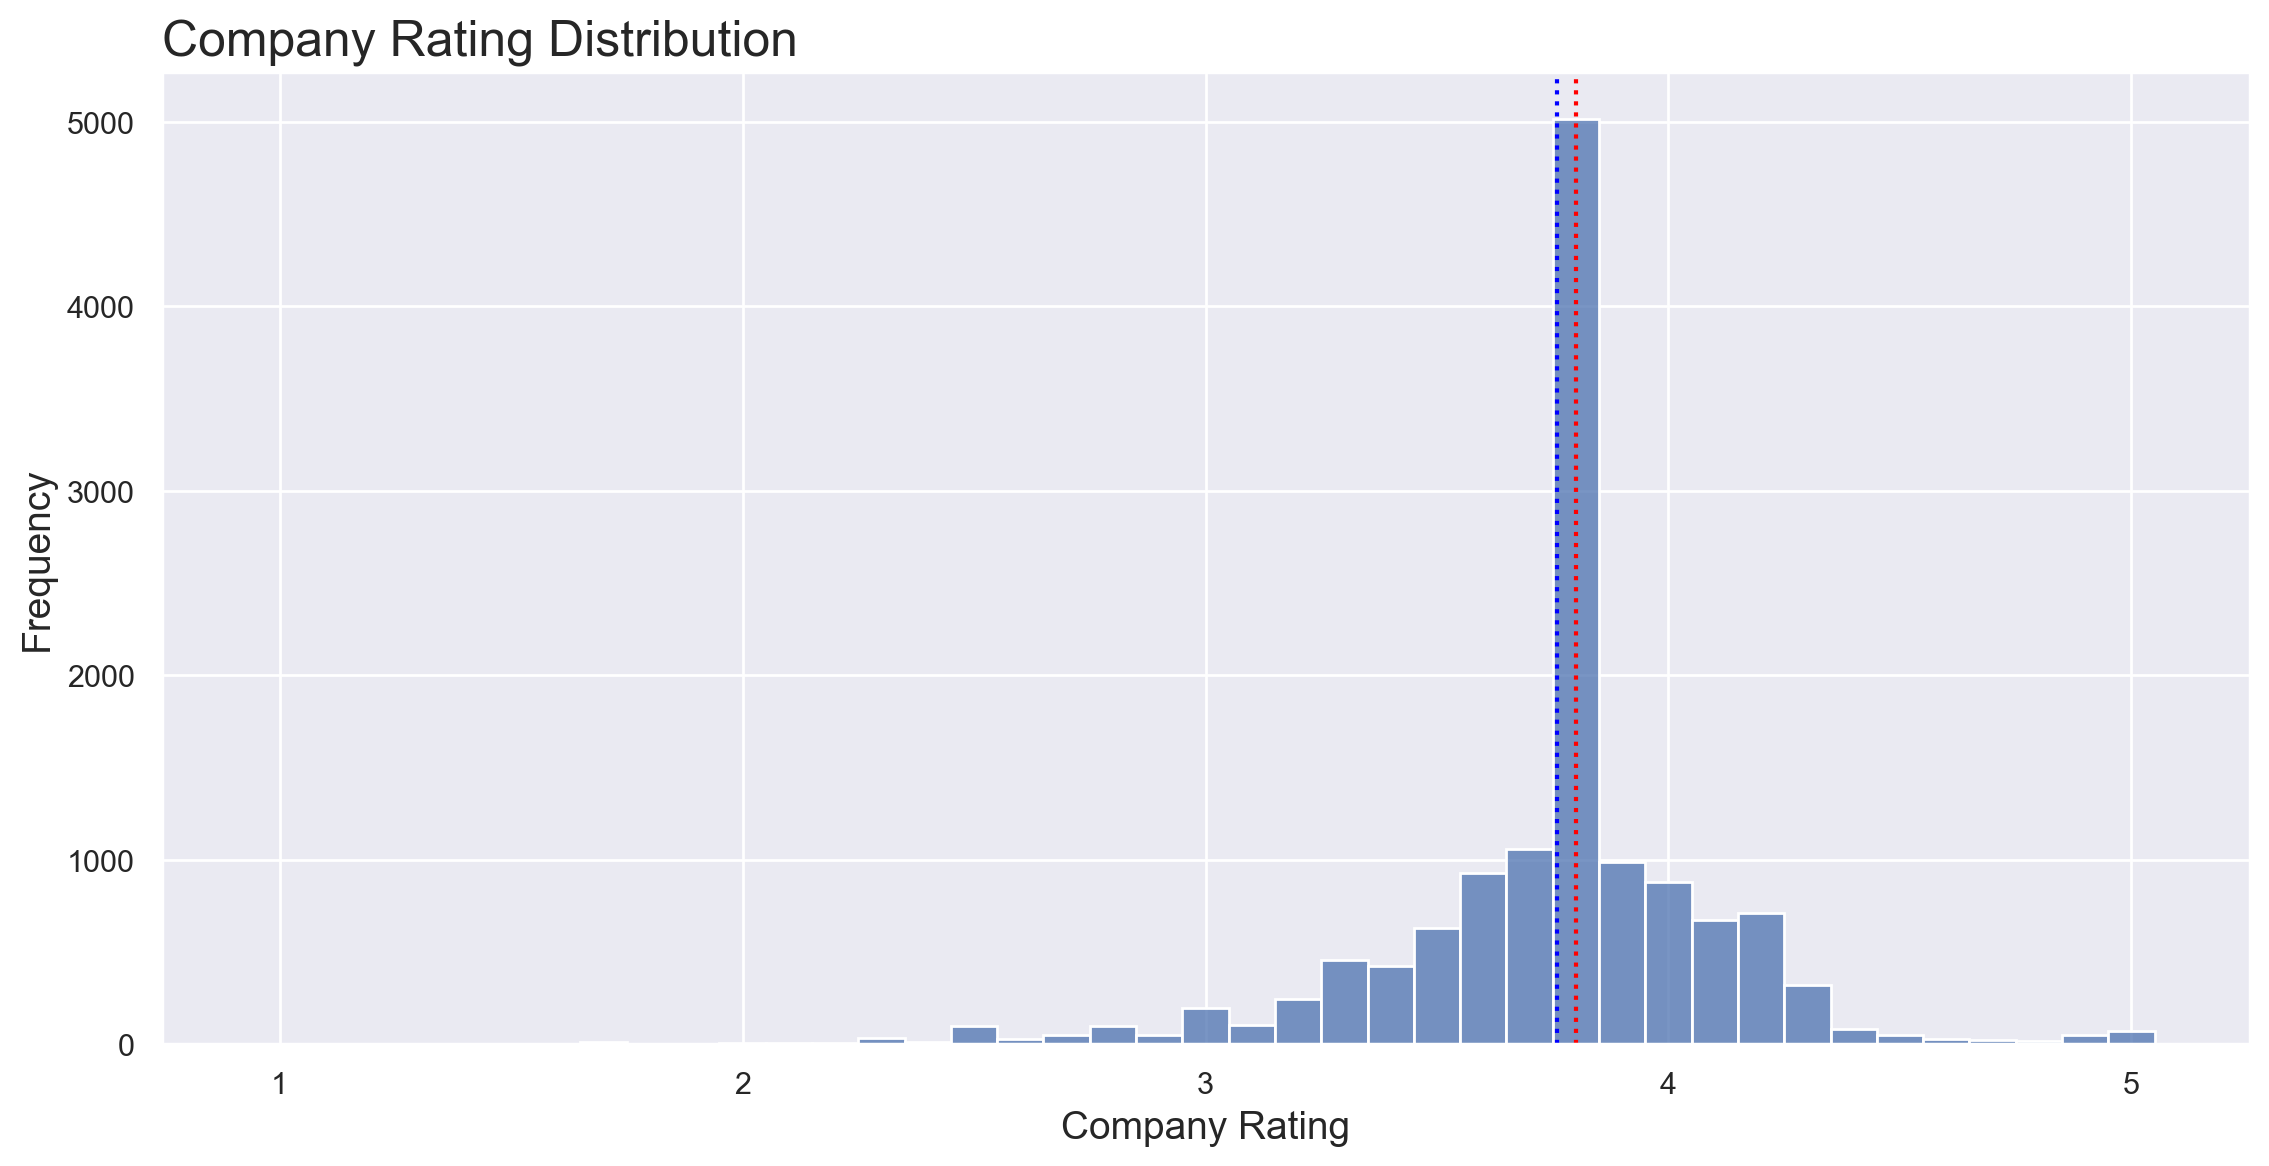

In [95]:
# Plotting the company rating distribution
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(df['company_rating'], bins=41, binrange=(0.95, 5.05), ax=ax)
ax.set_title('Company Rating Distribution', loc='left', fontsize=18)
ax.set_xlabel('Company Rating', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.axvline(x= df['company_rating'].mean(), color='blue', linestyle='dotted')
ax.axvline(x= df['company_rating'].median(), color='red', linestyle='dotted')

plt.show()

The histogram above for company rating shows a left skewed distribution, with a mean value of **3.75** (blue line) that is slightly smaller than the median (red line).  

<br/><br/>

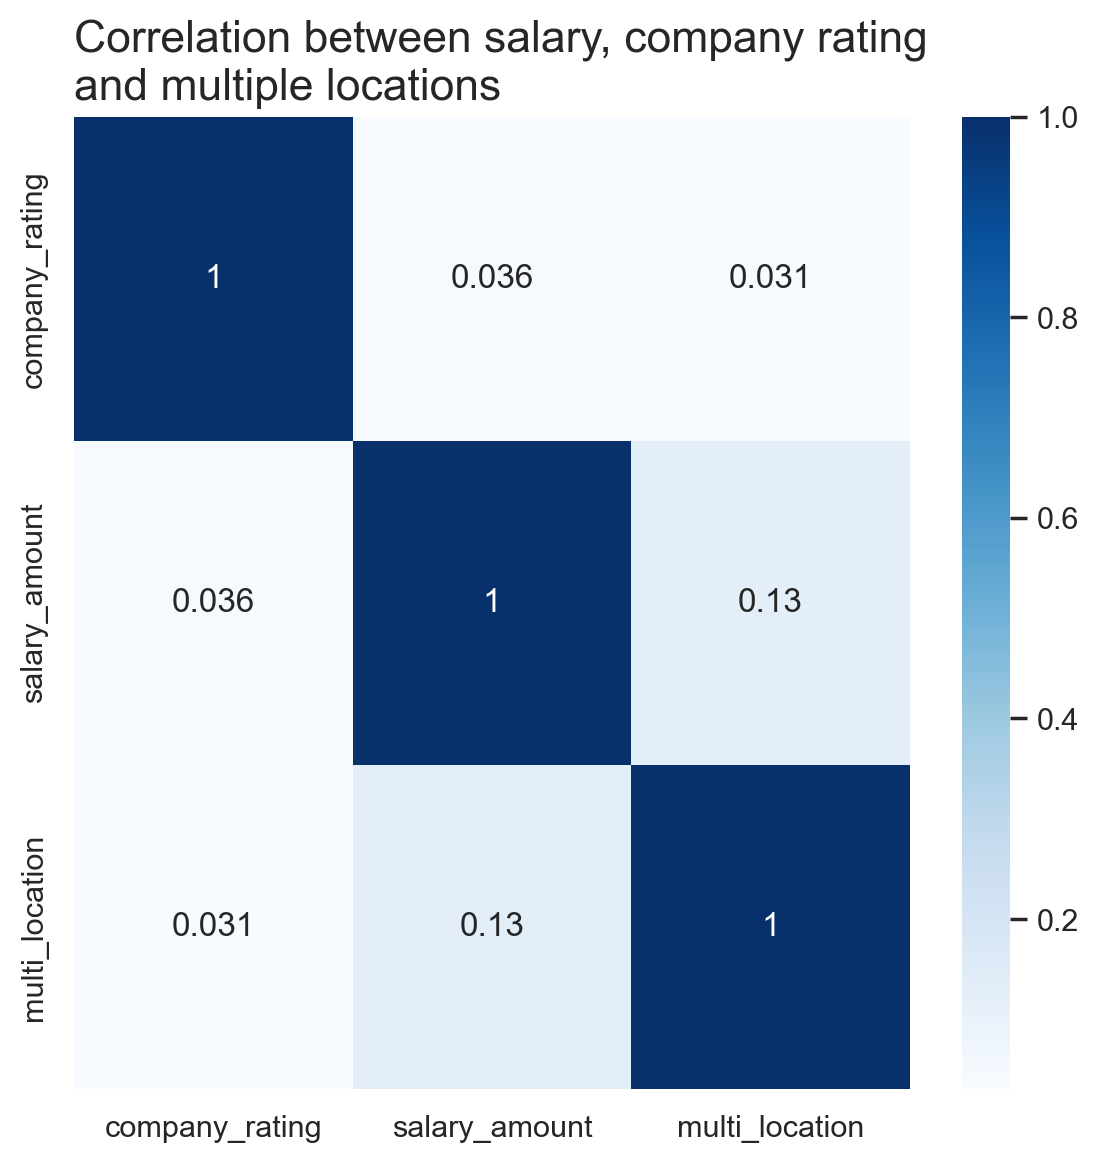

In [96]:
# Creating heatmap to show correlation between salary, company rating and multiple locations
plt.figure(figsize=(6, 6))

sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlation between salary, company rating \nand multiple locations', loc='left', fontsize = 16)

plt.show()

There are no significant correlations between the three numeric variables in the dataset.  

<br/><br/>

In [97]:
# Calculating the ratio of unique locations
len(df['company_location'].value_counts())/len(df)

0.3222305389221557

In [98]:
# Calculating the number of locations with 10 or more listings
np.sum(df['company_location'].value_counts()>=10)

213

In [99]:
# Calculating the ratio of unique cities
len(df['company_city'].value_counts())/len(df)

0.05793413173652694

In [100]:
# Calculating the number of cities with 10 or more listings
np.sum(df['company_city'].value_counts()>=10)

145

In [101]:
# Calculating the number of cities with 25 or more listings
np.sum(df['company_city'].value_counts()>=25)

80

In [102]:
# Calculating the number of cities with 50 or more listings
np.sum(df['company_city'].value_counts()>=50)

53

In [103]:
# Calculating the 50 cities with the most job listings
most_common_cc = df['company_city'].value_counts().sort_values(ascending = False).head(50)

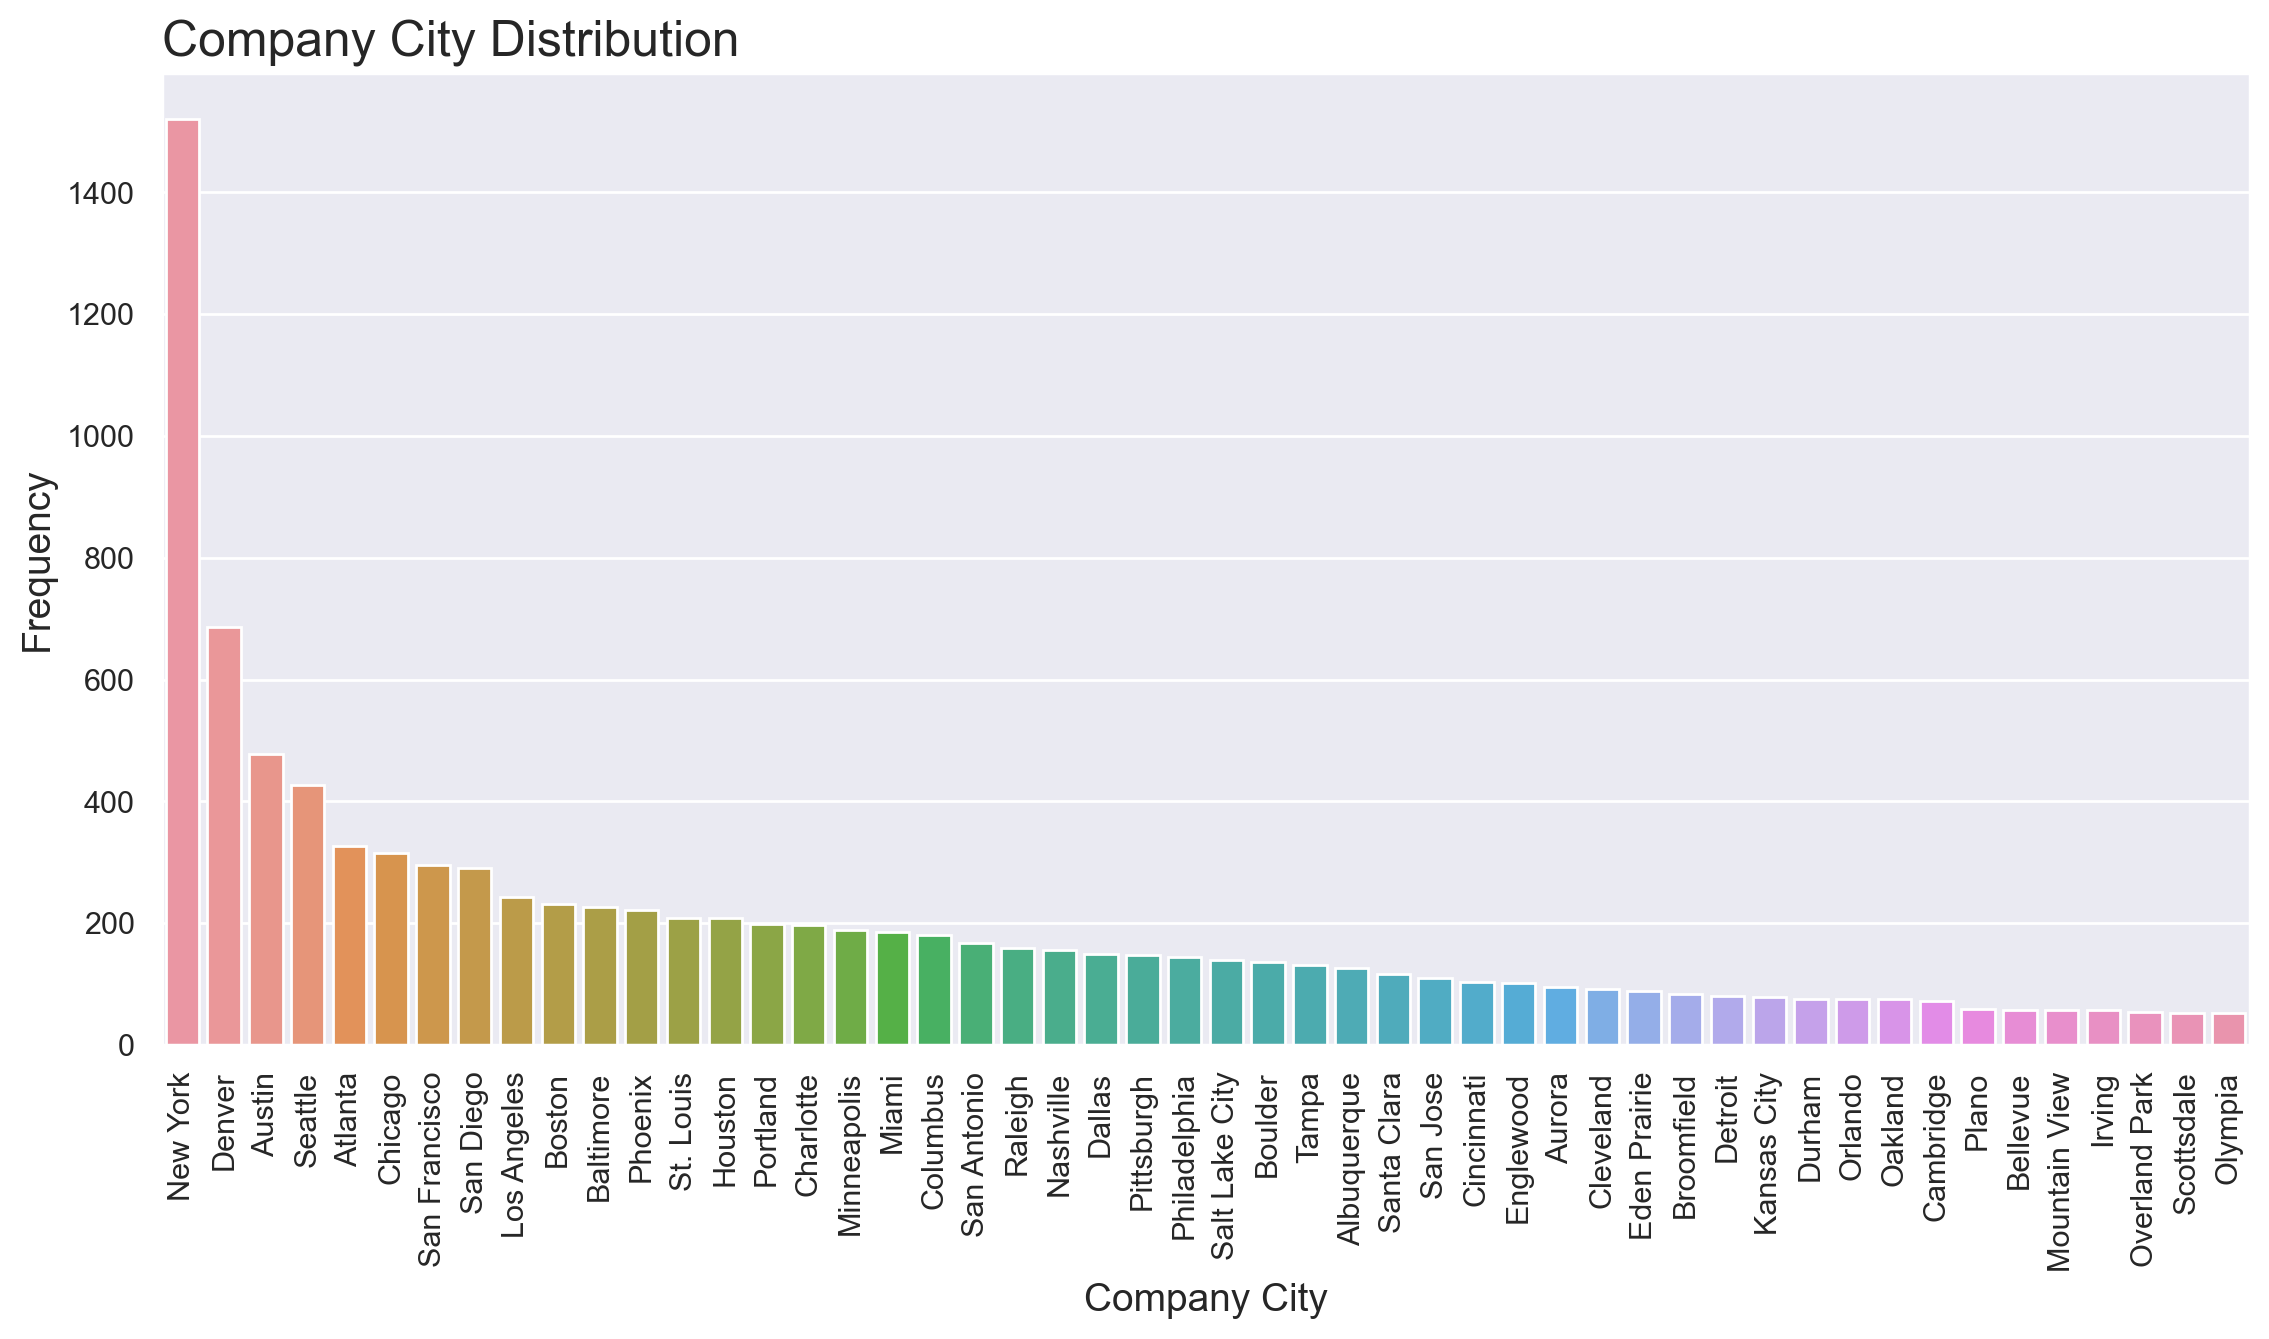

In [104]:
# Plotting the cities distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = most_common_cc.index, y = most_common_cc.values, ax=ax)
ax.set_title('Company City Distribution', loc='left', fontsize=18)
ax.set_xlabel('Company City', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

The cities with the most job listings are **New York City**, **Denver** and **Austin**, with the first having more than the other two combined.  
Approximately 6% of the cities in the dataset are unique, and only 80 cities have 25 or more job listings.  

<br/><br/>

In [105]:
# Filtering the dataframe to show only the jobs in these cities
top_cities = df[df['company_city'].isin(most_common_cc.index)]

# Calculating the median salary for each city
median_salary_city = top_cities.groupby('company_city')['salary_amount'].median().sort_values(ascending = False)

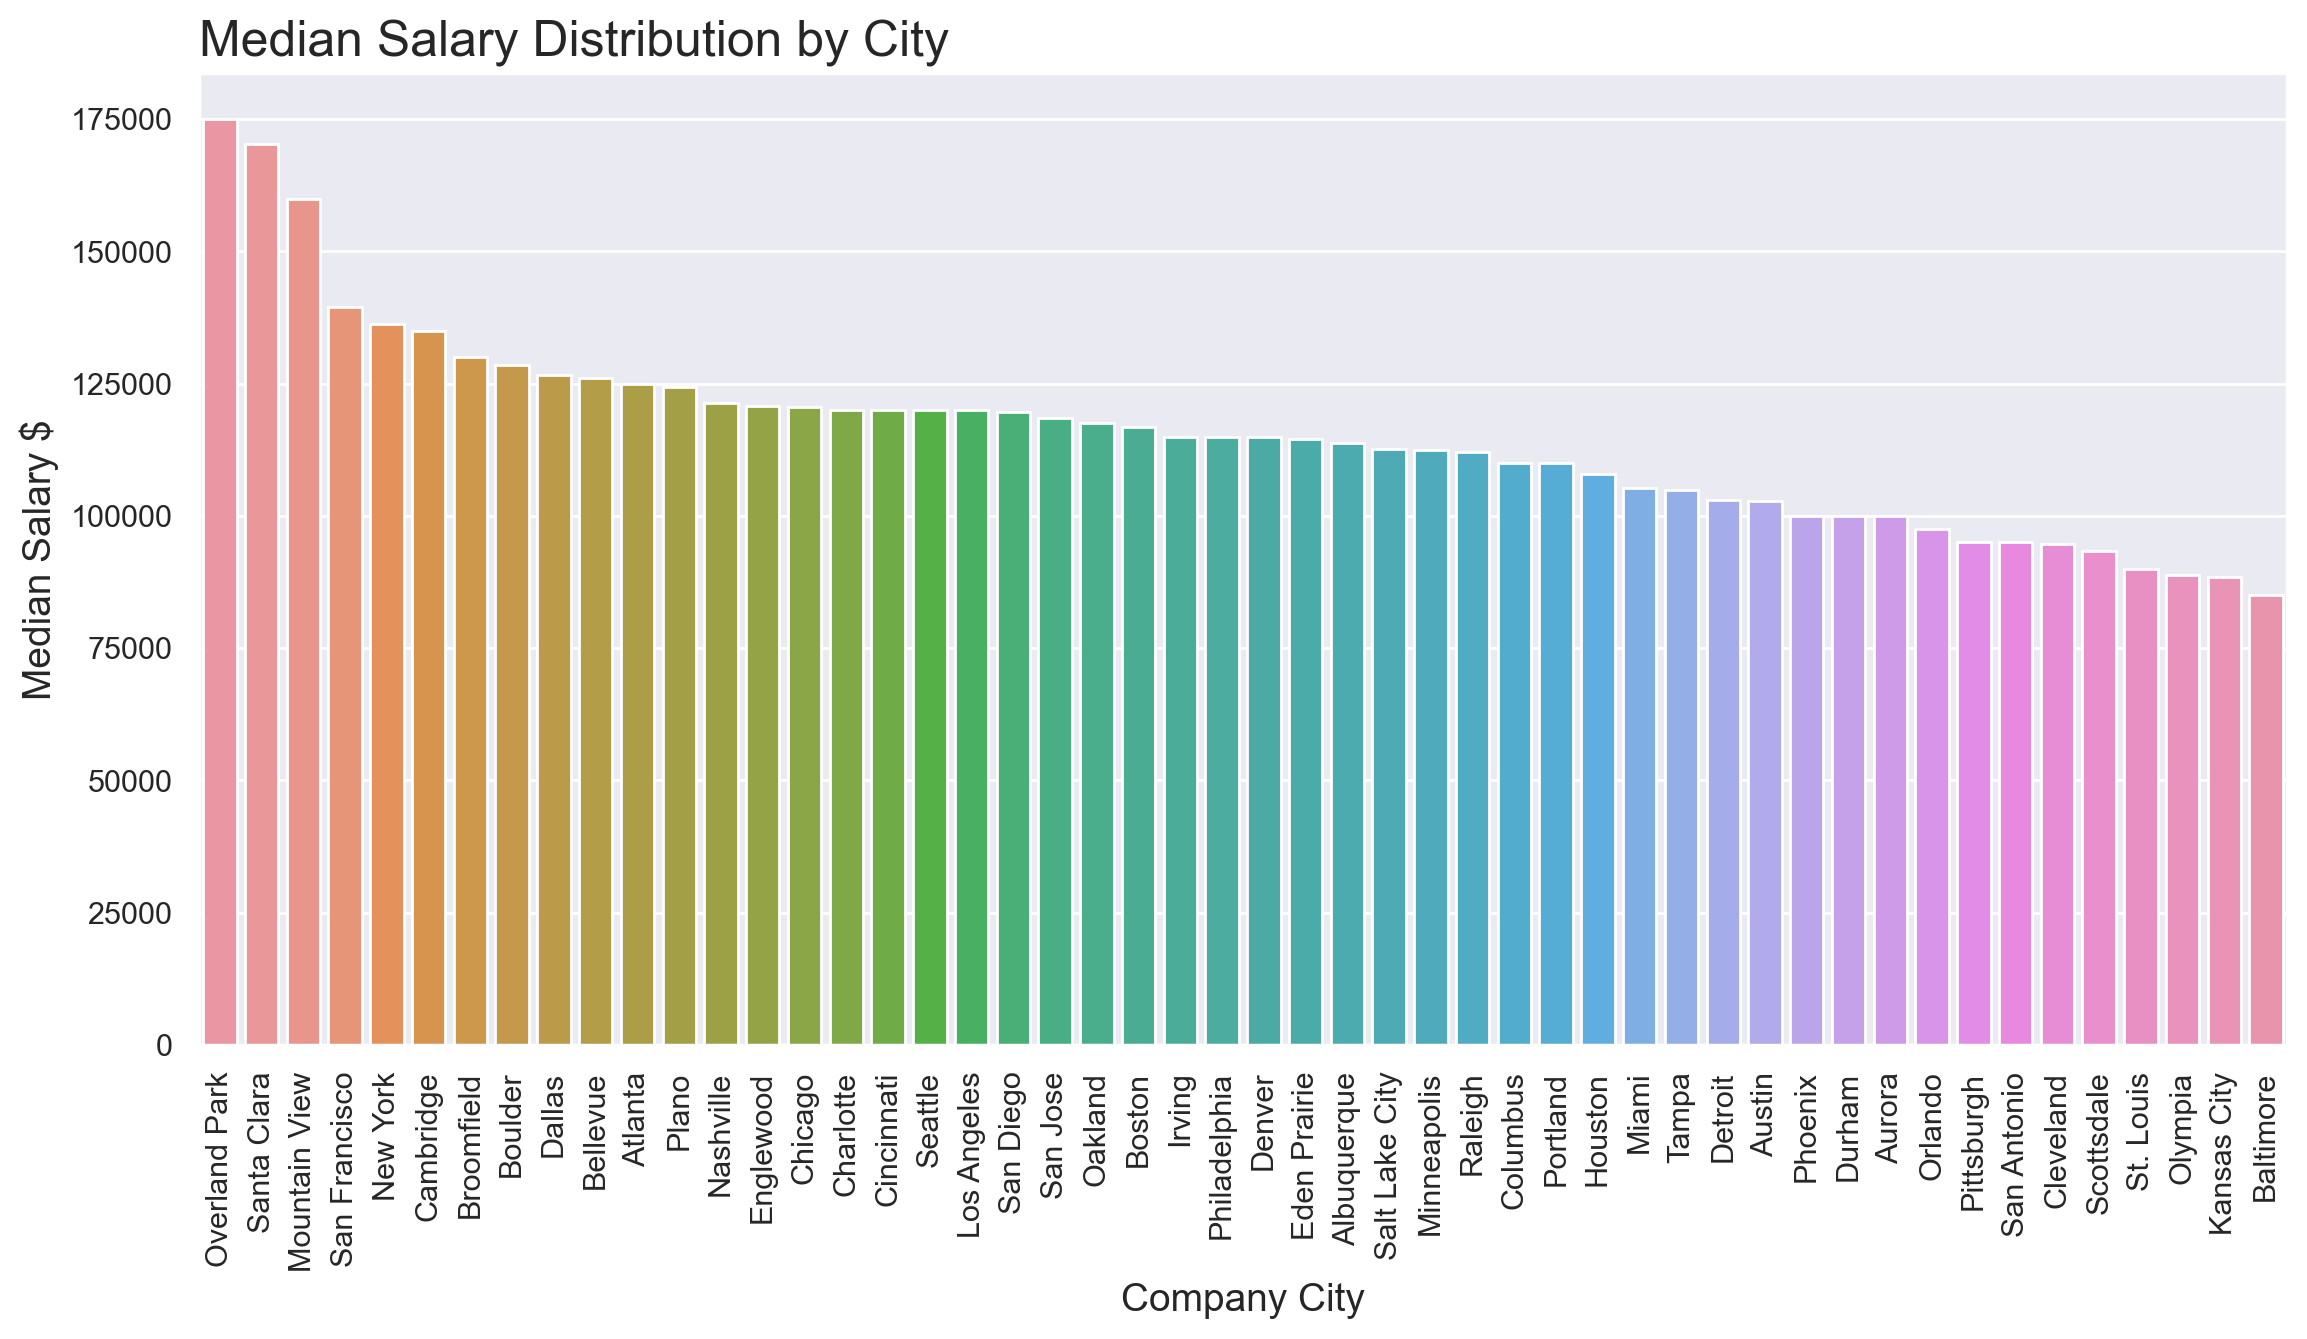

In [106]:
# Plotting the median salary distibution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = median_salary_city.index, y = median_salary_city.values, ax = ax)
ax.set_title('Median Salary Distribution by City', loc='left', fontsize=18)
ax.set_xlabel('Company City', fontsize = 14)
ax.set_ylabel('Median Salary $', fontsize = 14)

plt.show()

In [107]:
# Checking the entries in Overland Park
df[df['company_city'] == 'Overland Park']

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet
102,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,190000.0,Not Available,Not Available,0,Remote,Their AI-powered collaborative note-taking app...
103,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,210000.0,Not Available,Not Available,0,Remote,Members of the technology team work as a group...
106,Senior Data Engineer,Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,175000.0,Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...
107,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,175000.0,Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...
108,Senior Machine Learning Engineer,Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210+2 locations",Overland Park,KS,175000.0,Not Available,Not Available,2,Remote,Knowledge in at least one of following areas -...
110,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,190000.0,Not Available,Not Available,0,Remote,Who is Recruiting from Scratch: Recruiting fro...
111,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,210000.0,Not Available,Not Available,0,Remote,Who is Recruiting from Scratch: Recruiting fro...
114,Senior Data Engineer,Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,175000.0,Not Available,Not Available,0,Remote,About Our Client We are the global leader in e...
115,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210",Overland Park,KS,175000.0,Not Available,Not Available,0,Remote,About Our Client We are the global leader in e...
116,Senior Machine Learning Engineer,Recruiting From Scratch,3.8,"Remote in Overland Park, KS 66210+2 locations",Overland Park,KS,175000.0,Not Available,Not Available,2,Remote,About Our Client We are the global leader in e...


The cities with the highest median salary are **Overland Park** (KS), **Santa Clara** (CA) and **Mountain View** (CA), which are also the only ones exceeding \\$150,000.  
While Santa Clara and Mountain View are in Silicon Valley and are expected to pay top tier salaries, Overland Park is in Kansas and is not generally considered a tech hotspot.  
The city has 54 job listings and most high salary positions come from **Recruiting From Scratch**.

<br/><br/>

In [108]:
# Calculating the states with the most job listings
most_common_cs = df['company_state'].value_counts().sort_values(ascending = False)

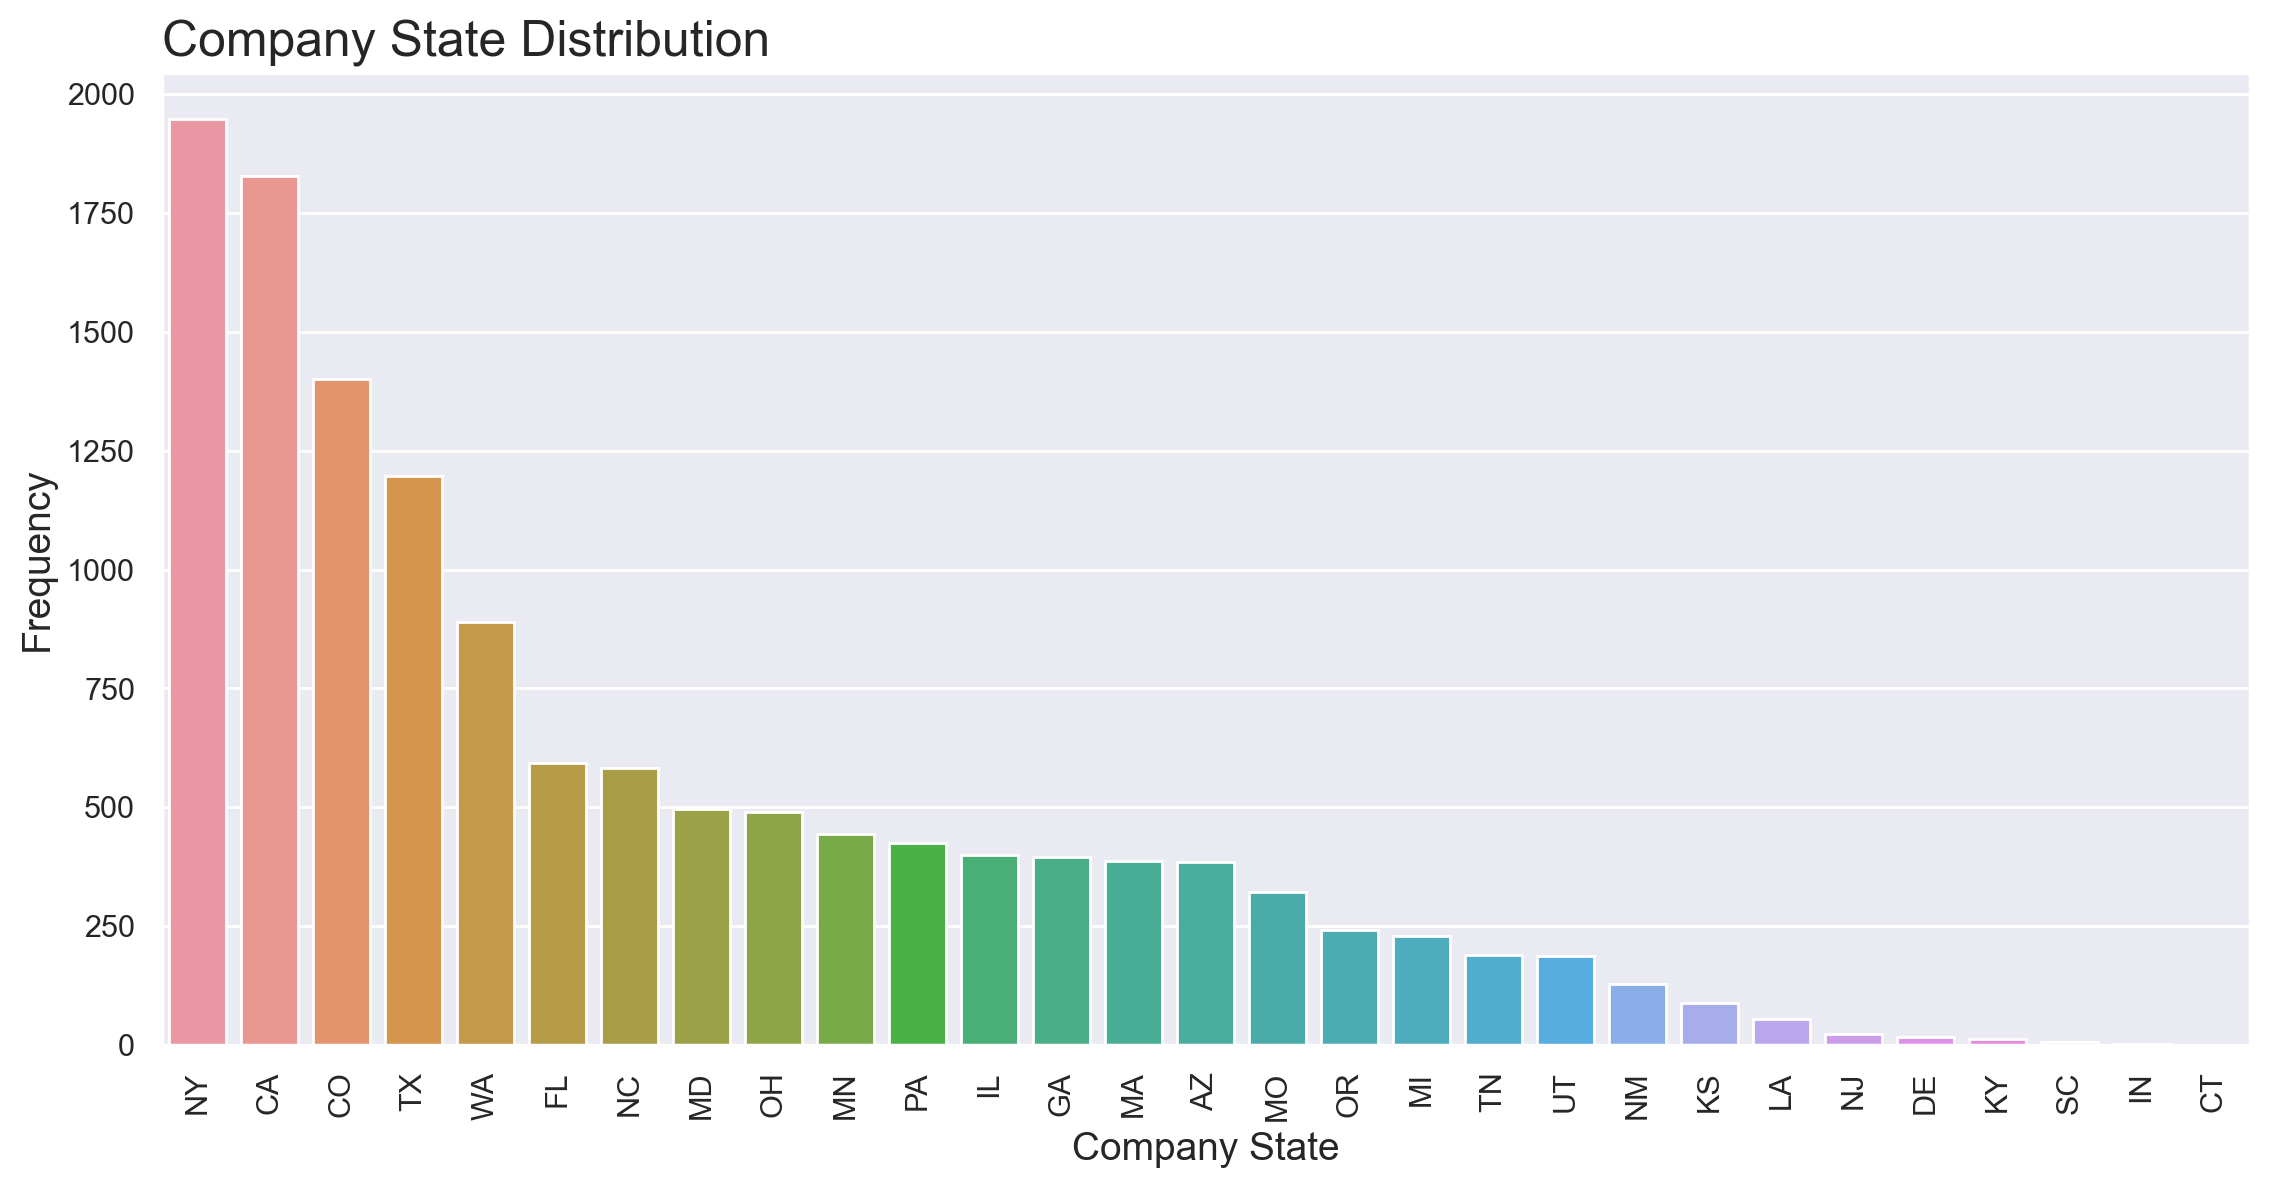

In [109]:
# Plotting the states distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = most_common_cs.index, y = most_common_cs.values, ax=ax)
ax.set_title('Company State Distribution', loc='left', fontsize=18)
ax.set_xlabel('Company State', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

The states with the most job listings are **New York**, **California**, **Colorado**, **Texas** and **Washington**, which together account for approximately 54% of the job listings.  

<br/><br/>

In [110]:
# Calculating the median salary for each state
median_salary_state = df.groupby('company_state')['salary_amount'].median().sort_values(ascending = False)

In [111]:
median_salary_state.head()

company_state
DE    135100.0
NY    127937.5
CA    125000.0
KS    125000.0
TN    120000.0
Name: salary_amount, dtype: float64

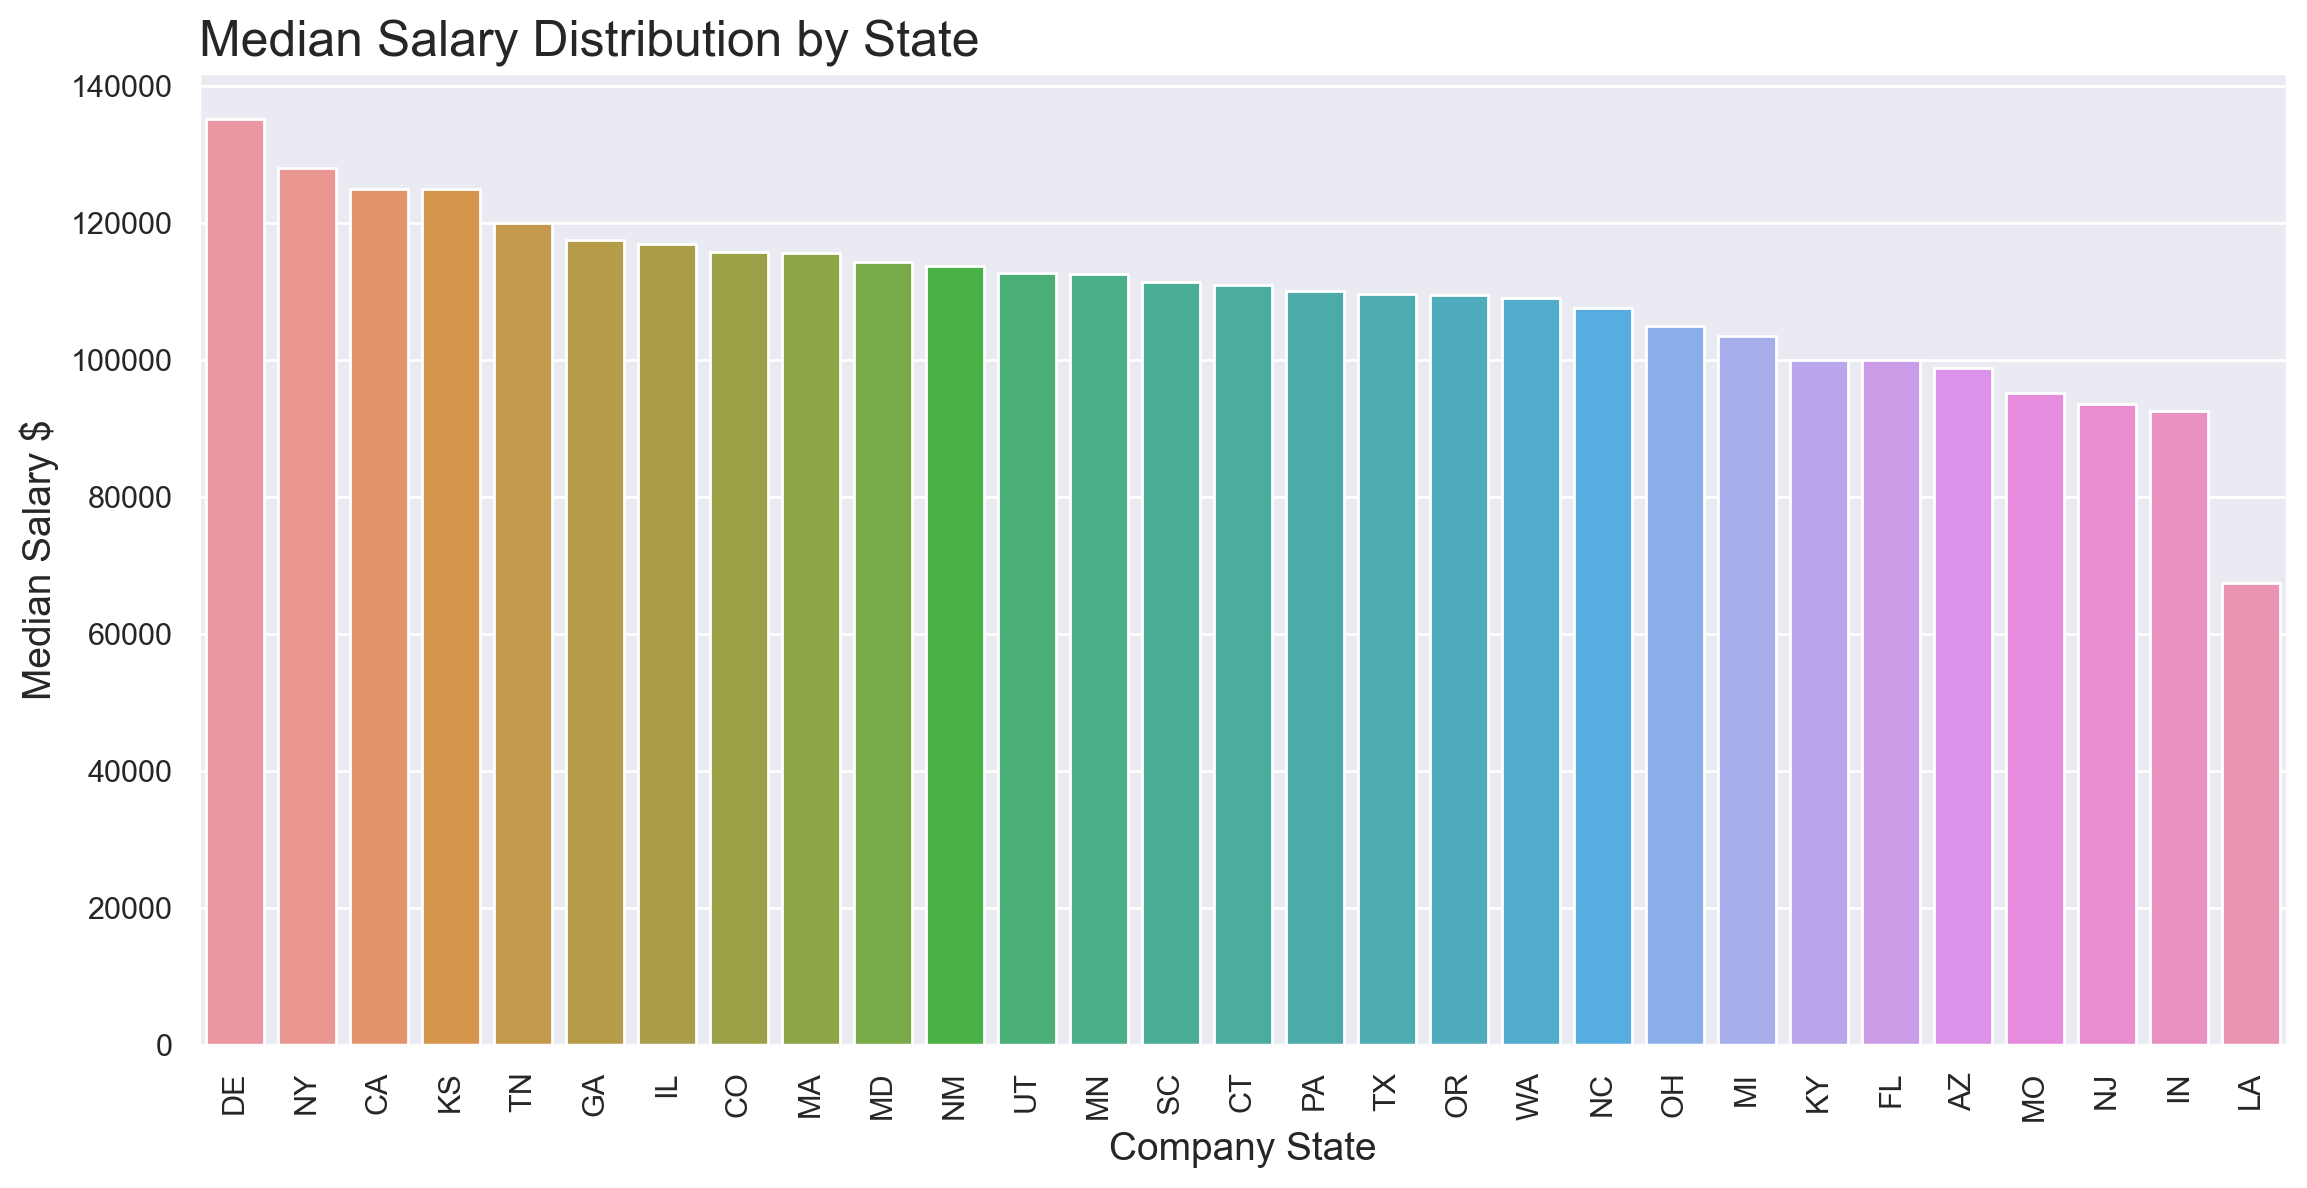

In [112]:
# Plotting the median salary distibution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = median_salary_state.index, y = median_salary_state.values, ax = ax)
ax.set_title('Median Salary Distribution by State', loc='left', fontsize=18)
ax.set_xlabel('Company State', fontsize = 14)
ax.set_ylabel('Median Salary $', fontsize = 14)

plt.show()

The states with the highest median salary are **Delaware**, **New York**, **California** and **Kansas**.  
  
<br/><br/>

In [113]:
# Calculating the median salary for each additional job location
median_salary_mlocation = df.groupby('multi_location')['salary_amount'].median().sort_values(ascending = False)

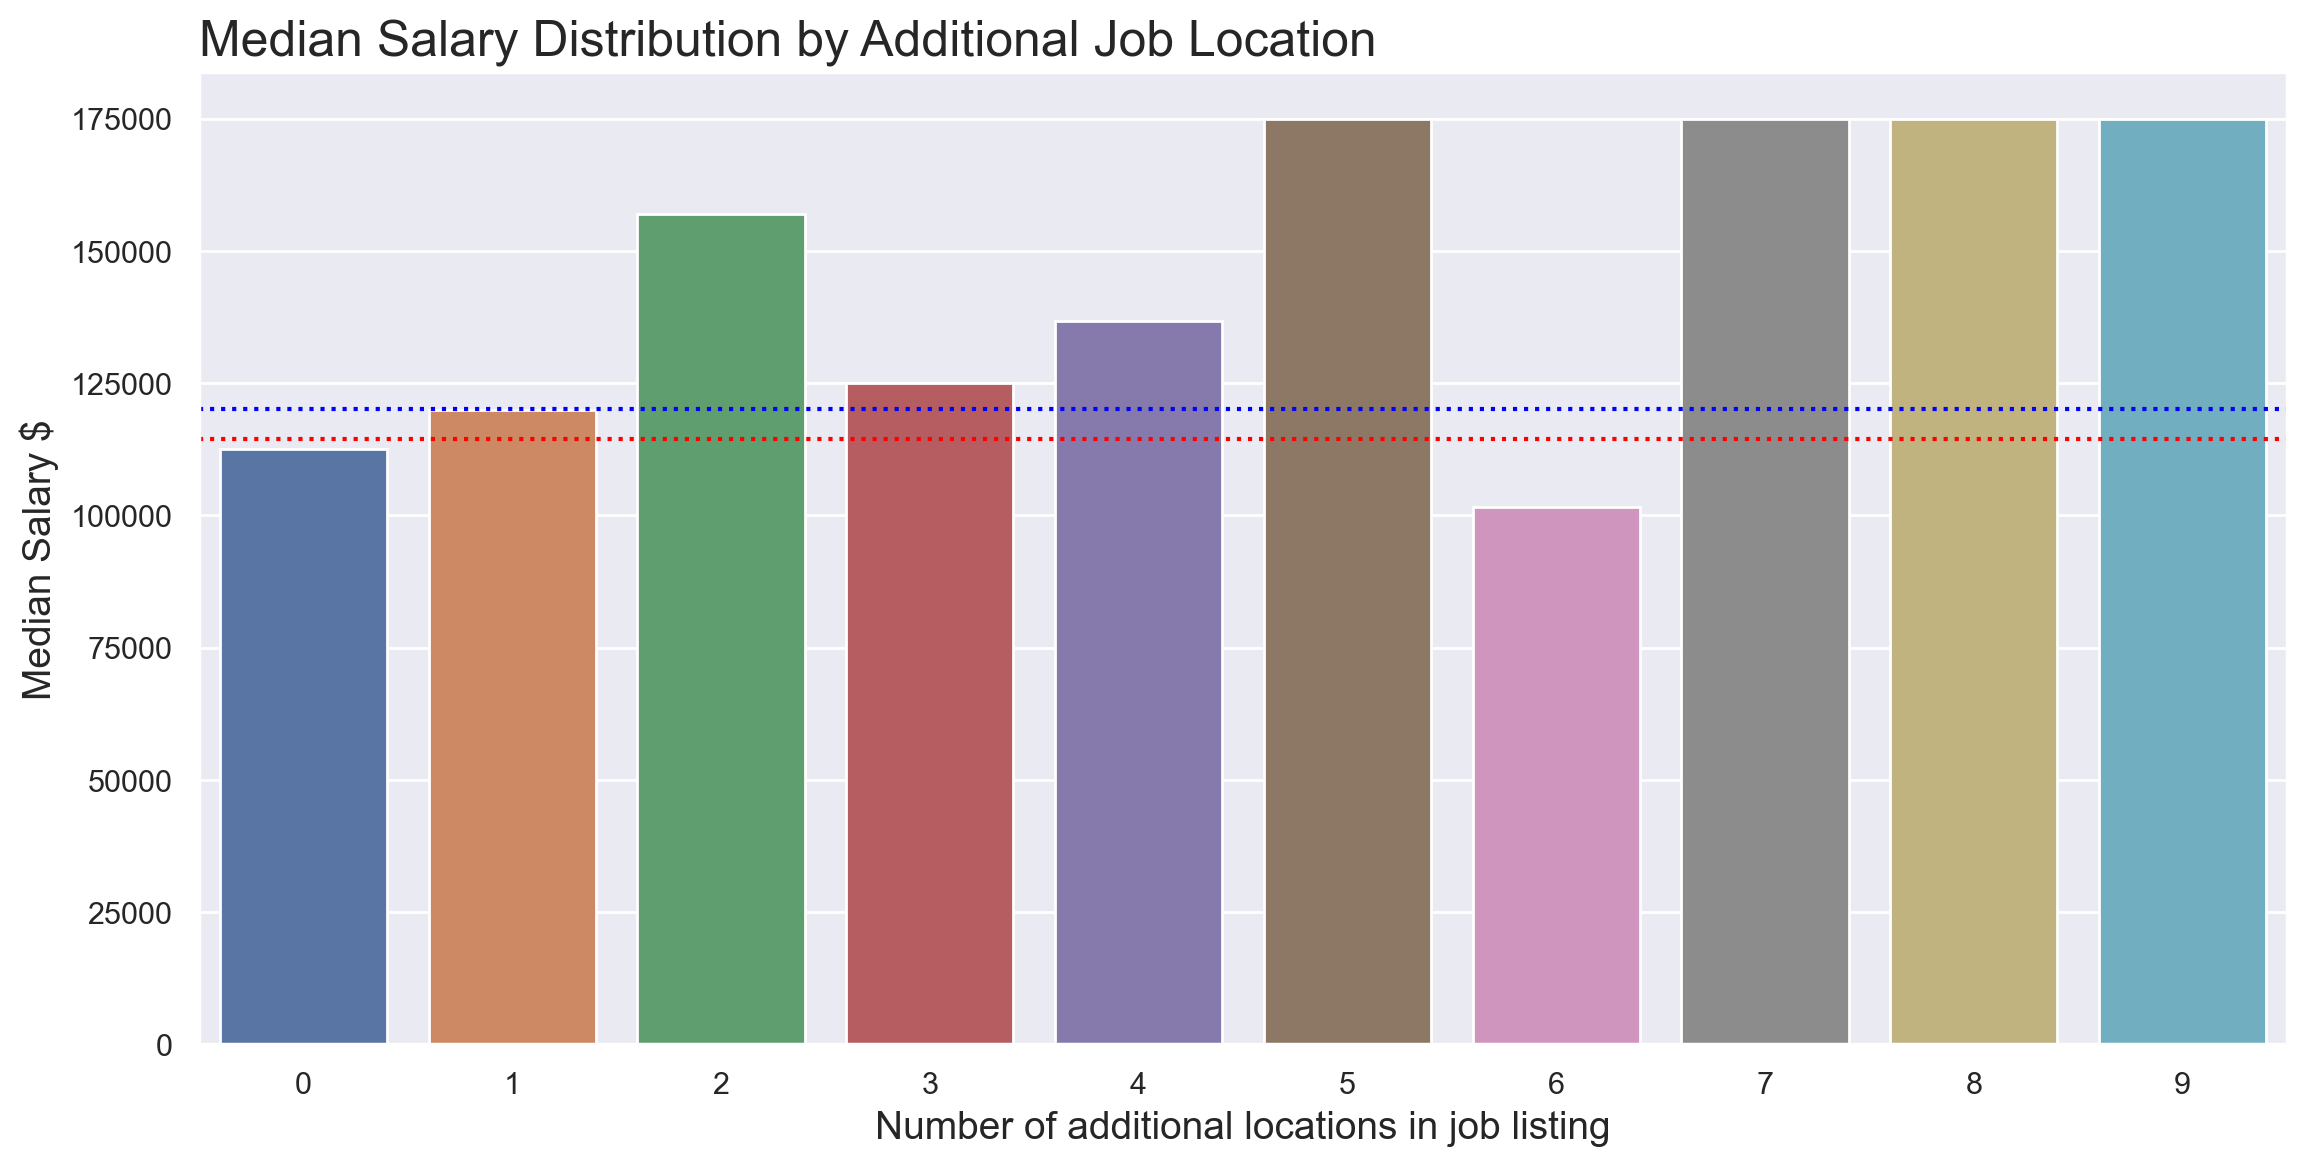

In [114]:
# Plotting the median salary distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 0)
sns.barplot(x = median_salary_mlocation.index, y = median_salary_mlocation.values, ax = ax)
ax.set_title('Median Salary Distribution by Additional Job Location', loc='left', fontsize=18)
ax.set_xlabel('Number of additional locations in job listing', fontsize = 14)
ax.set_ylabel('Median Salary $', fontsize = 14)
ax.axhline(y= df['salary_amount'].mean(), color='blue', linestyle='dotted')
ax.axhline(y= df['salary_amount'].median(), color='red', linestyle='dotted')

plt.show()

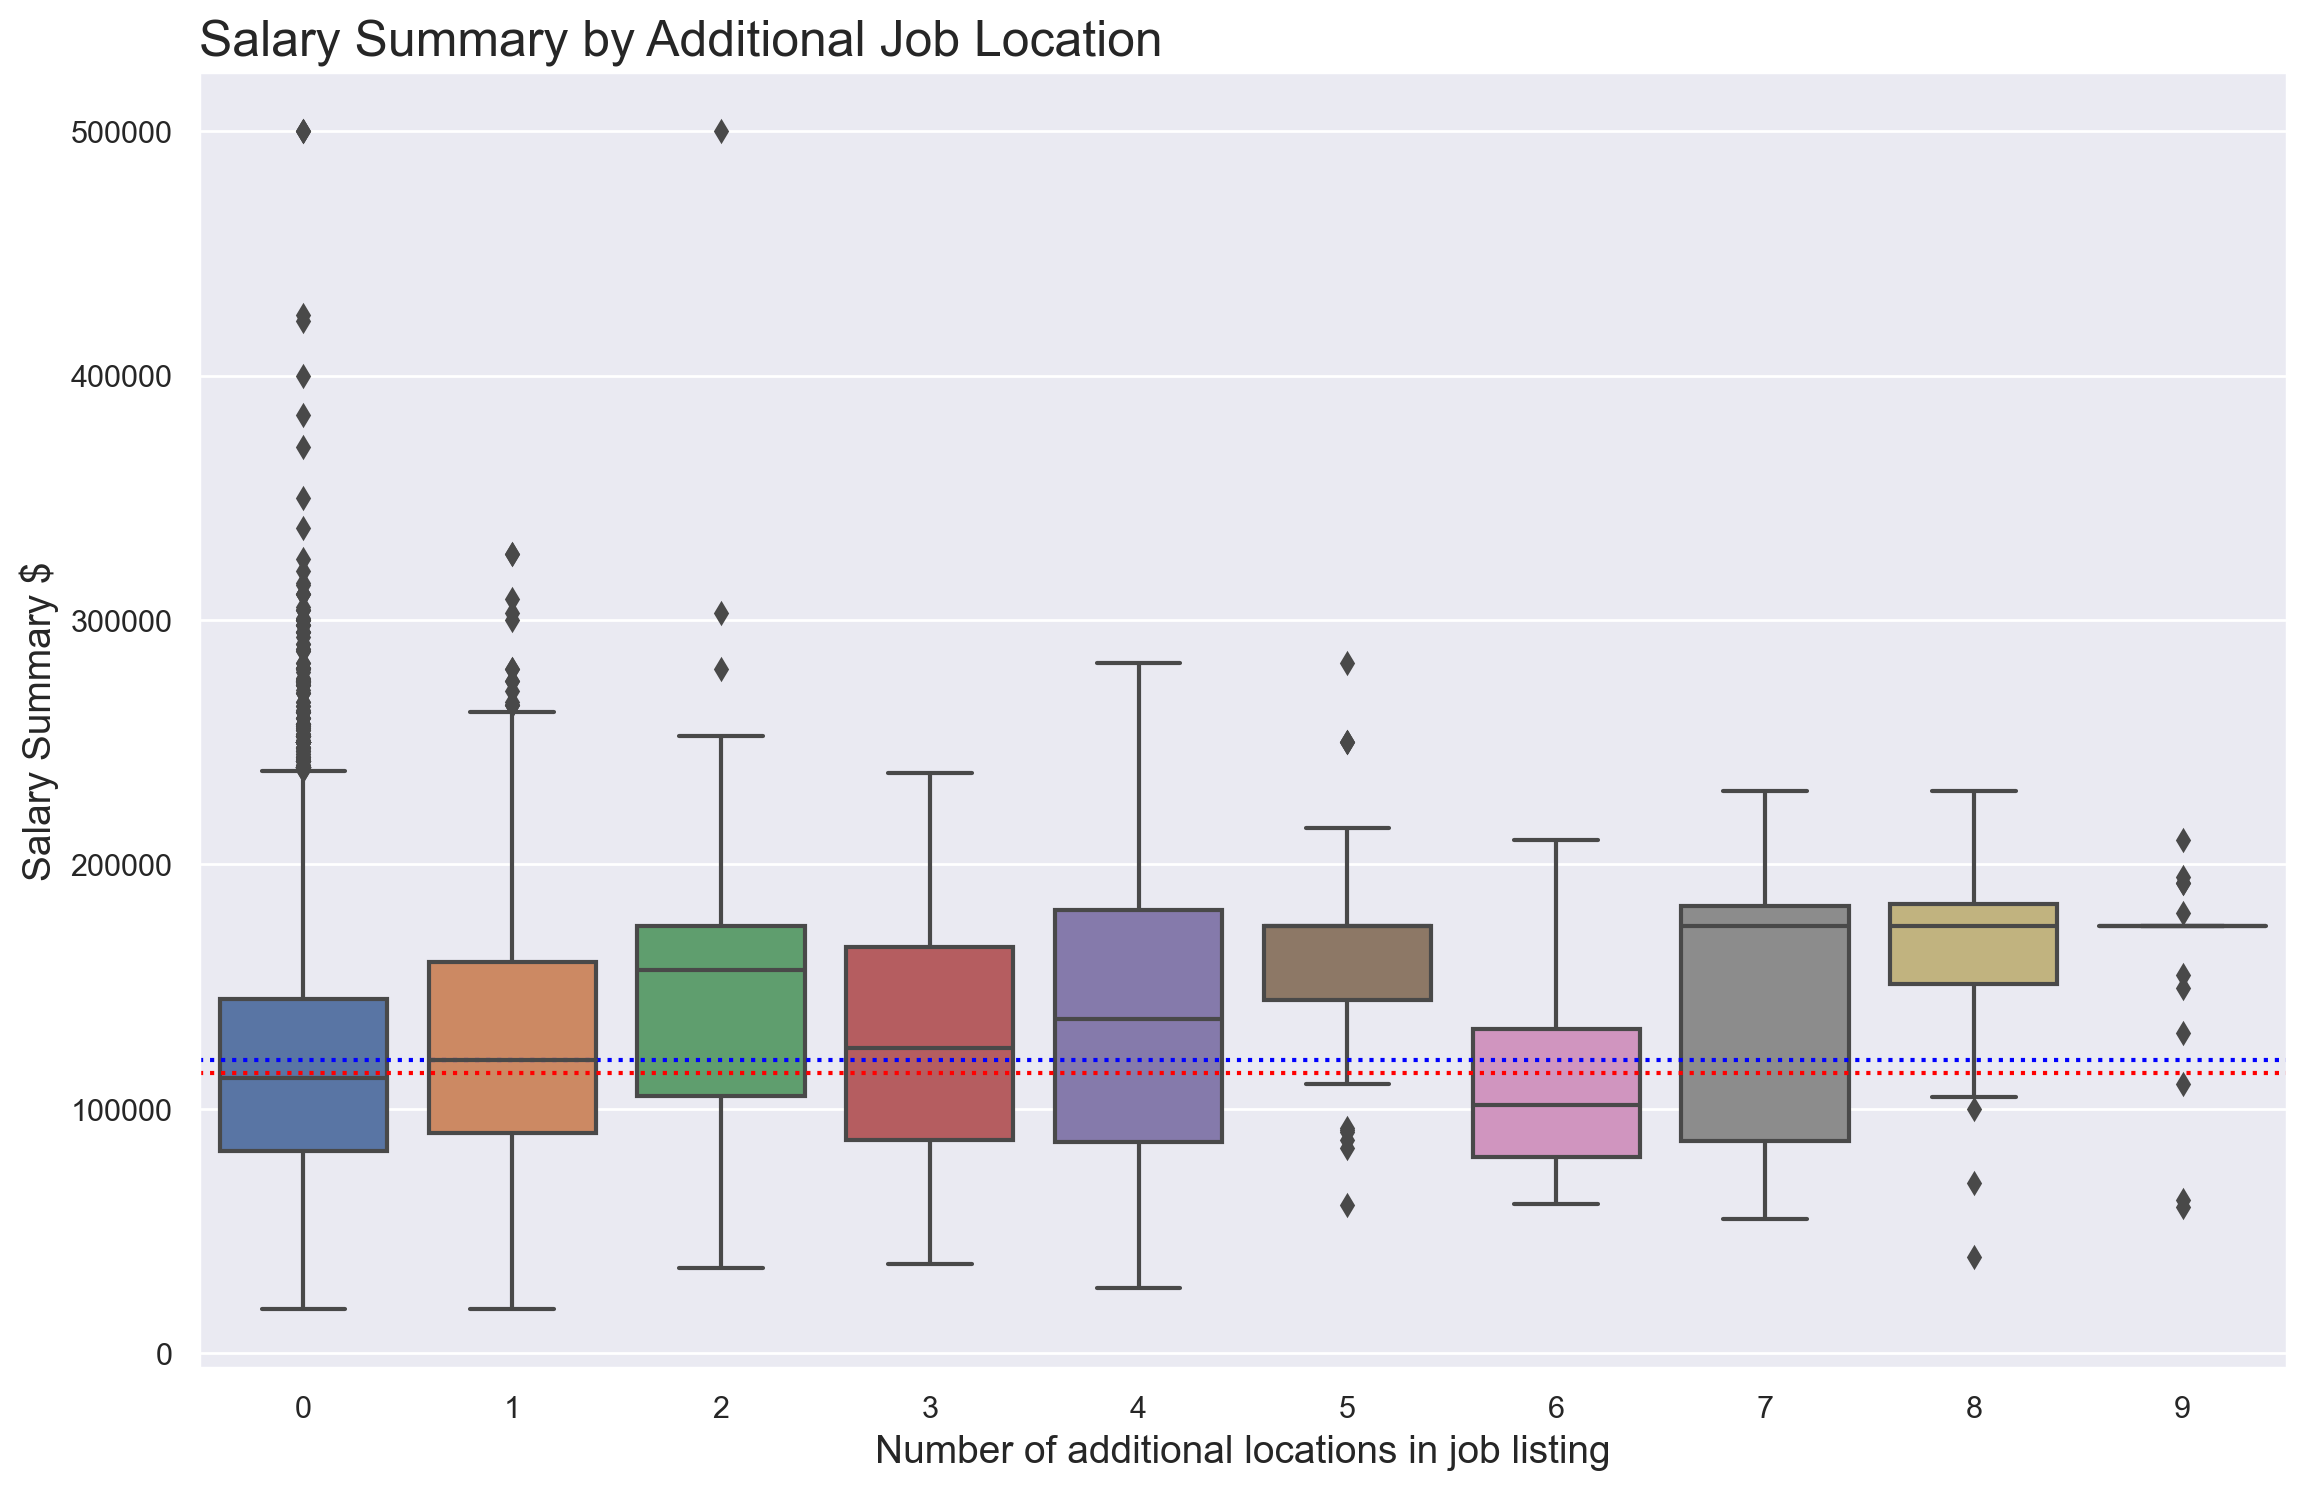

In [115]:
# Plotting the salary summary by the number of additional job locations
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(x = df['multi_location'], y = df['salary_amount'])
ax.set_title('Salary Summary by Additional Job Location', loc='left', fontsize=18)
ax.set_xlabel('Number of additional locations in job listing', fontsize = 14)
ax.set_ylabel('Salary Summary $', fontsize = 14)
ax.axhline(y= df['salary_amount'].mean(), color='blue', linestyle='dotted')
ax.axhline(y= df['salary_amount'].median(), color='red', linestyle='dotted')

plt.show()

Multiple job locations might be indicative of a position in larger companies, which usually tend to have a larger salary budget.  
The median salary is actually highest for vacancies with 7, 8 and 9 locations, but the relation is not linear since job listings with 6 locations show the lowest value in the range.  


<br/><br/>

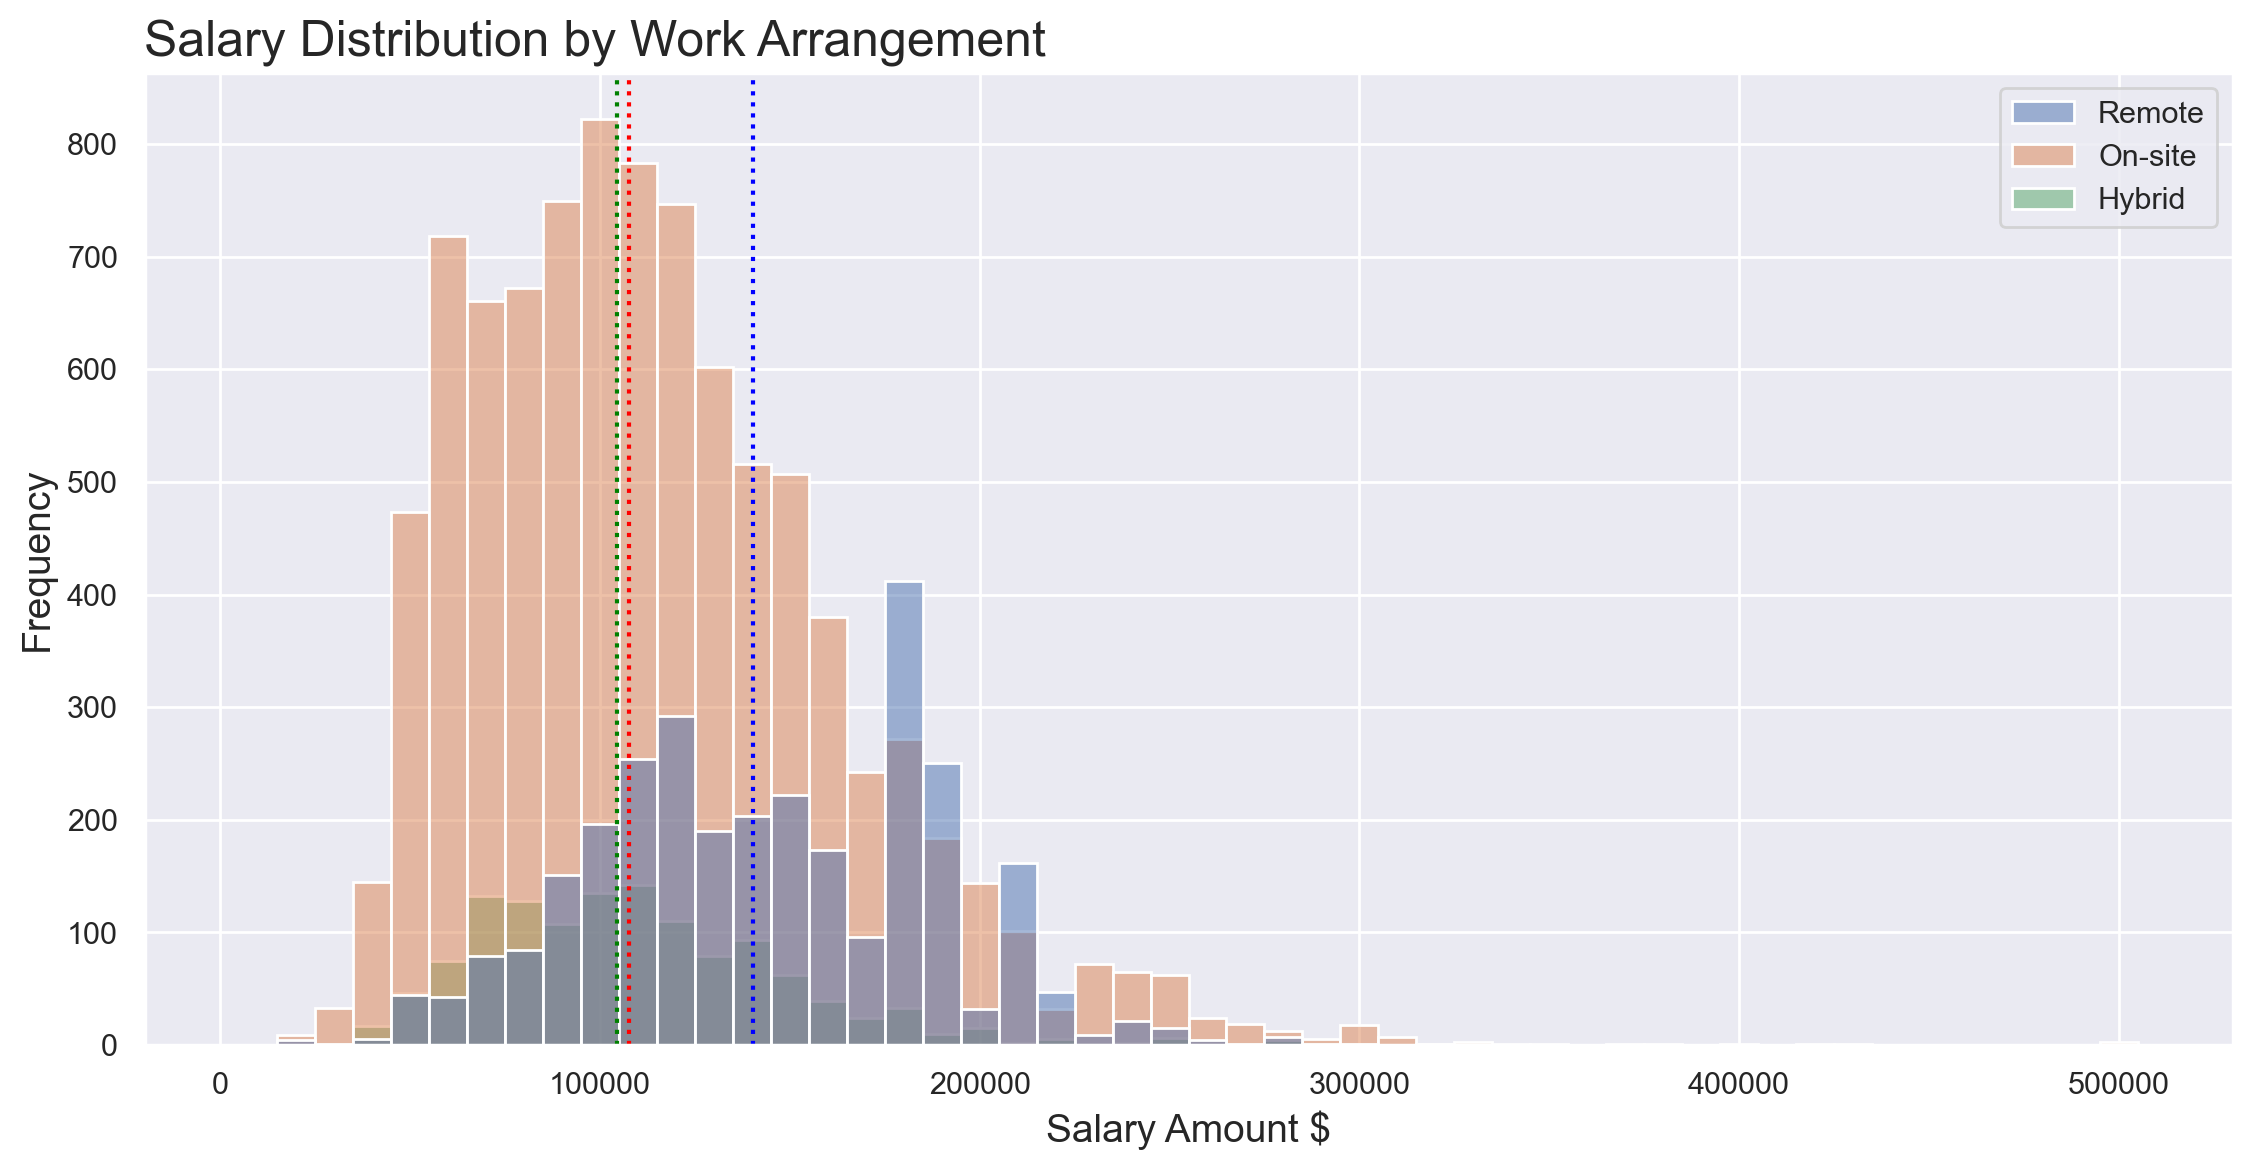

In [116]:
# Plotting the salary distibution by work arrangement
fig, ax = plt.subplots(figsize = (12,6))

sns.histplot(df, x = 'salary_amount', hue = 'work_arrangement', bins=50, binrange=(5000, 505000), ax = ax)
ax.set_title('Salary Distribution by Work Arrangement', loc='left', fontsize=18)
ax.set_xlabel('Salary Amount $', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.get_legend().set_title("")

ax.axvline(x= df[df['work_arrangement'] == 'Hybrid']['salary_amount'].median(), color='green', linestyle='dotted')
ax.axvline(x= df[df['work_arrangement'] == 'Remote']['salary_amount'].median(), color='blue', linestyle='dotted')
ax.axvline(x= df[df['work_arrangement'] == 'On-site']['salary_amount'].median(), color='red', linestyle='dotted')

plt.show()

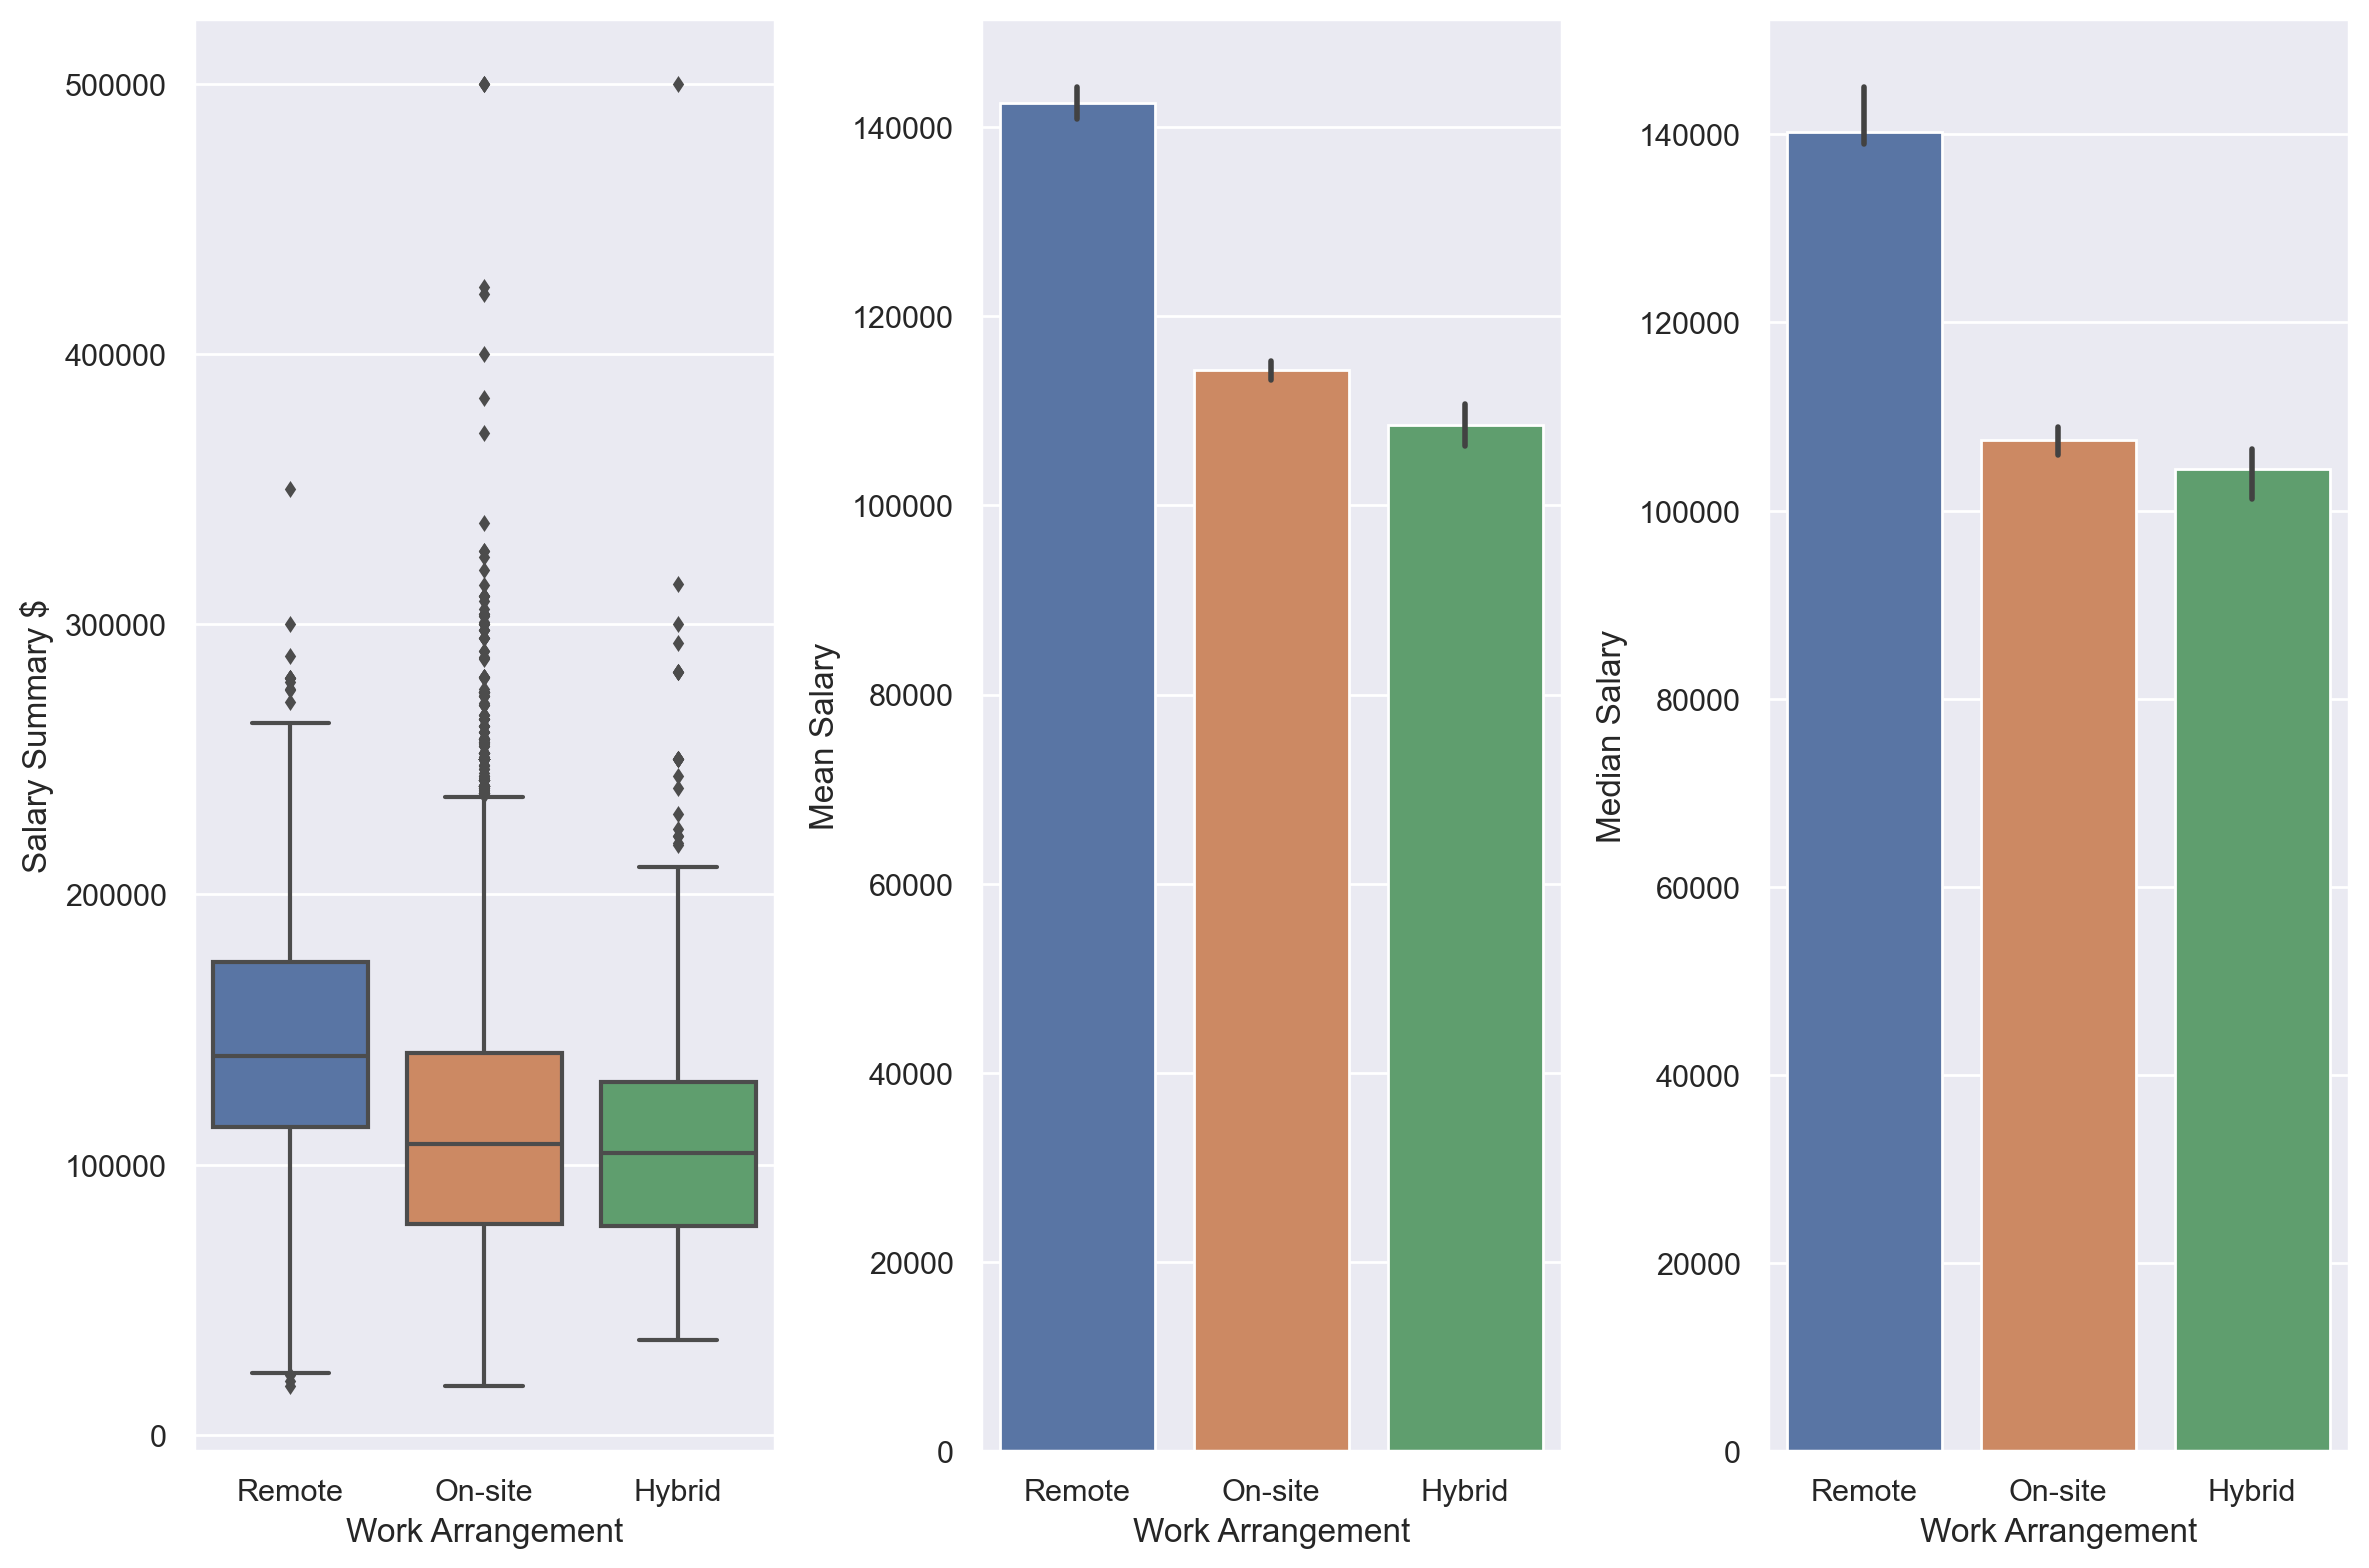

In [117]:
# Plotting the salary summary, mean and median by work arrangement
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,8))

sns.boxplot(data = df, x = 'work_arrangement', y = 'salary_amount', fliersize=3, ax = ax[0])
ax[0].set_xlabel('Work Arrangement', fontsize=12)
ax[0].set_ylabel('Salary Summary $', fontsize=12)

sns.barplot(data = df, x = 'work_arrangement', y = 'salary_amount', estimator = np.mean, errwidth=2, ax = ax[1])
ax[1].set_xlabel('Work Arrangement', fontsize = 12)
ax[1].set_ylabel('Mean Salary', fontsize = 12)

sns.barplot(data = df, x = 'work_arrangement', y = 'salary_amount', estimator = np.median, errwidth=2, ax = ax[2])
ax[2].set_xlabel('Work Arrangement', fontsize = 12)
ax[2].set_ylabel('Median Salary', fontsize = 12)

plt.tight_layout()
plt.show()

On-site listings are the most frequent in the dataset while hybrid listings are the smallest subset; remote positions have the highest mean and median salary while hybrid ones have the lowest.  
All three subsets show a typical right skewed (or positive) distribution, with the mean salary larger than the median one.  

<br/><br/>

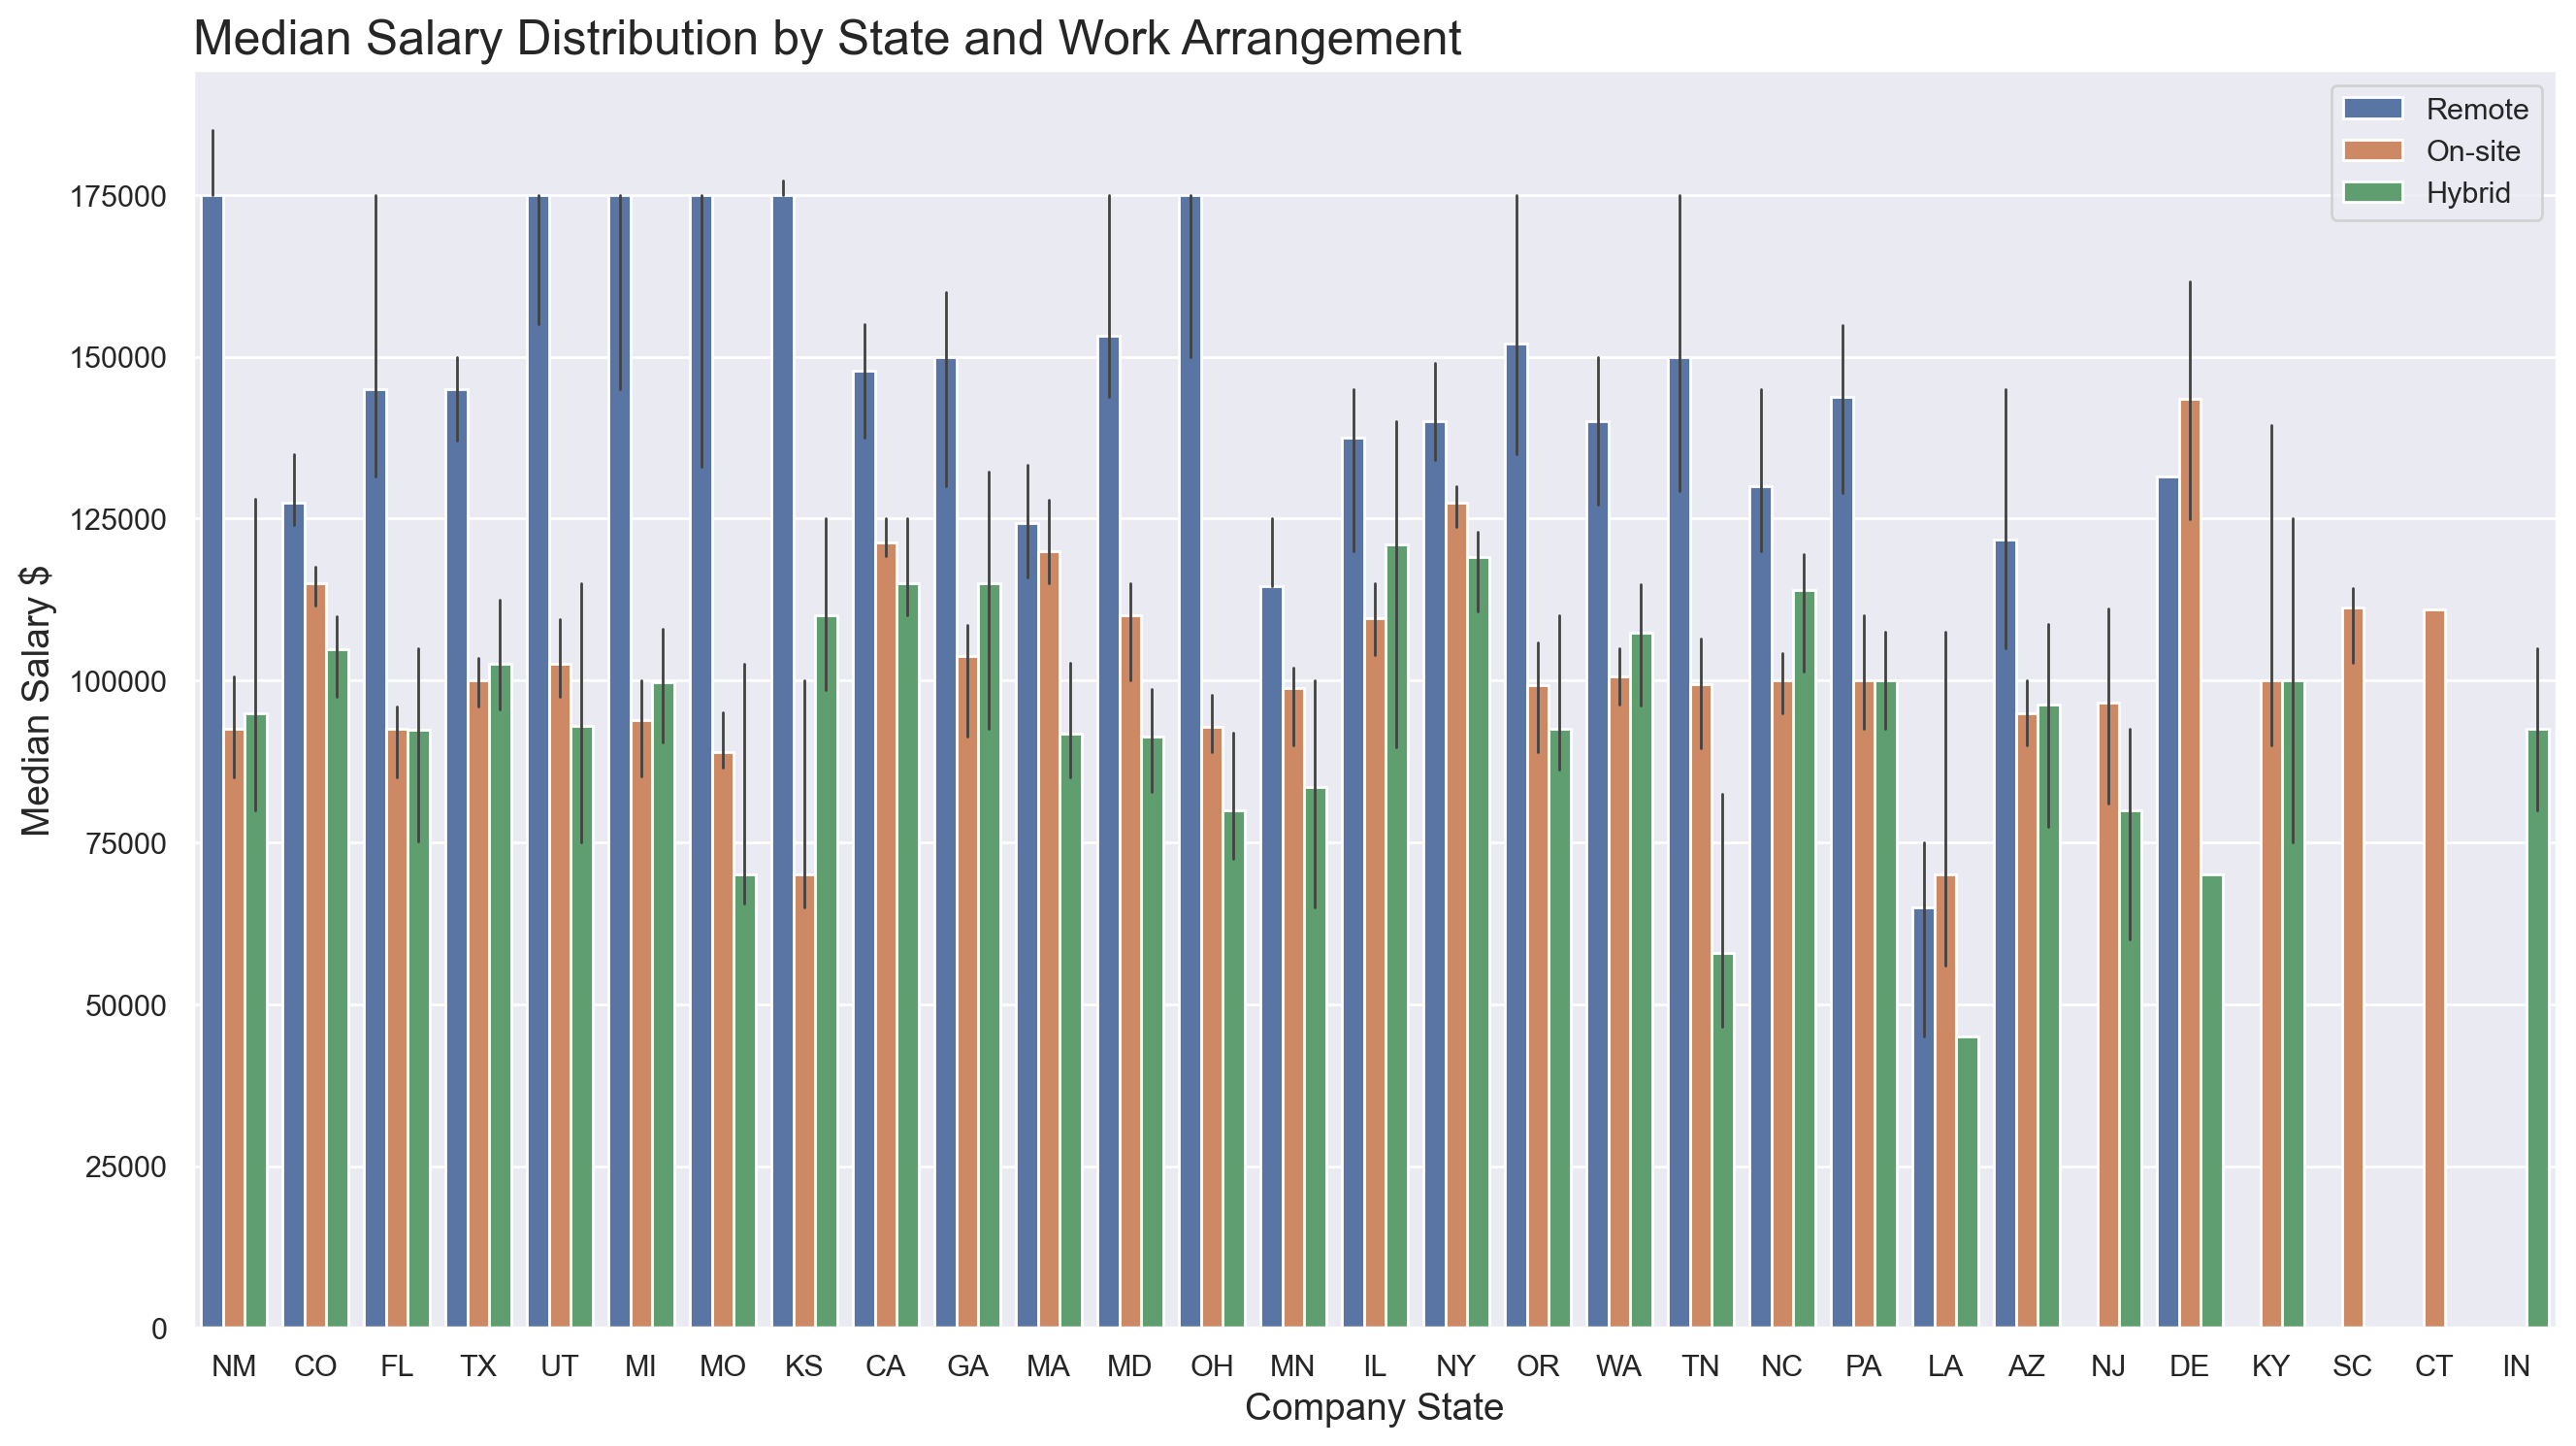

In [118]:
# Plotting the median salary distribution by state and work arrangement
fig, ax = plt.subplots(figsize = (14,8))

sns.barplot(data=df, x='company_state', y='salary_amount', hue='work_arrangement', estimator=np.median, errwidth=1, ax=ax)
ax.set_title('Median Salary Distribution by State and Work Arrangement', loc='left', fontsize=18)
ax.set_xlabel('Company State', fontsize = 14)
ax.set_ylabel('Median Salary $', fontsize = 14)
plt.legend(loc='upper right')
ax.get_legend().set_title("")

plt.show()

### Final findings from EDA  

Overall, salary has a typical right skewed distribution with the median equal to \\$114,500 and the mean equal to \\$120,064.  

#### Job Title
The most common job titles are Senior Data Engineer and Senior Software Engineer, and the majority of the job titles in the dataset are unique.  
There are many more job postings containing the word Senior than those containing the word Junior (about 90 times as many).  
Leadership positions with the highest median salary (equal to $225,000) are those containing the word head - which are also the rarest - followed by those containing the words principal, president and chief which are around \\$165,000.  

#### Company City
Only 80 cities have 25 or more job listings, and those with the most job listings are New York City, Denver and Austin.  
The cities with the highest median salary are Overland Park (KS), Santa Clara (CA) and Mountain View (CA), which are also the only ones exceeding \\$150,000.  
While Santa Clara and Mountain View are in Silicon Valley and are expected to pay top tier salaries, Overland Park is in Kansas and is not generally considered a tech hotspot: the most notable companies based there appear to be T-Mobile and Netsmart Technologies.  

#### Company State
The states with the most job listings are New York, California and Colorado, and those with the highest median salary are Delaware, New York, Kansas and California.  
While New York and California are expected to have high values, Delaware and Kansas are not and also show a small number of postings.  
Delaware, however, is an onshore corporate haven: because of its favourable corporate law, the state is home to more than half of all companies listed on the New York Stock Exchange.  

#### Work Arrangement  
While on-site job listings are by far the most frequent in the dataset, the remote median salary is significantly higher than those for on-site and hybrid work arrangements.  
A sensible hypothesis could be that - for higher positions and likely higher salaries - companies are more willing to hire remotely and attract the best talent rather than limiting themselves to more "local" candidates.  
This would make less sense for entry-level positions, which require a more consistent office presence in order to provide adequate support and training to recenlty hired employees.  


<br/><br/>

### Salary as a binary variable

We could perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.  


<br/><br/>

In [119]:
# Computing the median salary
median = df.salary_amount.median()
print(median)

114500.0


In [120]:
# Creating a function that defines if a salary is HIGH or LOW
def high_salary(row):
    median = df.salary_amount.median()
    if row['salary_amount'] >= median:
        return 1
    else:
        return 0

In [121]:
# Creating the new column and applying the function
df['high_salary'] = df.apply(lambda row: high_salary(row), axis=1)

In [122]:
df

,job_title,company_name,company_rating,company_location,company_city,company_state,salary_amount,salary_estimate,multi_candidate,multi_location,work_arrangement,job_snippet,high_salary
0,"Senior Software Engineer, Backend (Speech to T...",Recruiting From Scratch,3.8,"Remote in Albuquerque, NM 87105",Albuquerque,NM,190000.0,Not Available,Not Available,0,Remote,Their AI-powered collaborative note-taking app...,1
1,Senior / Staff NLP Engineer (Speech to Text St...,Recruiting From Scratch,3.8,"Remote in Albuquerque, NM 87105",Albuquerque,NM,210000.0,Not Available,Not Available,0,Remote,Members of the technology team work as a group...,1
2,Senior Data Engineer,Recruiting From Scratch,3.8,"Remote in Albuquerque, NM 87105",Albuquerque,NM,175000.0,Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...,1
3,Principal Data Engineer (Pre-IPO),Recruiting From Scratch,3.8,"Remote in Albuquerque, NM 87105",Albuquerque,NM,175000.0,Not Available,Not Available,0,Remote,Knowledge in at least one of following areas -...,1
4,Senior Machine Learning Engineer,Recruiting From Scratch,3.8,"Remote in Albuquerque, NM 87105+2 locations",Albuquerque,NM,175000.0,Not Available,Not Available,2,Remote,Knowledge in at least one of following areas -...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13355,"Sr. Product Manager, Talent & Culture Portfolio",Comcast,3.7,"Philadelphia, PA 19103+1 location",Philadelphia,PA,118680.0,Not Available,Not Available,1,On-site,Continually enhance our product offerings thro...,1
13356,Distinguished Solution Train Engineer (US),TD Bank,3.8,"Mount Laurel, NJ",Mount Laurel,NJ,172380.0,Not Available,Not Available,0,On-site,"Skill in using analytical software tools, data...",1
13357,Construction Projects Manager I,Chester County of Pennsylvania,3.8,"West Chester, PA",West Chester,PA,55739.0,Not Available,Not Available,0,On-site,Assist consultants and the Project Coordinator...,0
13358,School Nurse - Camden,KIPP New Jersey,3.5,"Camden, NJ",Camden,NJ,71500.0,Not Available,Not Available,0,On-site,Serve as consultants to other school professio...,0


#### Thought experiment: What is the baseline accuracy for this model?

Using the median as the splitting point means that the accuracy should be very close to 0.5 (the 50th percentile)  

<br/><br/>

In [123]:
df.high_salary.value_counts(normalize=True).max()

0.506062874251497

In [124]:
# Saving the modified dataframe as CSV
df.to_csv('datasets/df.csv', encoding='utf-8', index=False)